# Time series data science project

- **Chess players patterns discovery and analysis**
- **ariel-zil**

## Part 3 : classifier

In this section we will use the best clustering result from previous section to create a classifer that predicts skill changes after 3 months based on 9 months games

## 1. Imports

#### 1.1. Import packages

In [2]:
#
from dotenv import find_dotenv, load_dotenv
import pickle
import os
from collections import Counter
from tqdm import tqdm

#
from matplotlib import rcParams
import seaborn as sb
import matplotlib.pyplot as plt

#
import pandas as pd
import numpy as np

#
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap

#
from warnings import filterwarnings
filterwarnings("ignore")


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = 10,6
base_color = sb.color_palette()[0]

#
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

filterwarnings("ignore")

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b52e81200e0>
Traceback (most recent call last):
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribut

#### 1.2. enviroment variables loading

In [3]:
PROJECT_PATH=os.getenv('PROJECT_PATH')
NUMBER_OF_GAMES_MINIMUM=int(os.getenv('NUMBER_OF_GAMES_MINIMUM'))
FICS_MIN_YEAR=int(os.getenv('FICS_MIN_YEAR'))
FICS_MAX_YEAR=int(os.getenv('FICS_MAX_YEAR'))
MAX_K=int(os.getenv('MAX_K'))

#### 1.3. Load dataset

In [4]:
df_interval=pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-players-interval-90-euclidan-cluster.csv")
df_interval["Label"]=df_interval["EuclidanClusterSSID"]
df_interval=df_interval.drop("EuclidanClusterSSID",axis=1)
df_interval=df_interval.drop("EuclidanClusterMMID",axis=1)
df_interval.index=df_interval["Unnamed: 0"]
df_interval=df_interval.drop("Unnamed: 0",axis=1)

#### 1.4. Methods

In [5]:
def classify(df,test_size,model,name):
    train, test = train_test_split(df, test_size=test_size)
    y_train, y_test = train['Label'], test['Label']
    X_train, X_test = train.drop('Label', axis=1), test.drop('Label', axis=1)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print("Model name:",name)
    print("accuracy_score:",accuracy_score(y_test,y_predict))
    print("roc_auc_score:",roc_auc_score(y_test,y_predict))
    print("precision_score:",precision_score(y_test,y_predict))
    print("f1_score:",f1_score(y_test,y_predict))
    display( RocCurveDisplay.from_estimator(model, X_test, y_test))
    plt.show()
    try:
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
    except Exception as err:
        pass
    return {
        'model':model,
        'accuracy':accuracy_score(y_test,y_predict),
        'precision':precision_score(y_test,y_predict),
        'recall':recall_score(y_test,y_predict),
        'f1':f1_score(y_test,y_predict),
        'name':name
           }

def rfe(df,test_size,n_features_to_select,model,name):
    train, test = train_test_split(df, test_size=test_size)
    y_train, y_test = train['Label'], test['Label']
    X_train, X_test = train.drop('Label', axis=1), test.drop('Label', axis=1)
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)  # Adjust n_features_to_select as needed
    # Fit RFE
    rfe.fit(X_train, y_train)

    # Boolean mask of selected features
    selected_features = rfe.support_

    # Ranking of features, where 1 means selected
    feature_ranking = rfe.ranking_

    print("Model name:",name)
    print("selected_features:",selected_features)
    print("feature_ranking:",feature_ranking)
    return {
        'model':model,
        'selected_features':selected_features,
        'feature_ranking':feature_ranking,
        'name':name
           }

In [6]:
def label_trend(labels):

    mapping={
        0:"=",1:"-",2:"+",3:"-",4:"-",5:"+",
        6:"-",7:"-",8:"+",9:"=",10:"-",11:"+",
        12:"+",13:"-",14:"+",15:"+",16:"=",17:"=",
        18:"-",19:"=",20:"-",21:"+",22:"-",23:"=",
        24:"-",25:"+",26:"-",27:"-",28:"+",29:"=",
        30:"+",31:"-",32:"+",33:"-",34:"+",35:"=",
        36:"+",
    }
    return [mapping[l] for l in labels]
def choose_positive(labels):
    mapping={
        "=":0,
        "-":0,
        "+":1,
    }
    return [mapping[l] for l in labels]
def choose_negative(labels):
    mapping={
        "=":0,
        "-":1,
        "+":0,
    }
    return [mapping[l] for l in labels]

In [7]:
def get_models():
   return [
    {"name":"decision tree","model":DecisionTreeClassifier(random_state=42)},
    {"name":"Gaussian Naive Bayes","model":GaussianNB()},
    {"name":"KNeighborsClassifier","model":KNeighborsClassifier(2)},
    {"name":"AdaBoostClassifier","model":AdaBoostClassifier()},
    {"name":"CatBoostClassifier","model":CatBoostClassifier()},
    {"name":"XGBClassifier","model":XGBClassifier()},
    {"name":"LGBMClassifier","model":LGBMClassifier()},
    {"name":"logistic regression","model":LogisticRegression()},
    {"name":"Support vector machine","model":SVC(probability =True)},
    {"name":"basic random forrest","model":RandomForestClassifier(n_estimators=100, random_state=42)}
    ]

In [8]:
def compare_model_results(results):

    a, p, r, f,names = [], [], [], [],[]
    for res in results:
        a.append(res["accuracy"])
        p.append(res["precision"])
        r.append(res["recall"])
        f.append(res["f1"])
        names.append(res["name"])
    #
    model_score = pd.DataFrame([a,p,r,f],
                 columns = names).T.sort_values(by=3, ascending=False).rename(columns={0:'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1',}).round(4) 
    print(model_score)


In [24]:
from scipy.stats import skew

def get_feature_df(df):
    return pd.DataFrame.from_dict({
        "Player":[list(df["Player"])[0]],
        "mean":np.mean(list(df["Elo"])),
        "var":np.var(list(df["Elo"])),
        "kurtosis":skew(list(df["Elo"])),
        "skew":skew(list(df["Elo"])),
        "min":min(list(df["Elo"])),
        "max":max(list(df["Elo"])),
    })
def get_extra_feature_df(df):
    return df

def get_samples(df,max_date):
    groups={g:data for g,data in df.groupby("Player")}

    samples={"Player":list(groups.keys())}
    num_samples=0
    for k,v in groups.items():
        num_samples=max(num_samples,len(v[pd.to_datetime(v["Date"])<max_date]))
    
    for k,v in groups.items():
        r=list(v.sort_values(by="FICSGamesDBGameNo")["Elo"])
        for i in range(num_samples):
            try:
                samples[i]=samples.get(i,[])
                samples[i].append(r[i])
            except Exception as err:    
                samples[i].append(-1)
    return pd.DataFrame.from_dict(samples)


In [50]:

def get_features_per_player(players,max_date,df,extra_df):
    df_f=df[pd.to_datetime(df["Date"])<max_date]
    df_f=df_f[df_f["Player"].isin(players)]
    groups=df_f.groupby("Player")
    groups_d={p:groups.get_group(p) for p in players}
    frames=[]
    for p in players:
        frames.append(get_feature_df(groups_d.get(p)))
    
    return pd.concat(frames)


In [51]:

def get_game_ids(players,max_date,df):
    df_f=df[pd.to_datetime(df["Date"])<max_date]
    df_f=df_f[df_f["Player"].isin(players)]
    groups=df_f.groupby("Player")
    groups_d={p:groups.get_group(p) for p in players}
    ids=[]
    for p in players:
        for game_id in list((groups_d.get(p)["FICSGamesDBGameNo"])):
            ids.append(game_id)
    
    return ids


In [21]:
def get_extra_details_features(players,extra_df):
    features={
        "Player":[],
        "ECO_A":[],
        "ECO_B":[],
        "ECO_C":[],
        "ECO_D":[],
        "ECO_E":[],
        "PlyCountMean":[],
        "PlyCountVar":[],
        "PlyCountSkew":[],
        "TotalGames":[],
        "EloDiff_1/3_mean":[],
        "EloDiff_2/3_mean":[],
        "EloDiff_3/3_mean":[],
        "EloDiff_mean":[],
        "EloDiff_1/3_time_mean":[],
        "EloDiff_2/3_time_mean":[],
        "EloDiff_3/3_time_mean":[],
        "total_games_1/3_time_mean":[],
        "total_games_2/3_time_mean":[],
        "total_games_3/3_time_mean":[],
    }
    for p in tqdm(players):
        try:
            curr_w=extra_df.groupby("White").get_group(p)
        except Exception as err:
            curr_w=None

        try:
            curr_b=extra_df.groupby("Black").get_group(p)
        except Exception as err:
            curr_b=None

        if curr_w is None and curr_b is not None:
            curr=curr_b
        elif curr_b is None and curr_w is not None:
            curr=curr_w
        else:    
            curr=pd.concat([curr_w,curr_b])
            
        eco=dict(Counter(list(curr["ECO"].apply(lambda m:m[0]))))
        total_eco=sum(eco.values())
        for k in ["A","B","C","D","E"]:
            features[f"ECO_{k}"].append(100*(eco.get(k,0)/total_eco))

        features["Player"].append(p)
        features["PlyCountMean"].append(np.mean(curr["PlyCount"]))
        features["PlyCountVar"].append(np.var(curr["PlyCount"]))
        features["PlyCountSkew"].append(skew(curr["PlyCount"]))
        features["TotalGames"].append(len(curr))
        all_elo_diff=list(curr["EloDiff"])
        total=len(all_elo_diff)
        p1=int(total/3)
        p2=int(2*total/3)
        p3=total

        features["EloDiff_1/3_mean"].append(np.mean([all_elo_diff[i] for i in range(0,p1)]))
        features["EloDiff_2/3_mean"].append(np.mean([all_elo_diff[i] for i in range(p1,p2)]))
        features["EloDiff_3/3_mean"].append(np.mean([all_elo_diff[i] for i in range(p2,p3)]))
        features["EloDiff_mean"].append(np.mean(all_elo_diff))

        date_1=pd.to_datetime([f'{2018}-03-01 00:00:00']).min()
        date_2=pd.to_datetime([f'{2018}-06-01 00:00:00']).min()
        date_3=pd.to_datetime([f'{2018}-09-01 00:00:00']).min()
        features["EloDiff_1/3_time_mean"].append(np.mean(curr[(pd.to_datetime(curr["Date"])<date_1)]["EloDiff"]))
        features["EloDiff_2/3_time_mean"].append(np.mean(curr[(pd.to_datetime(curr["Date"])>=date_1)&
                                                              (pd.to_datetime(curr["Date"])<date_2)
                                                              ]["EloDiff"]))
        features["EloDiff_3/3_time_mean"].append(np.mean(curr[(pd.to_datetime(curr["Date"])>=date_2)&
                                                              (pd.to_datetime(curr["Date"])<date_3)
                                                              ]["EloDiff"]))

        features["total_games_1/3_time_mean"].append(len(curr[(pd.to_datetime(curr["Date"])<date_1)]["EloDiff"]))
        features["total_games_2/3_time_mean"].append(len(curr[(pd.to_datetime(curr["Date"])>=date_1)&
                                                              (pd.to_datetime(curr["Date"])<date_2)
                                                              ]["EloDiff"]))
        features["total_games_3/3_time_mean"].append(len(curr[(pd.to_datetime(curr["Date"])>=date_2)&
                                                              (pd.to_datetime(curr["Date"])<date_3)
                                                              ]["EloDiff"]))

    df= pd.DataFrame.from_dict(features)
    df.index=list(df["Player"])
    df=df.drop(columns=["Player"])
    return df


## 2. clasification of improving pattern

### 2.1. using samples as interval (take 9 months and predict results after another 3 months)

In [45]:
df_interval["Label"]=choose_positive(label_trend(df_interval["Label"]))
df_interval["Label"].value_counts()

Label
0    3584
1    2415
Name: count, dtype: int64

In [28]:
df_interval.to_csv(f"{PROJECT_PATH}/data/fics/interim/player_labels.csv")

####  2.1.1. *run classification models*

-------------------------------------------------- decision tree --------------------------------------------------
Model name: decision tree
accuracy_score: 0.7283333333333334
roc_auc_score: 0.7219991075412762
precision_score: 0.6686274509803921
f1_score: 0.6765873015873015


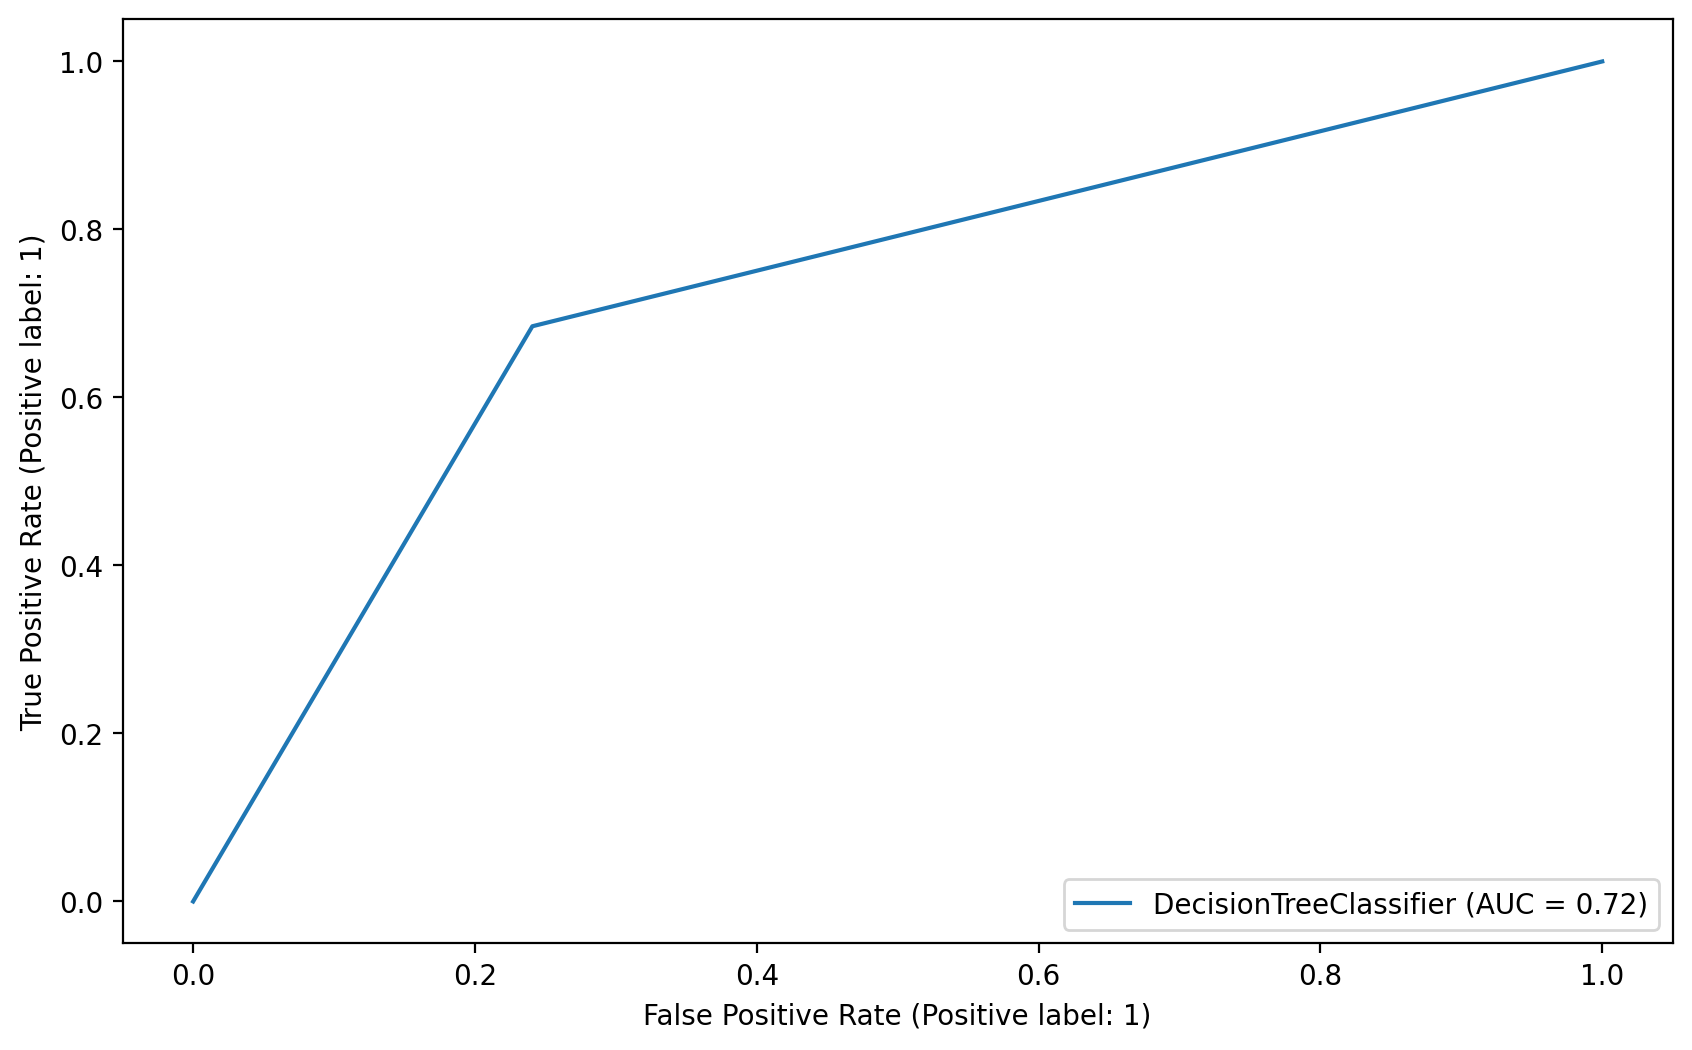

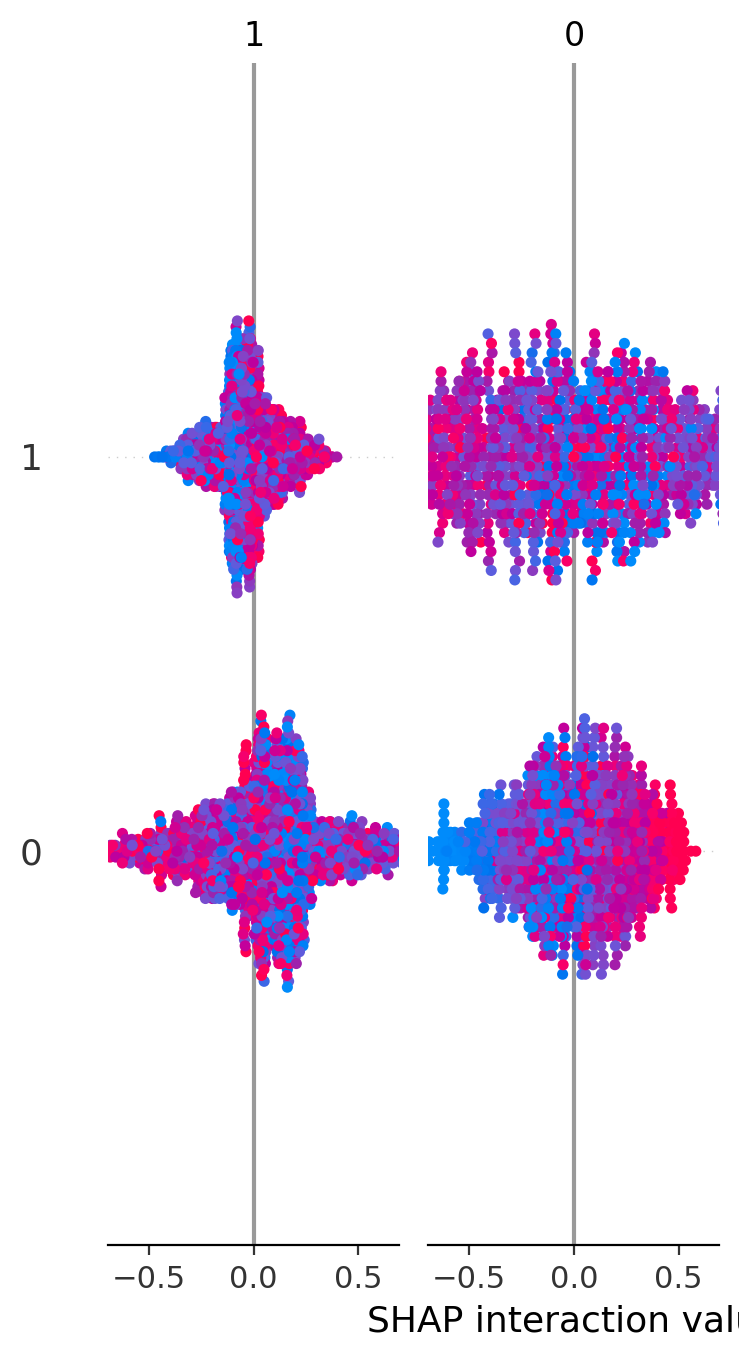

-------------------------------------------------- Gaussian Naive Bayes --------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.5975
roc_auc_score: 0.5070287374208943
precision_score: 0.5555555555555556
f1_score: 0.05847953216374269


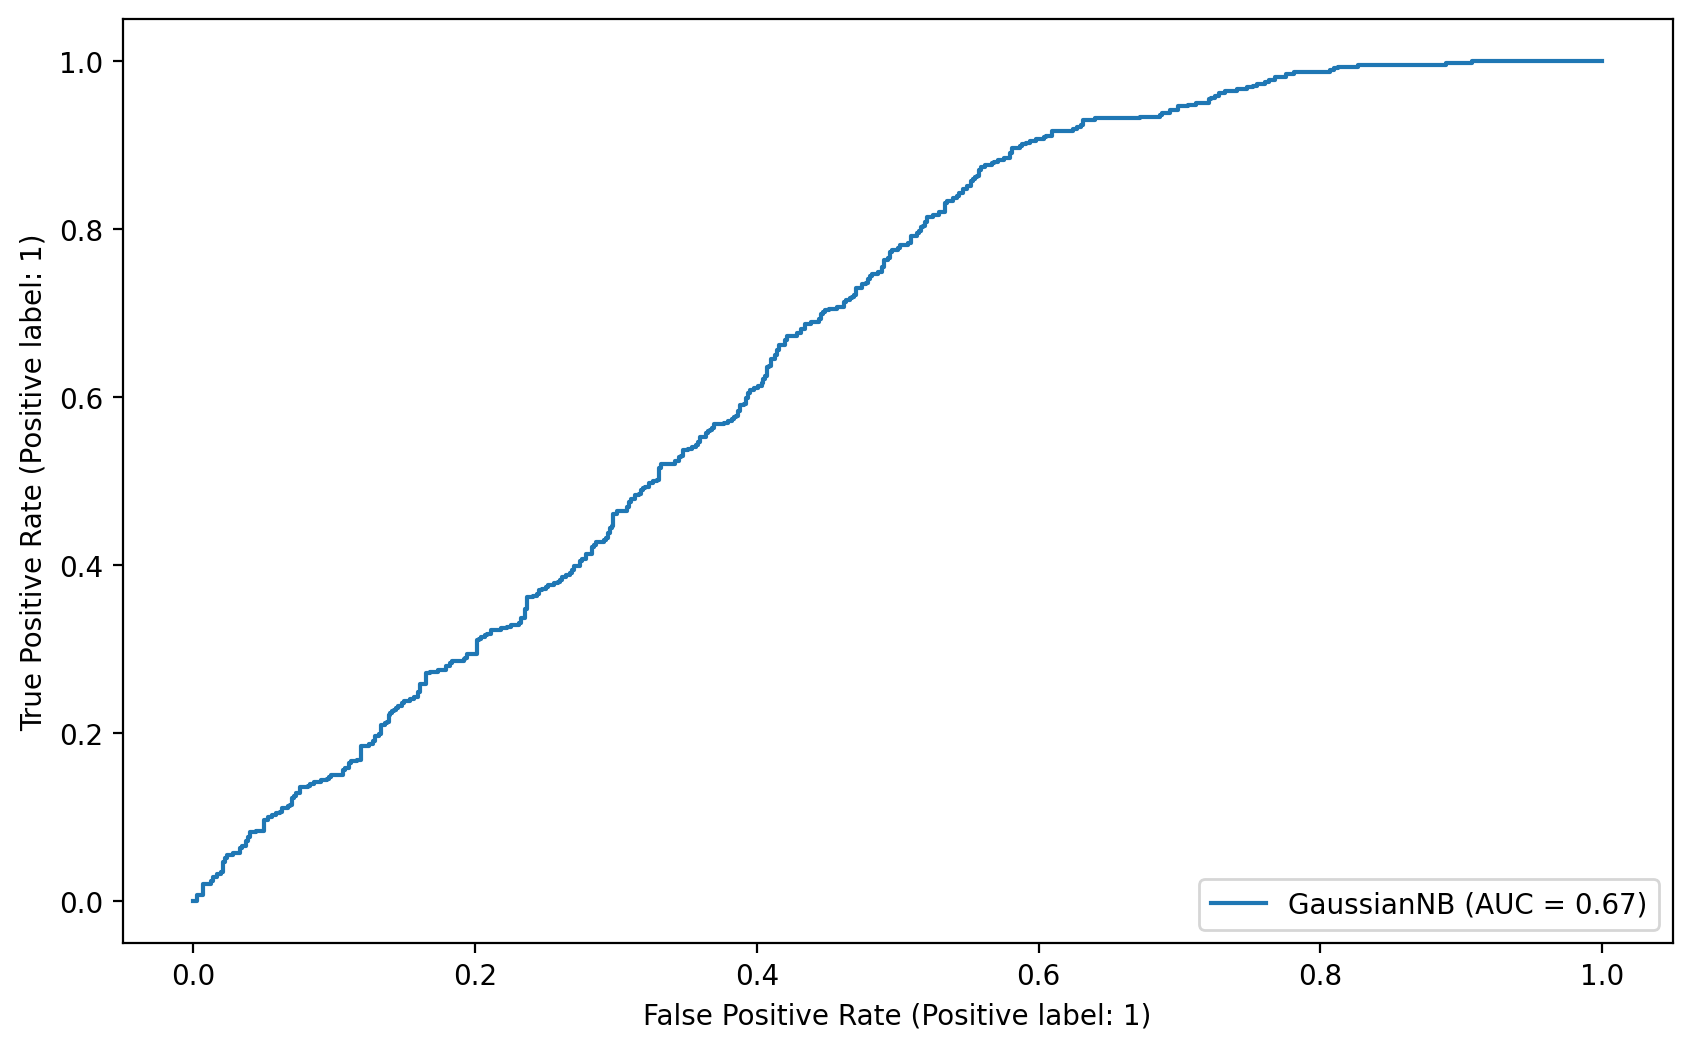

-------------------------------------------------- KNeighborsClassifier --------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.74
roc_auc_score: 0.7015799997688369
precision_score: 0.7672955974842768
f1_score: 0.61


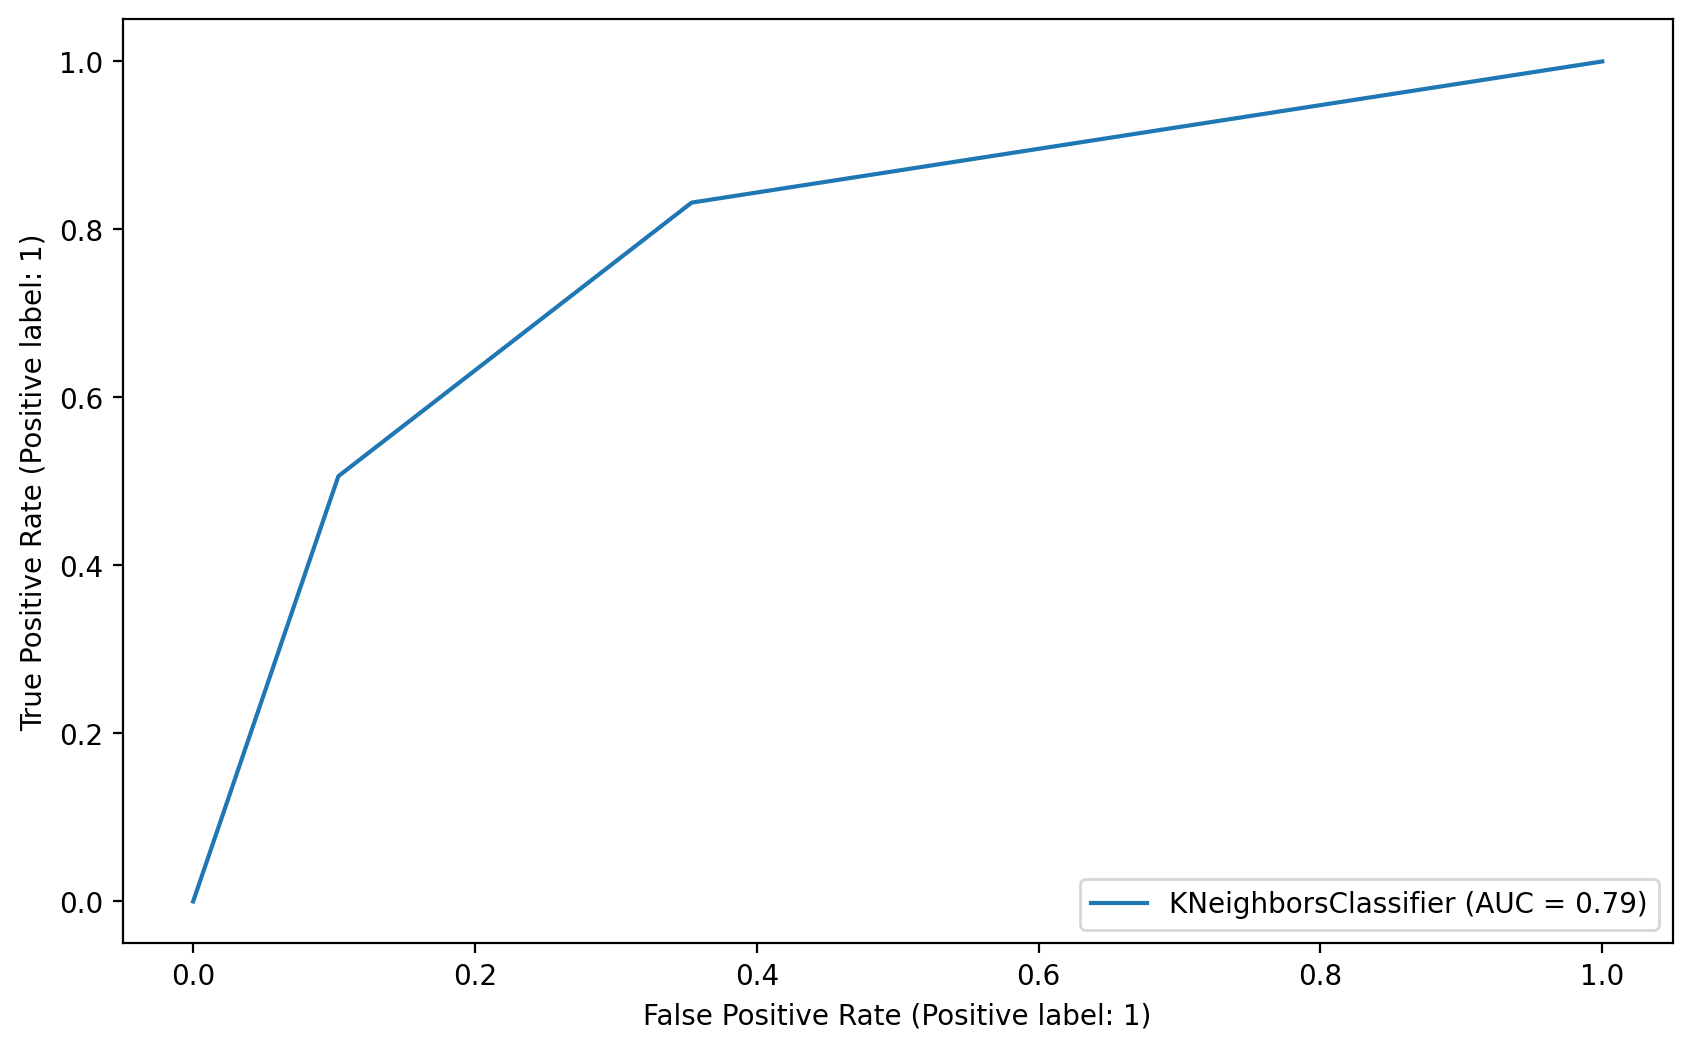

-------------------------------------------------- AdaBoostClassifier --------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.7091666666666666
roc_auc_score: 0.6740321534135967
precision_score: 0.7
f1_score: 0.5769696969696969


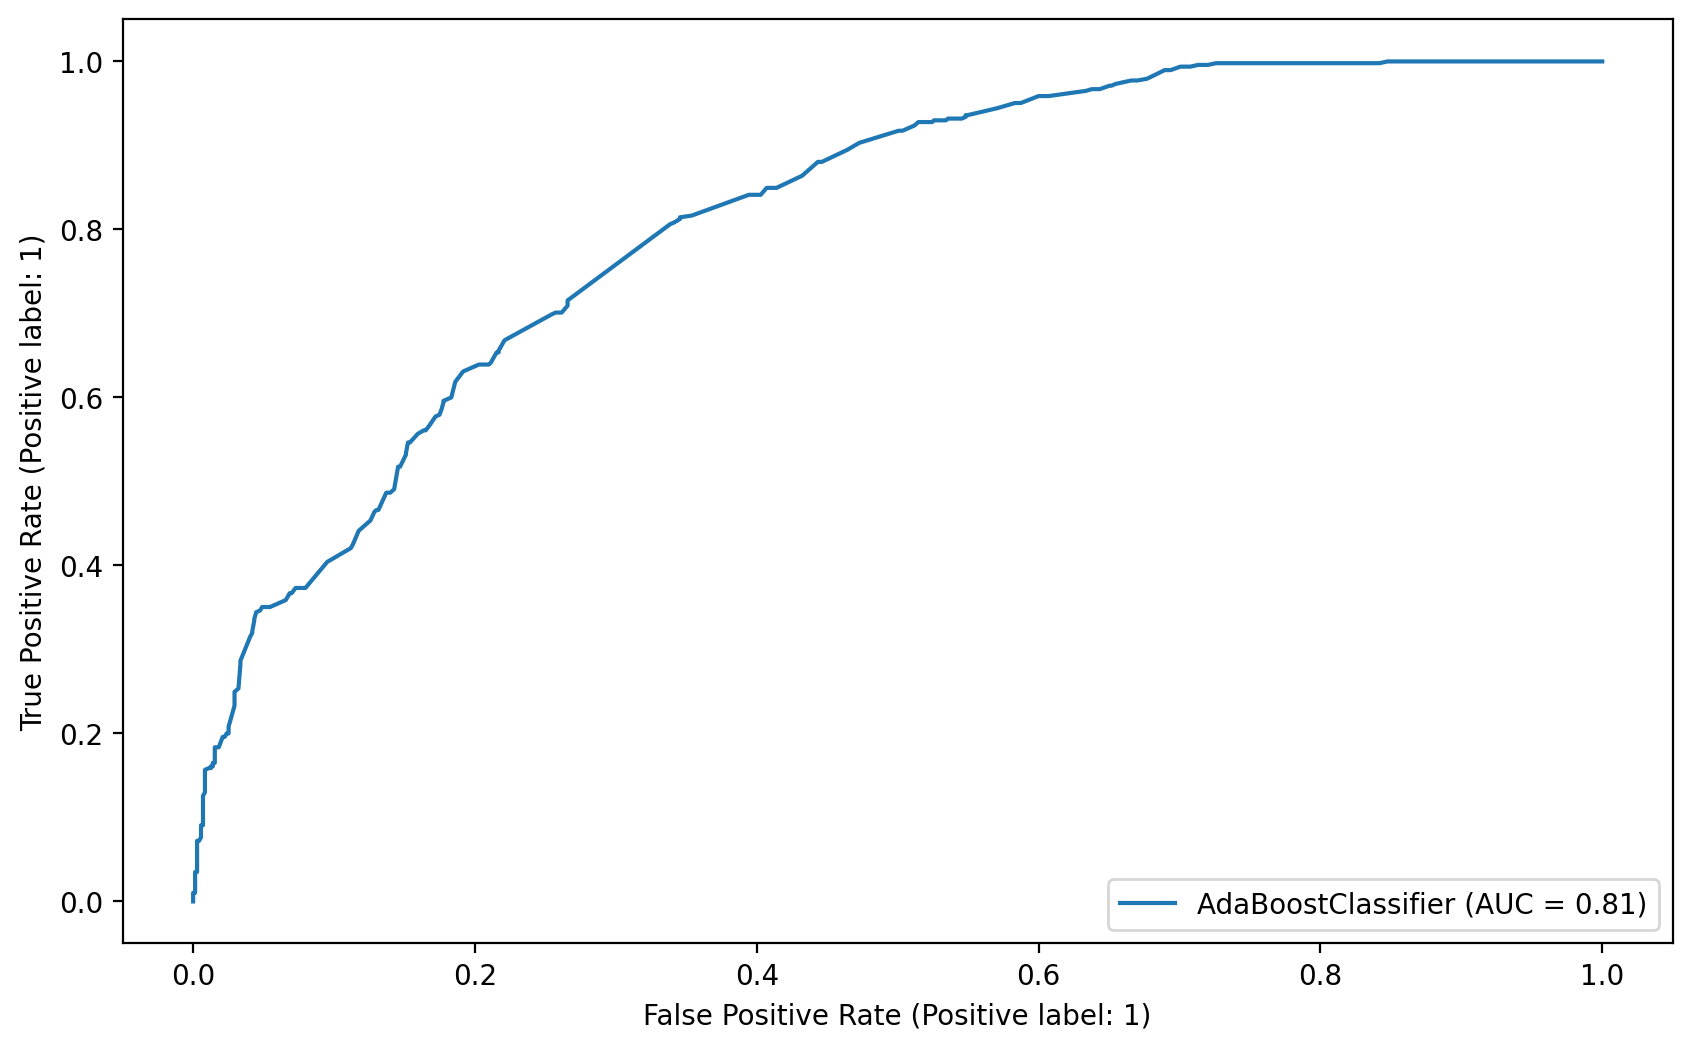

-------------------------------------------------- CatBoostClassifier --------------------------------------------------
Learning rate set to 0.020127
0:	learn: 0.6890233	total: 47.8ms	remaining: 47.8s
1:	learn: 0.6854083	total: 50.1ms	remaining: 25s
2:	learn: 0.6815897	total: 51.2ms	remaining: 17s
3:	learn: 0.6790876	total: 52.4ms	remaining: 13s
4:	learn: 0.6763557	total: 56.2ms	remaining: 11.2s
5:	learn: 0.6729212	total: 57.5ms	remaining: 9.52s
6:	learn: 0.6704567	total: 58.9ms	remaining: 8.35s
7:	learn: 0.6669924	total: 60ms	remaining: 7.44s
8:	learn: 0.6638291	total: 61ms	remaining: 6.72s
9:	learn: 0.6612310	total: 62ms	remaining: 6.14s
10:	learn: 0.6584976	total: 63.1ms	remaining: 5.67s
11:	learn: 0.6552417	total: 64.1ms	remaining: 5.28s
12:	learn: 0.6523530	total: 65.1ms	remaining: 4.94s
13:	learn: 0.6500071	total: 66.1ms	remaining: 4.66s
14:	learn: 0.6478618	total: 67.3ms	remaining: 4.42s
15:	learn: 0.6455154	total: 68.3ms	remaining: 4.2s
16:	learn: 0.6432084	total: 69.3ms	remai

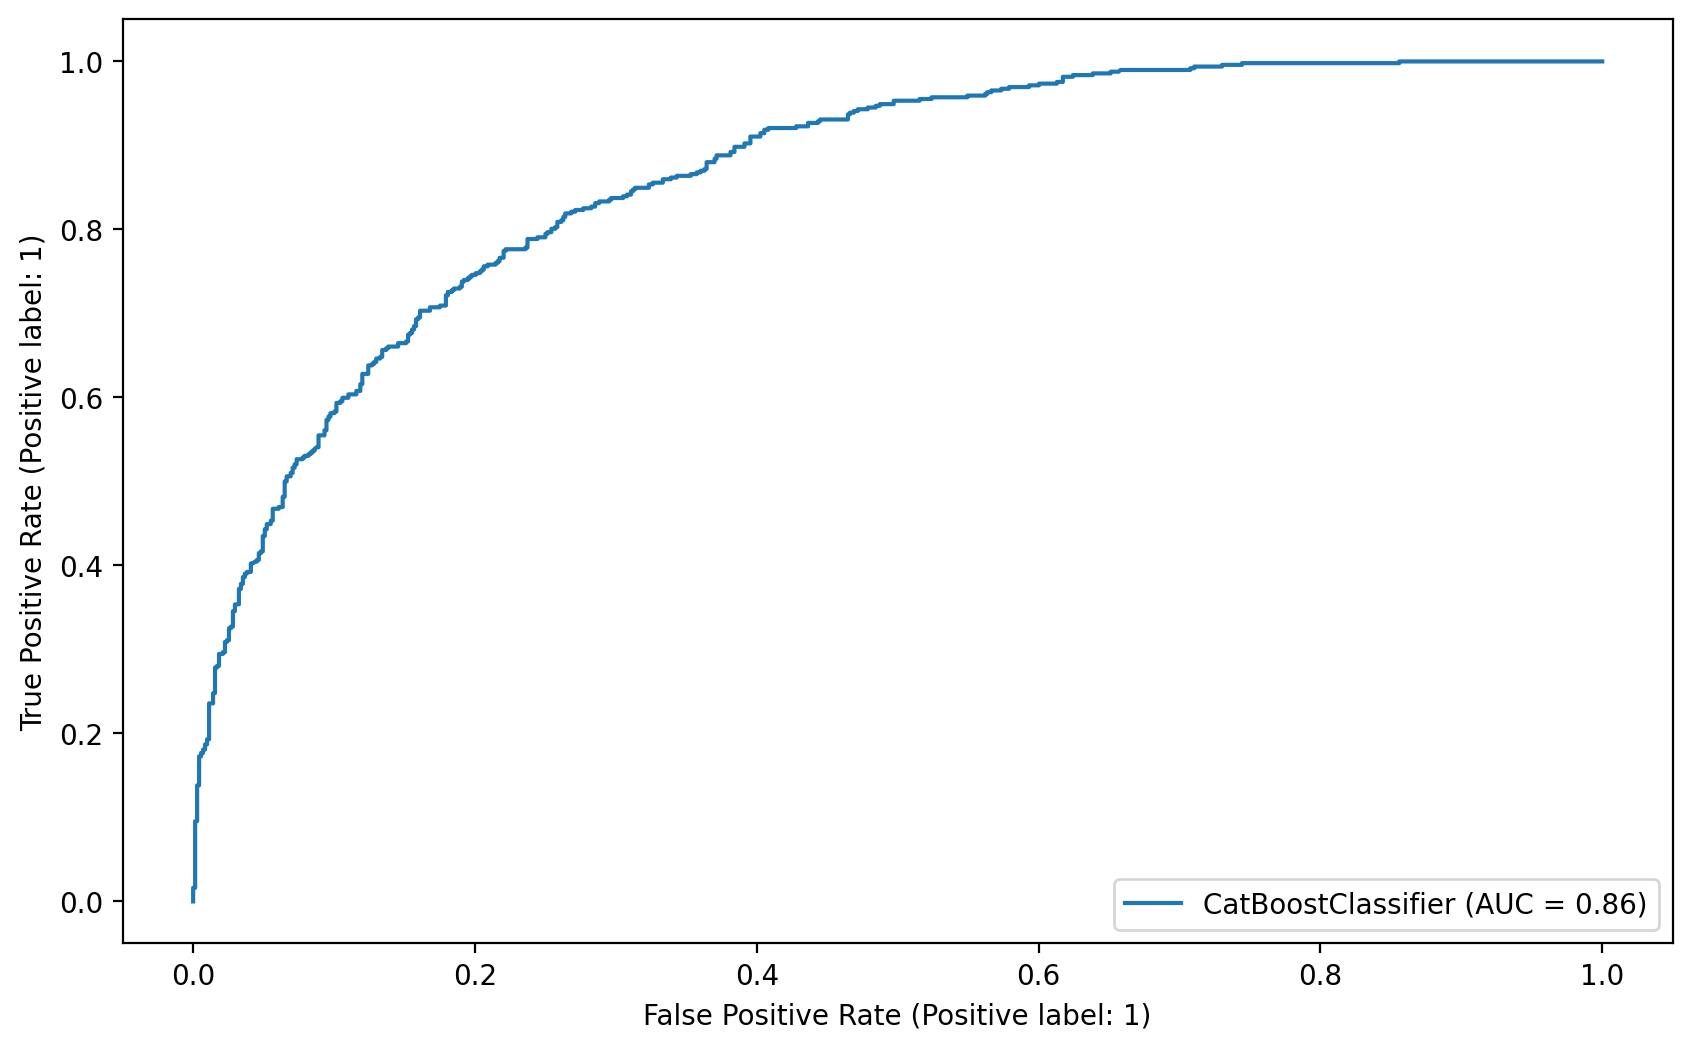

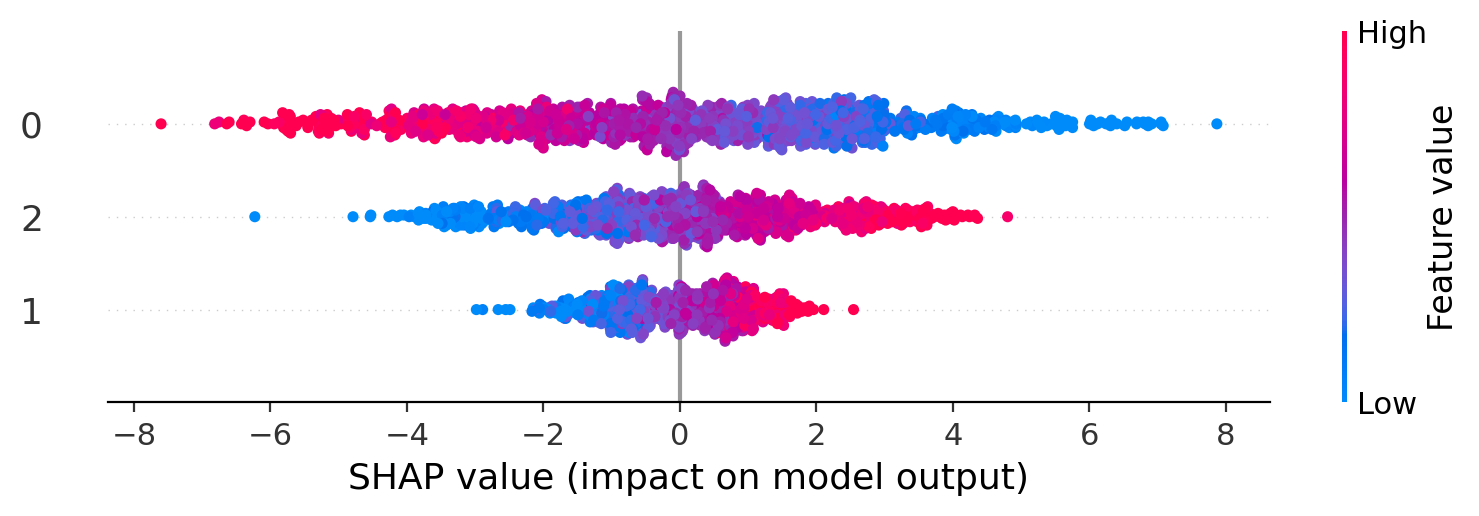

-------------------------------------------------- XGBClassifier --------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.7691666666666667
roc_auc_score: 0.7548435127532104
precision_score: 0.6989010989010989
f1_score: 0.696604600219058


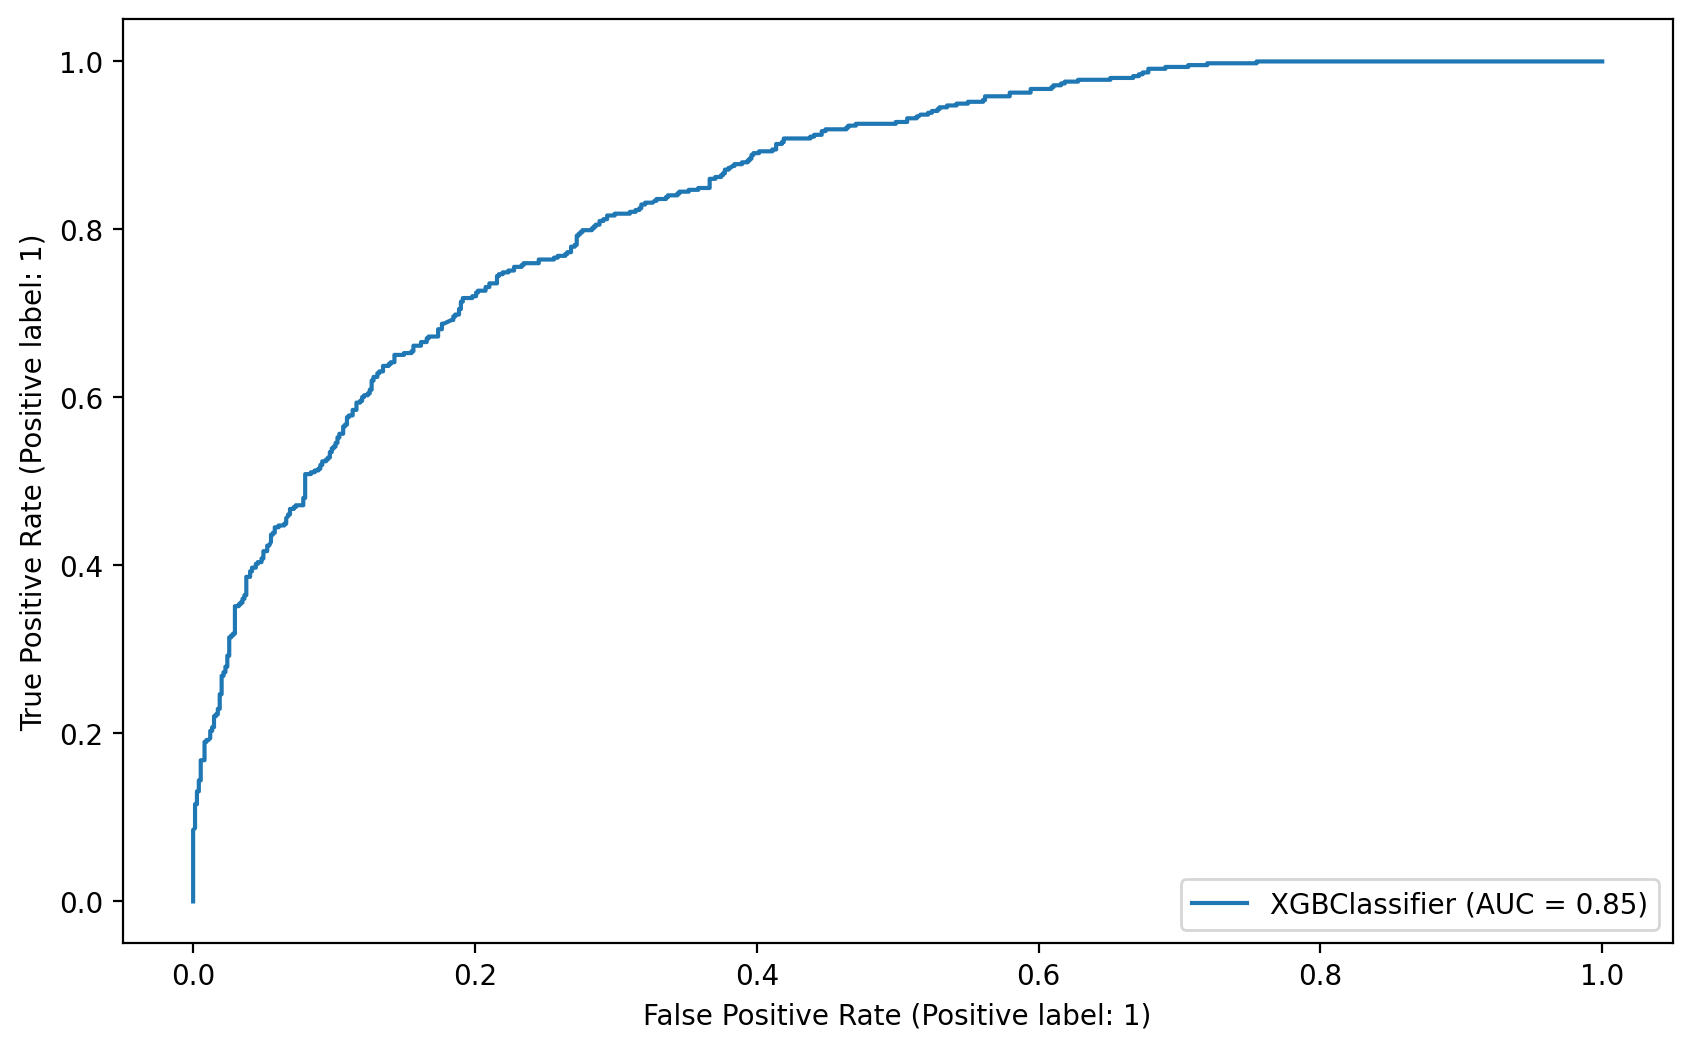

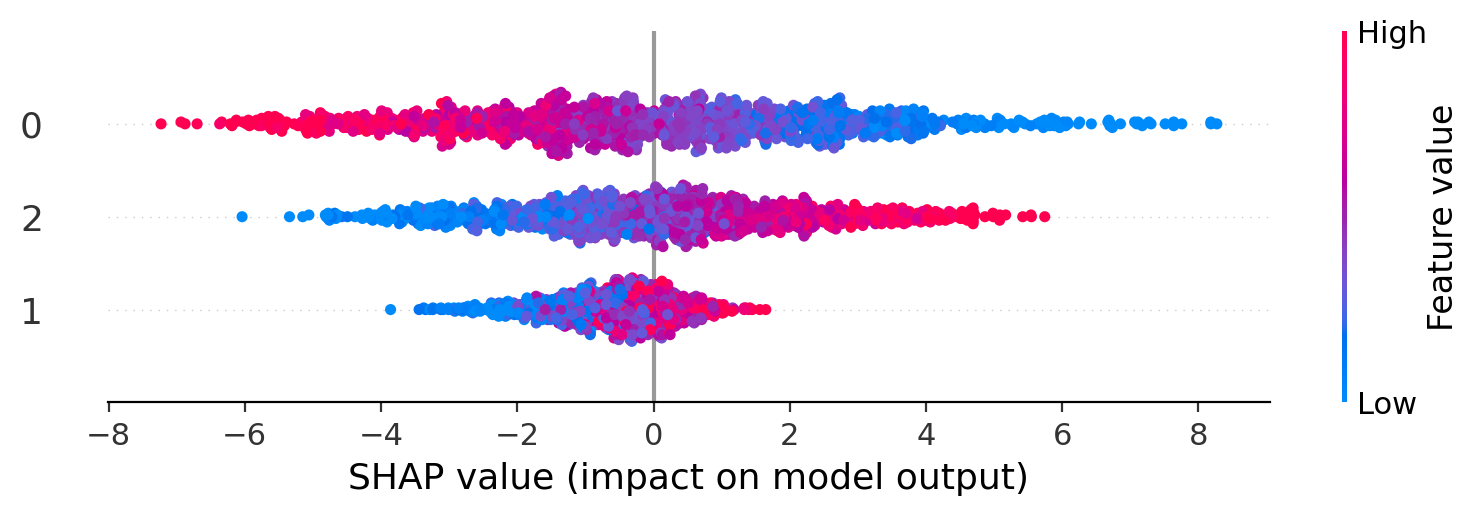

-------------------------------------------------- LGBMClassifier --------------------------------------------------
[LightGBM] [Info] Number of positive: 1930, number of negative: 2869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402167 -> initscore=-0.396444
[LightGBM] [Info] Start training from score -0.396444
Model name: LGBMClassifier
accuracy_score: 0.79
roc_auc_score: 0.7790065604498595
precision_score: 0.7494646680942184
f1_score: 0.7352941176470588


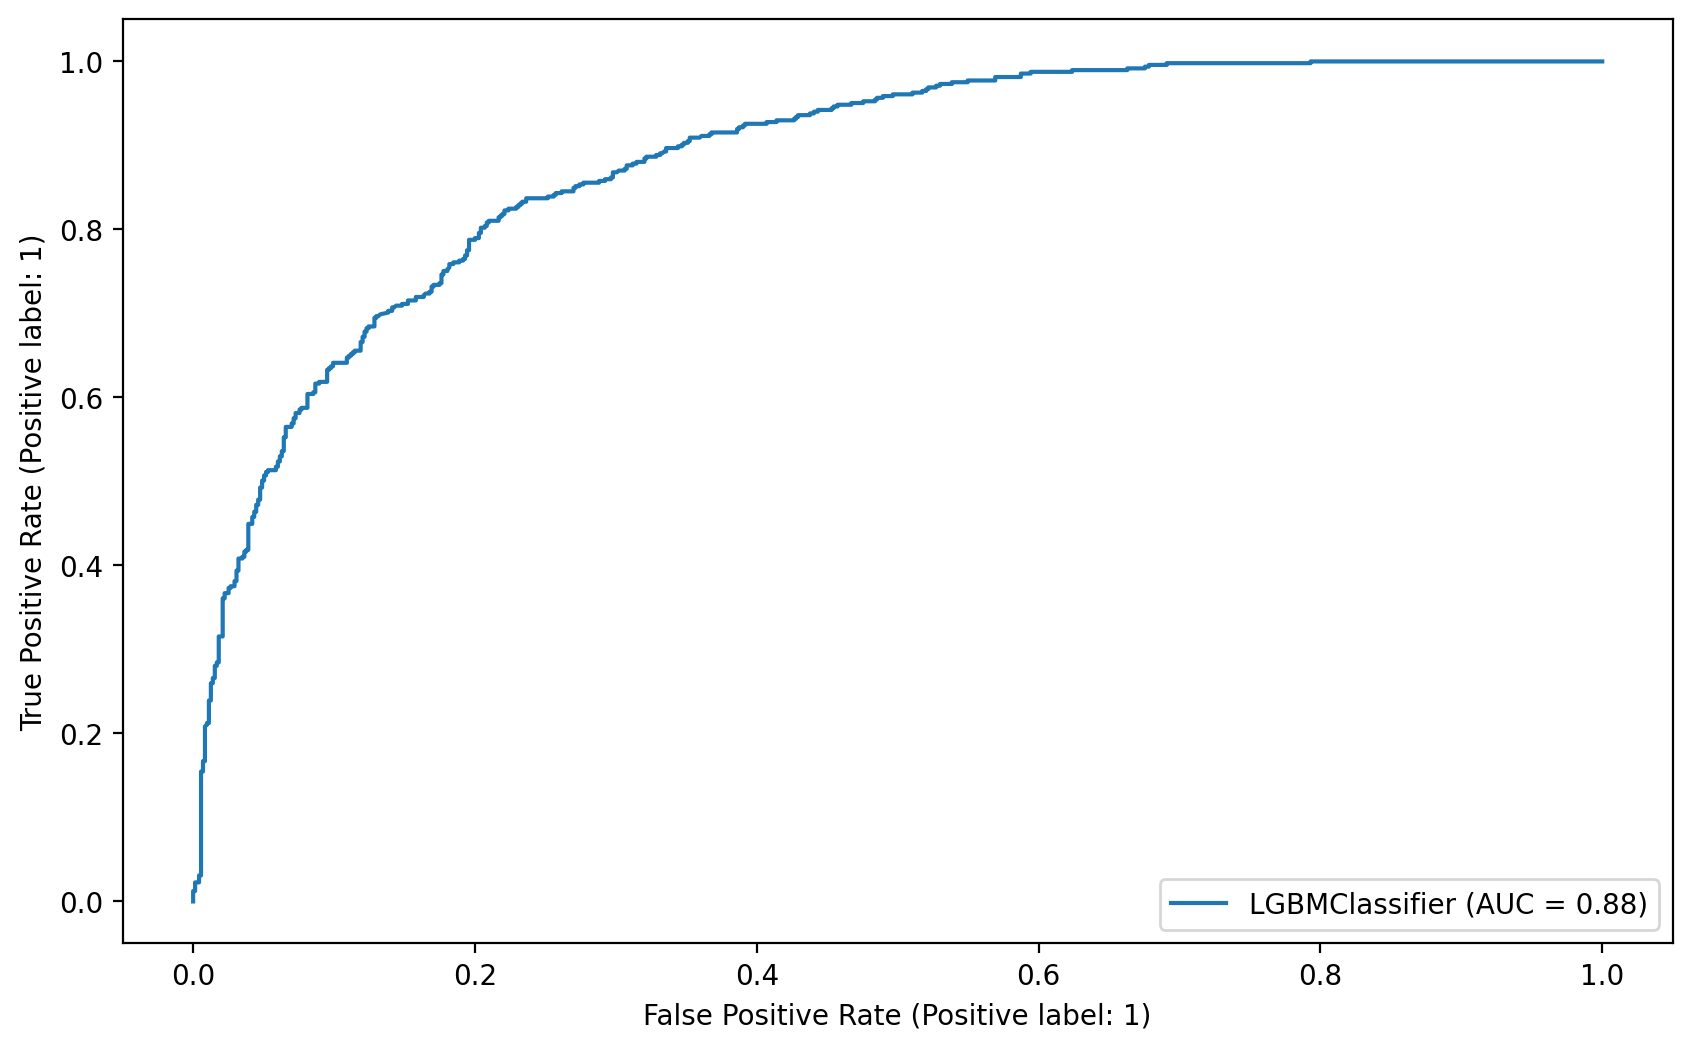

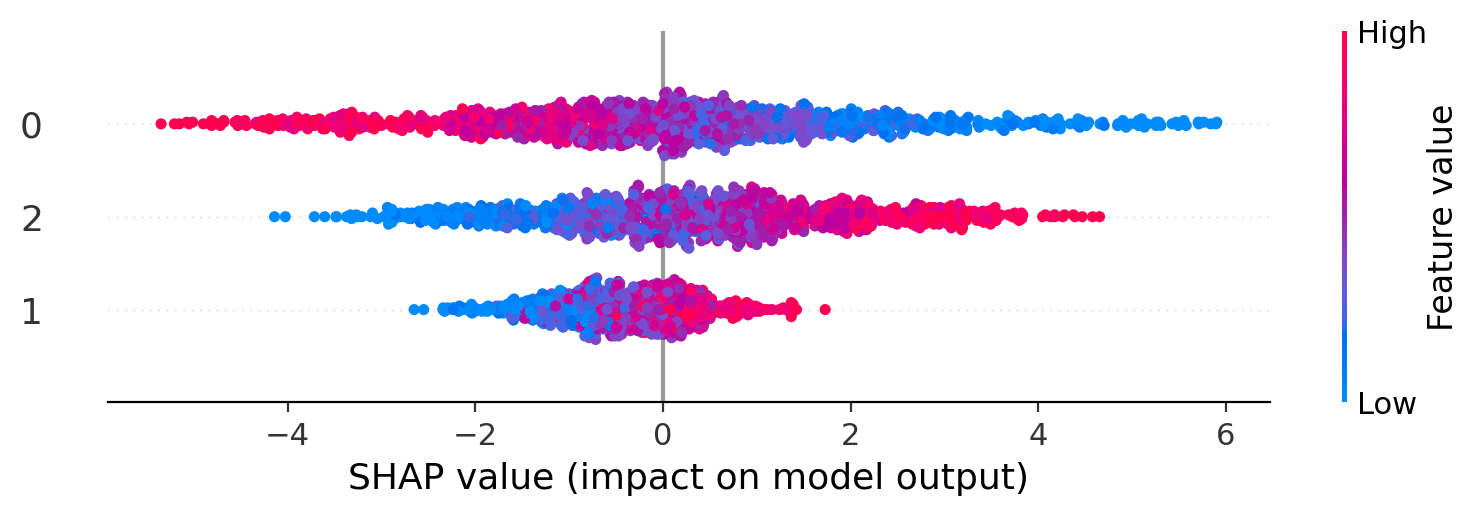

-------------------------------------------------- logistic regression --------------------------------------------------
Model name: logistic regression
accuracy_score: 0.7983333333333333
roc_auc_score: 0.7865096655946329
precision_score: 0.7652173913043478
f1_score: 0.744186046511628


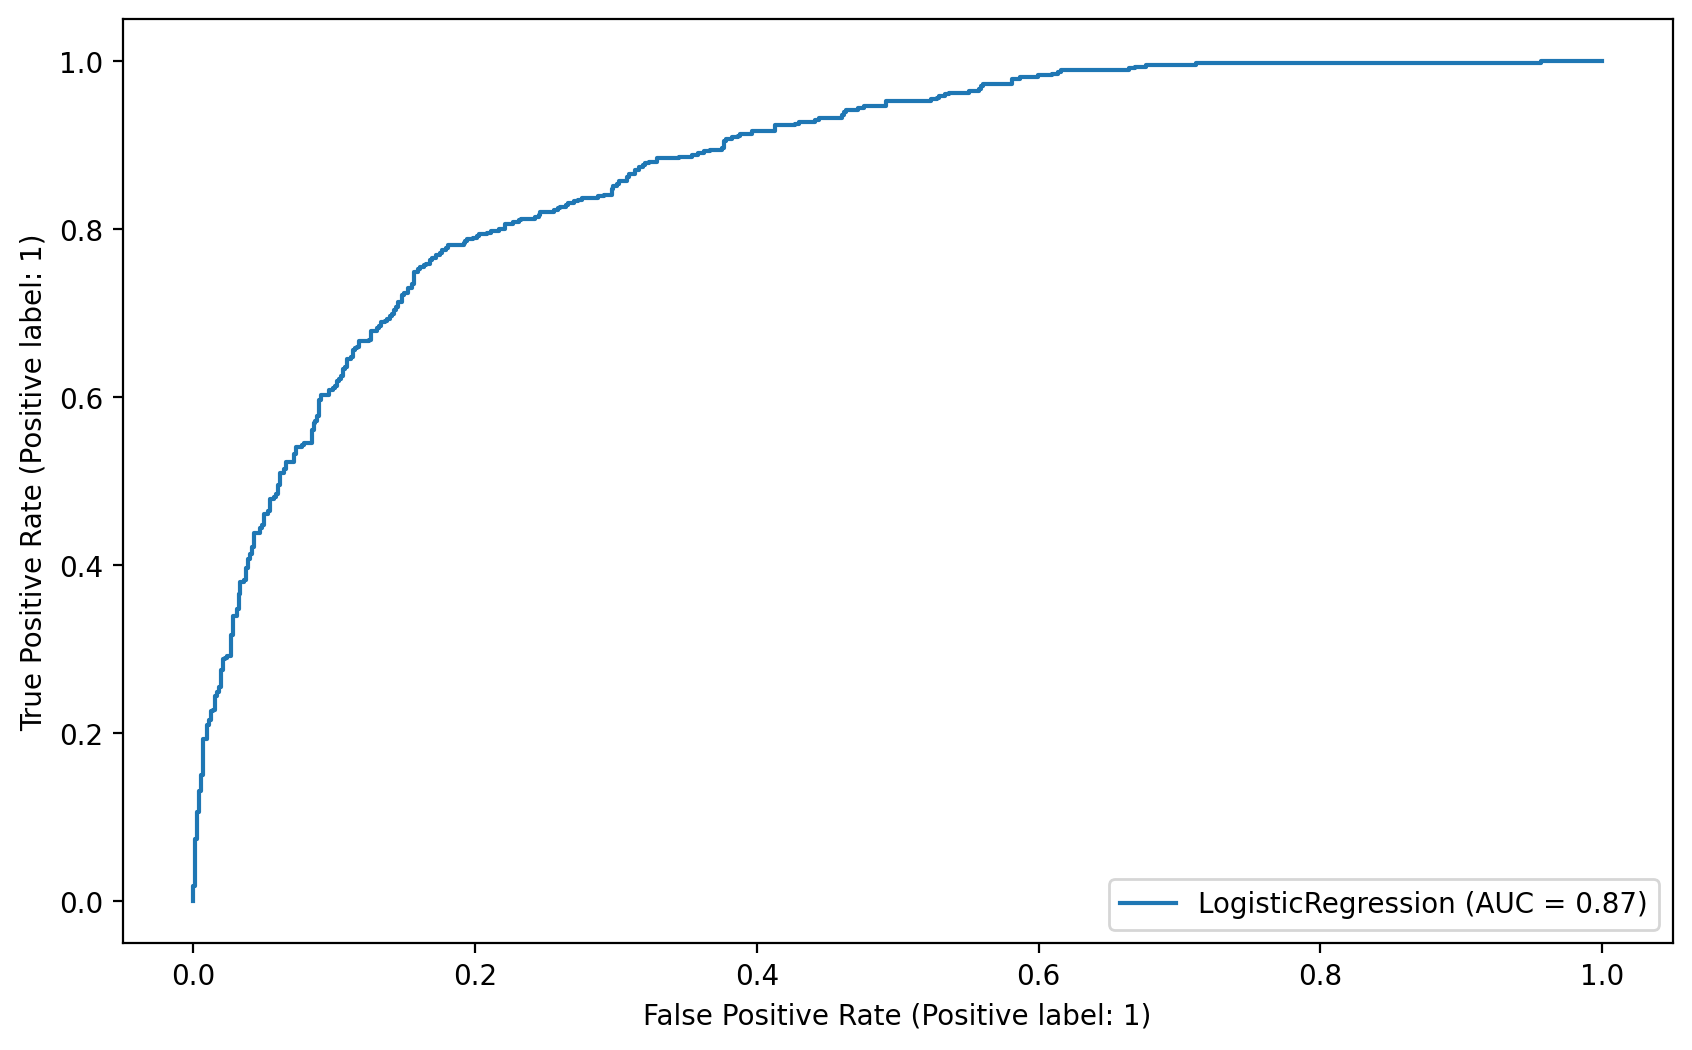

-------------------------------------------------- Support vector machine --------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.7816666666666666
roc_auc_score: 0.7644363602873457
precision_score: 0.7627906976744186
f1_score: 0.7145969498910676


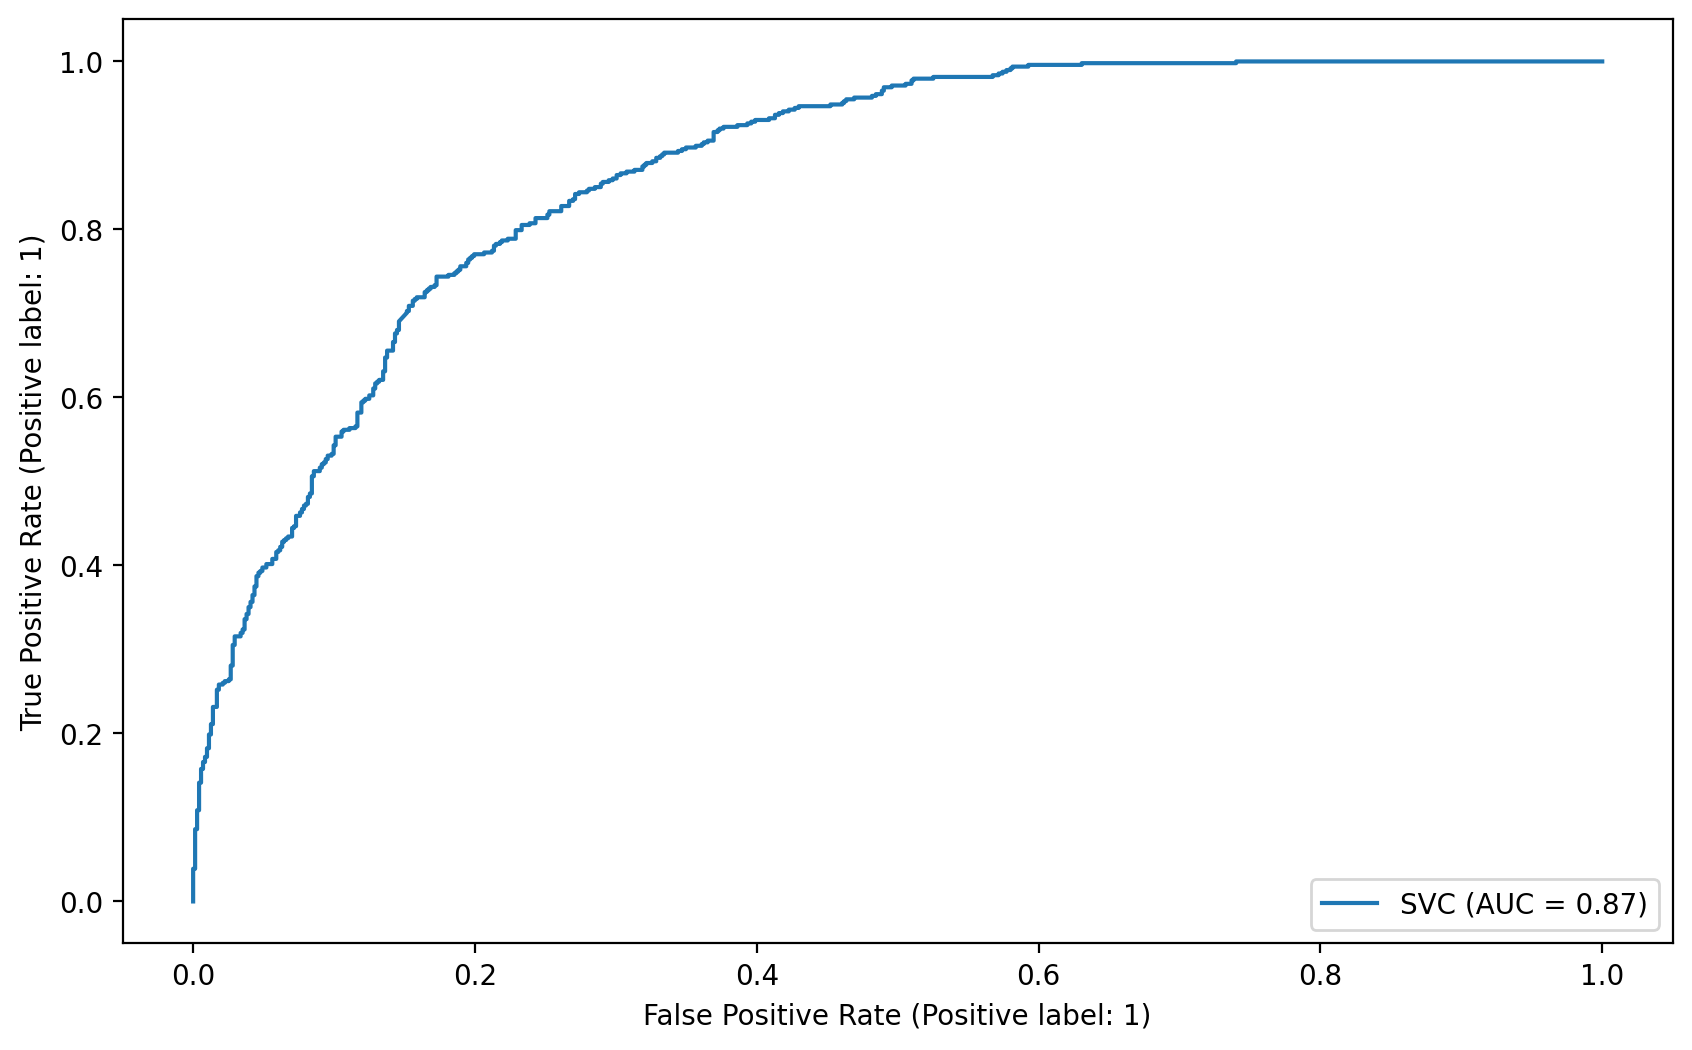

-------------------------------------------------- basic random forrest --------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.79
roc_auc_score: 0.7754239724058638
precision_score: 0.7680180180180181
f1_score: 0.7301927194860814


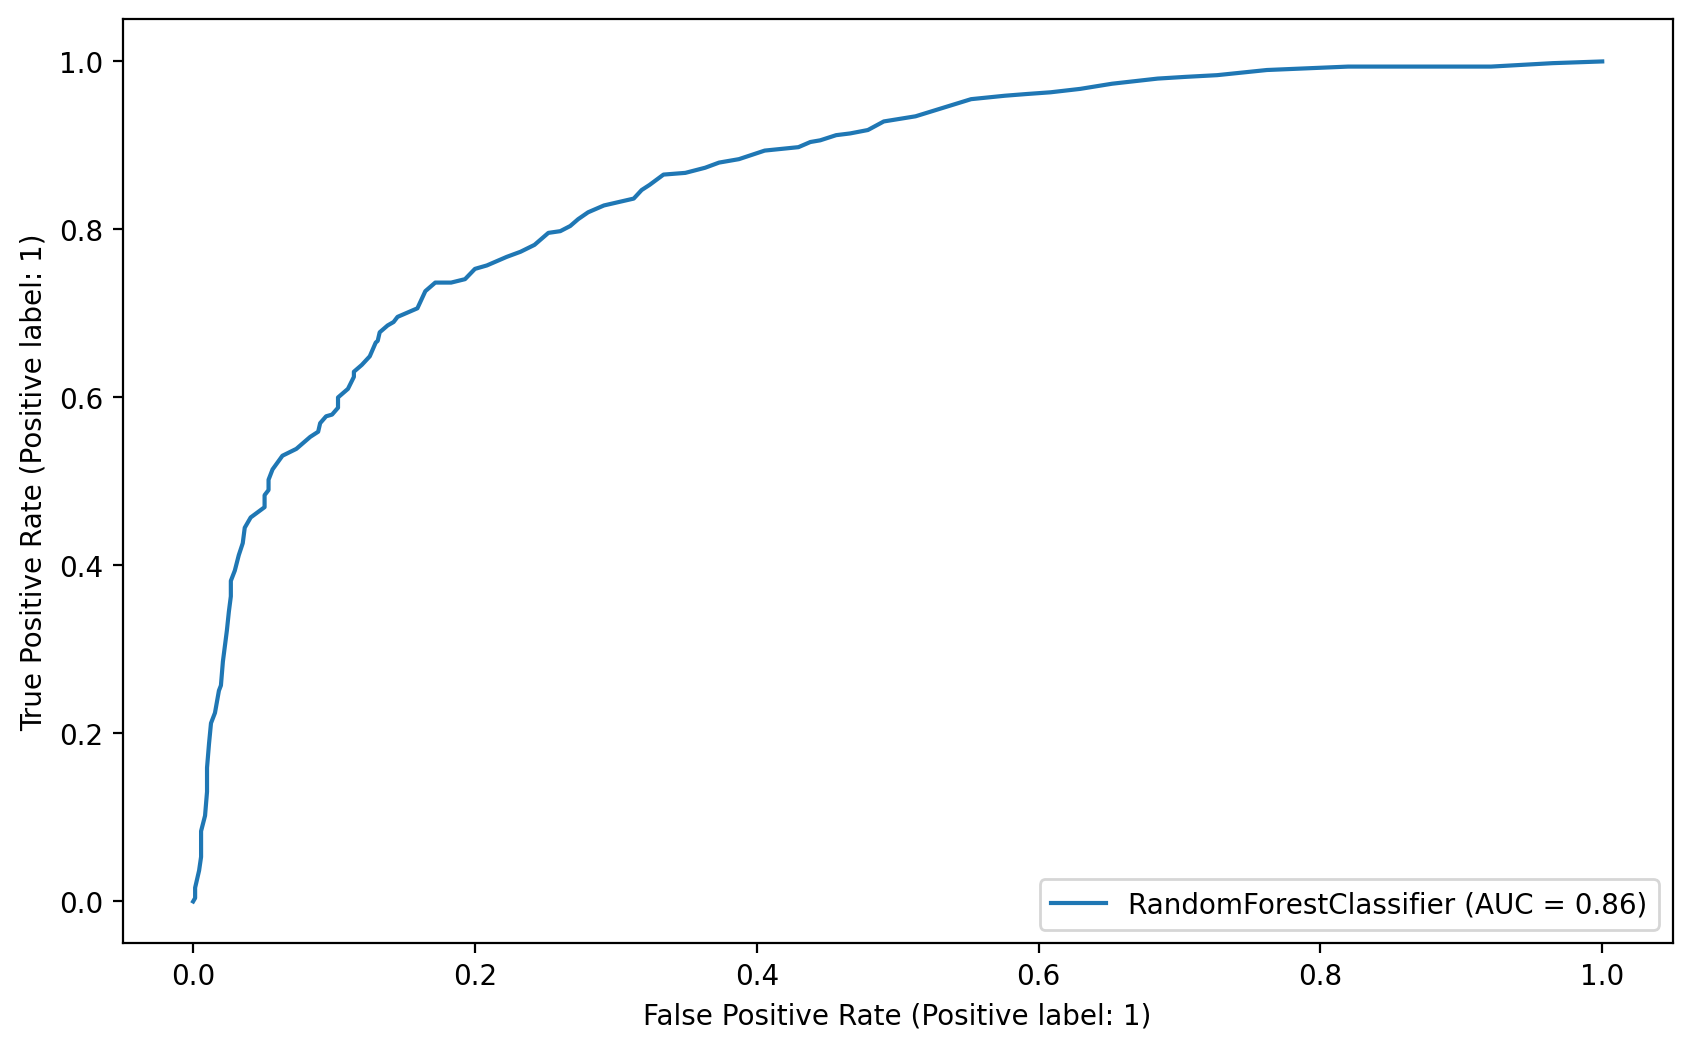

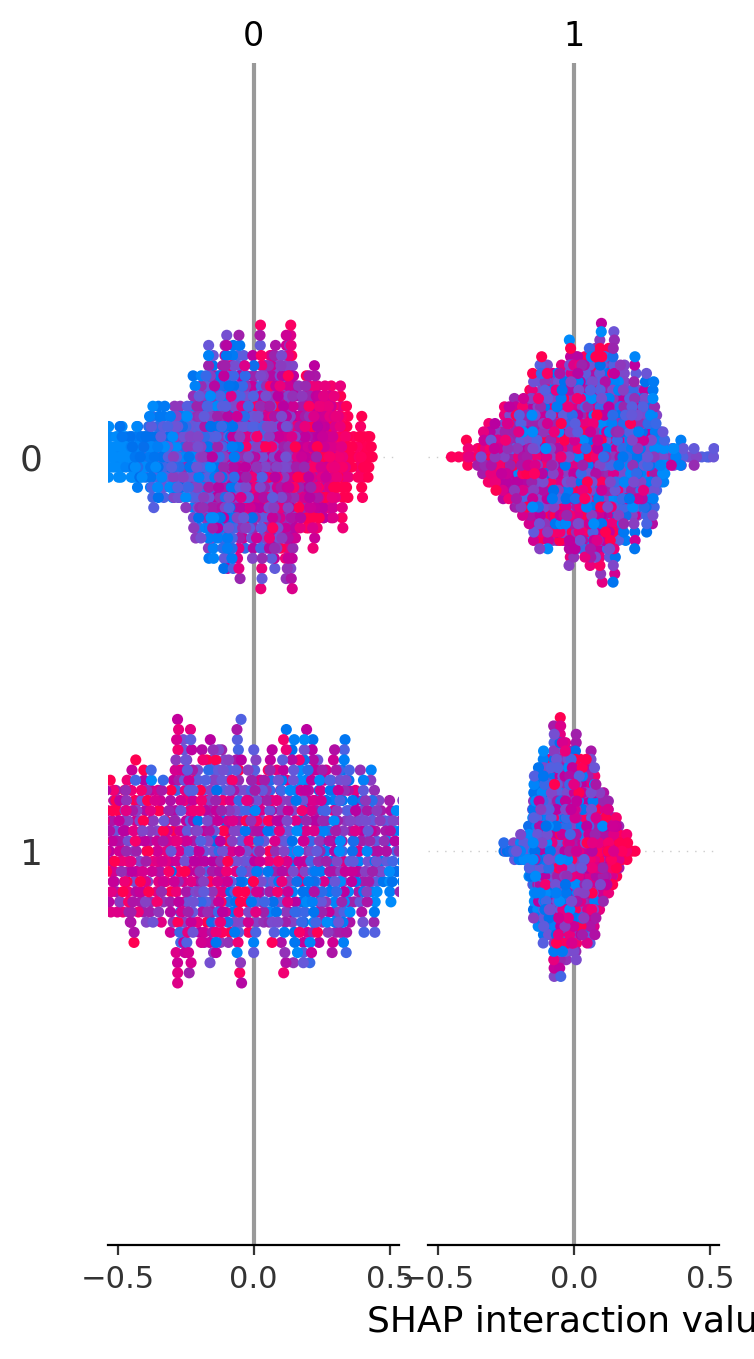

In [29]:
results=[]
for m in get_models():
    print("-"*50,m["name"],"-"*50)
    results.append(classify(df_interval.drop("3",axis=1),0.2,m["model"],m["name"]))

####  2.1.2. *compare results*

In [30]:
compare_model_results(results)

                        Accuracy  Precision  Recall      F1
logistic regression       0.7983     0.7652  0.7243  0.7442
LGBMClassifier            0.7900     0.7495  0.7216  0.7353
basic random forrest      0.7900     0.7680  0.6959  0.7302
CatBoostClassifier        0.7800     0.7500  0.6951  0.7215
Support vector machine    0.7817     0.7628  0.6721  0.7146
XGBClassifier             0.7692     0.6989  0.6943  0.6966
decision tree             0.7283     0.6686  0.6847  0.6766
KNeighborsClassifier      0.7400     0.7673  0.5062  0.6100
AdaBoostClassifier        0.7092     0.7000  0.4907  0.5770
Gaussian Naive Bayes      0.5975     0.5556  0.0309  0.0585


### 2.2 using unrealted features
In this section we will try to create classification based on differnt (not ELO) features

### 2.2.1  Prepeare data

In [14]:
frames=[]
for  sample in pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-players.csv",chunksize=1000):
    frames.append(sample[sample["Year"]==2018])

df_2018=pd.concat(frames)
df_2018

Unnamed: 0 Result  FICSGamesDBGameNo         Player   Elo  \
8913            9602   Lost          455492835       rizaisfa  1540   
9630           10382    Tie          450877124        pietroa   828   
15567          16660    Won          450869119           Calx  1621   
17740          18981   Lost          450866229    DixierRebel  1504   
17756          18997    Won          450866210    DixierRebel  1542   
...              ...    ...                ...            ...   ...   
27723453    14408055    Won          434845469       bretteux  1155   
27723454    14408056    Won          434845468          HWPer  1520   
27723455    14408057   Lost          434845467        Jonfern  1676   
27723456    14408058   Lost          434845465  Jesuslovesall  1423   
27723457    14408059    Won          434845462         anzali  1383   

                Opponent  OpponentElo        Date      Time  Year  Month  Day  \
8913             Eldongo         1558  2018.08.31  07:58:00  2018      8   31   
9630              weaker          973  2018.08.19  13:51:00  2018      8   19   
15567        DixierRebel         1514  2018.11.25  16:53:00  2018     11   25   
17740     henkdedenktenk         1487  2018.11.20  07:52:00  2018     11   20   
17756             WASFOX         1542  2018.11.10  15:59:00  2018     11   10   
...                  ...          ...         ...       ...   ...    ...  ...   
27723453        Arembepe         1059  2018.08.09  12:16:00  2018      8    9   
27723454      JonotheRed         1501  2018.08.09  12:12:00  2018      8    9   
27723455       snackking         1621  2018.08.09  12:13:00  2018      8    9   
27723456            alza         1333  2018.08.09  12:14:00  2018      8    9   
27723457    SorryYouLose         1269  2018.08.09  12:11:00  2018      8    9   

          Hour  Minute  Second  
8913         7      58       0  
9630        13      51       0  
15567       16      53       0  
17740        7      52       0  
17756       15      59       0  
...        ...     ...     ...  
27723453    12      16       0  
27723454    12      12       0  
27723455    12      13       0  
27723456    12      14       0  
27723457    12      11       0  

[11355389 rows x 15 columns]

In [33]:
players=df_interval.index

game_ids=get_game_ids(players,pd.to_datetime([f'{2018}-09-01 00:00:00']).min(),df_2018)
with open(f"{PROJECT_PATH}/data/fics/proccessed/players.pkl", 'wb') as f:
    pickle.dump(players, f)
with open(f"{PROJECT_PATH}/data/fics/proccessed/game_ids.pkl", 'wb') as f:
    pickle.dump(game_ids, f)

In [15]:
with open(f"{PROJECT_PATH}/data/fics/proccessed/game_ids.pkl", 'rb') as f:
    game_ids=pickle.load( f)

In [16]:
with open(f"{PROJECT_PATH}/data/fics/proccessed/players.pkl", 'rb') as f:
    players=pickle.load( f)

In [18]:

frames=[]
for  sample in pd.read_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-details.csv",chunksize=1000000):
    sample=sample[sample["FICSGamesDBGameNo"].isin(game_ids)]
    sample=sample=sample[(sample["White"].isin(players))|sample["Black"].isin(players)]
    sample=sample.drop(columns=["Unnamed: 0.1","Unnamed: 0"])
    frames.append(sample)

extra_df=pd.concat(frames)

In [19]:
extra_df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean-blitz-rated-vfinal-details-clean-2018.csv")

In [25]:
parsed_details=get_extra_details_features(players,extra_df)
parsed_details["Label"]=df_interval["Label"]

100%|██████████| 5999/5999 [1:30:28<00:00,  1.11it/s]


In [26]:
with open(f"{PROJECT_PATH}/data/fics/proccessed/parsed_details.pkl", 'wb') as f:
    pickle.dump(parsed_details, f)

### 2.2.2  Run classification models

In [36]:
# some columns didnt result in succesfull features so we drop them
parsed_details=parsed_details.drop(columns=["EloDiff_1/3_time_mean","EloDiff_2/3_time_mean","EloDiff_3/3_time_mean"])
parsed_details=parsed_details.drop(columns="EloDiff_1/3_mean")

-------------------------------------------------- decision tree --------------------------------------------------
Model name: decision tree
accuracy_score: 0.52
roc_auc_score: 0.5050691244239631
precision_score: 0.3930635838150289
f1_score: 0.4146341463414634


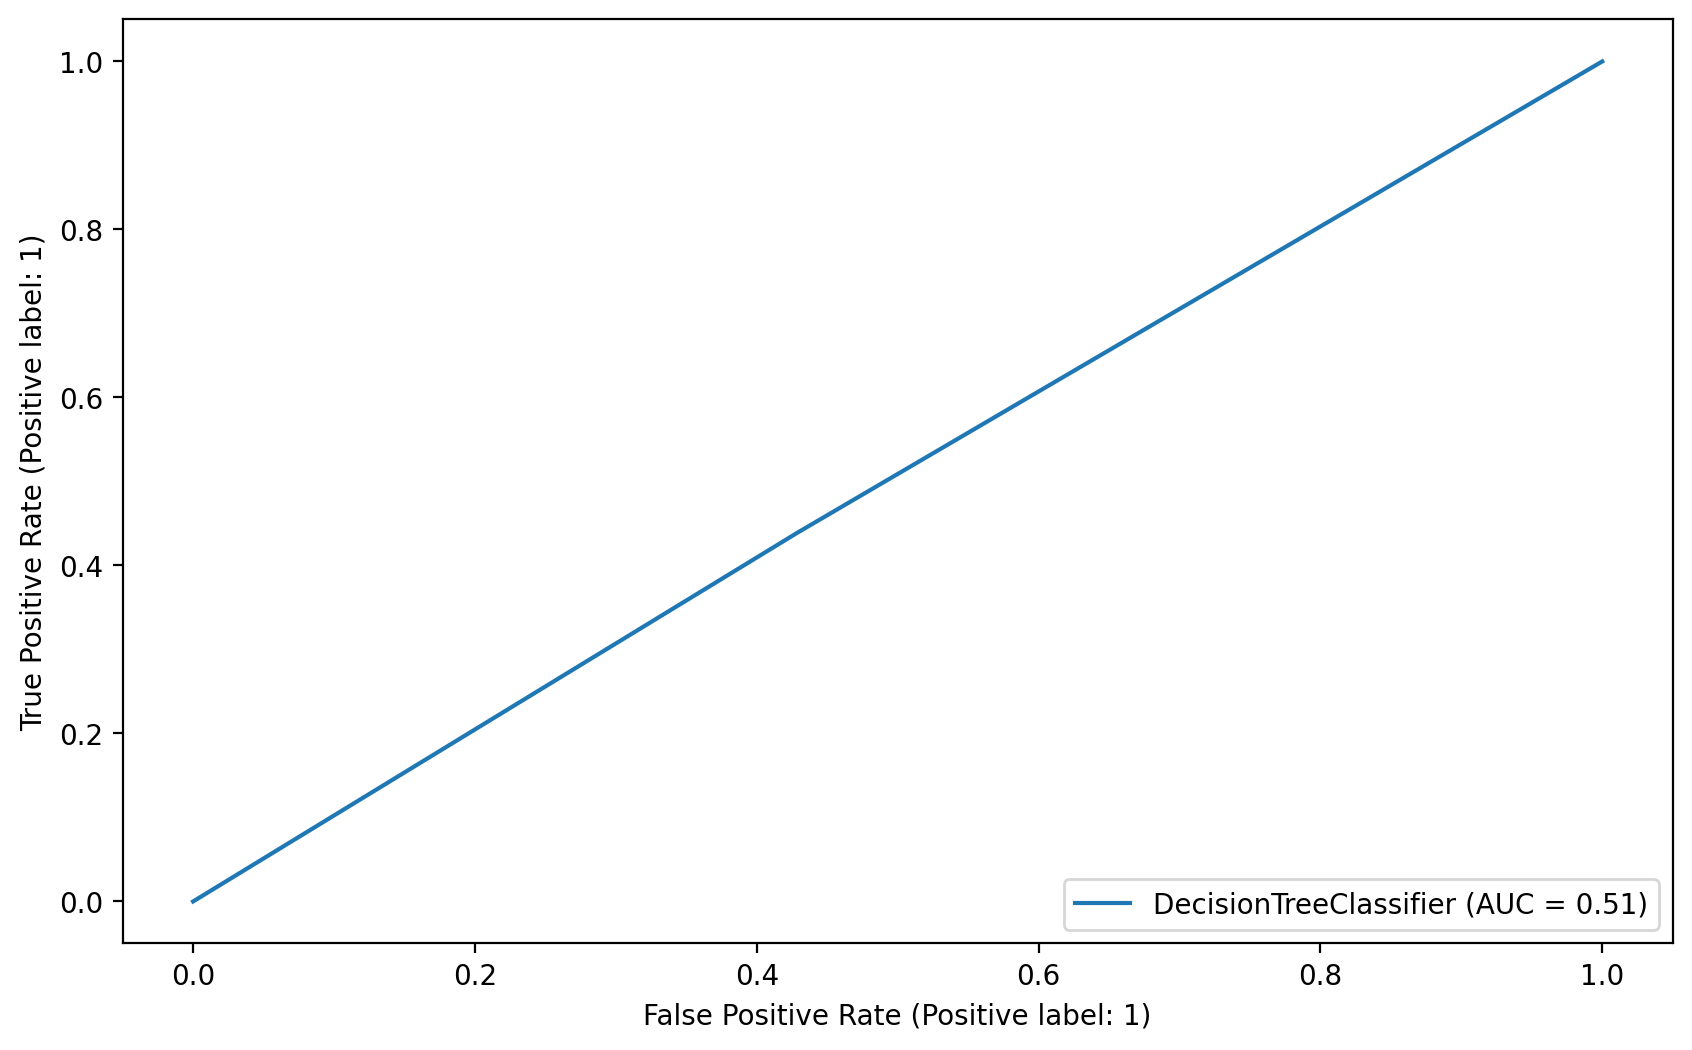

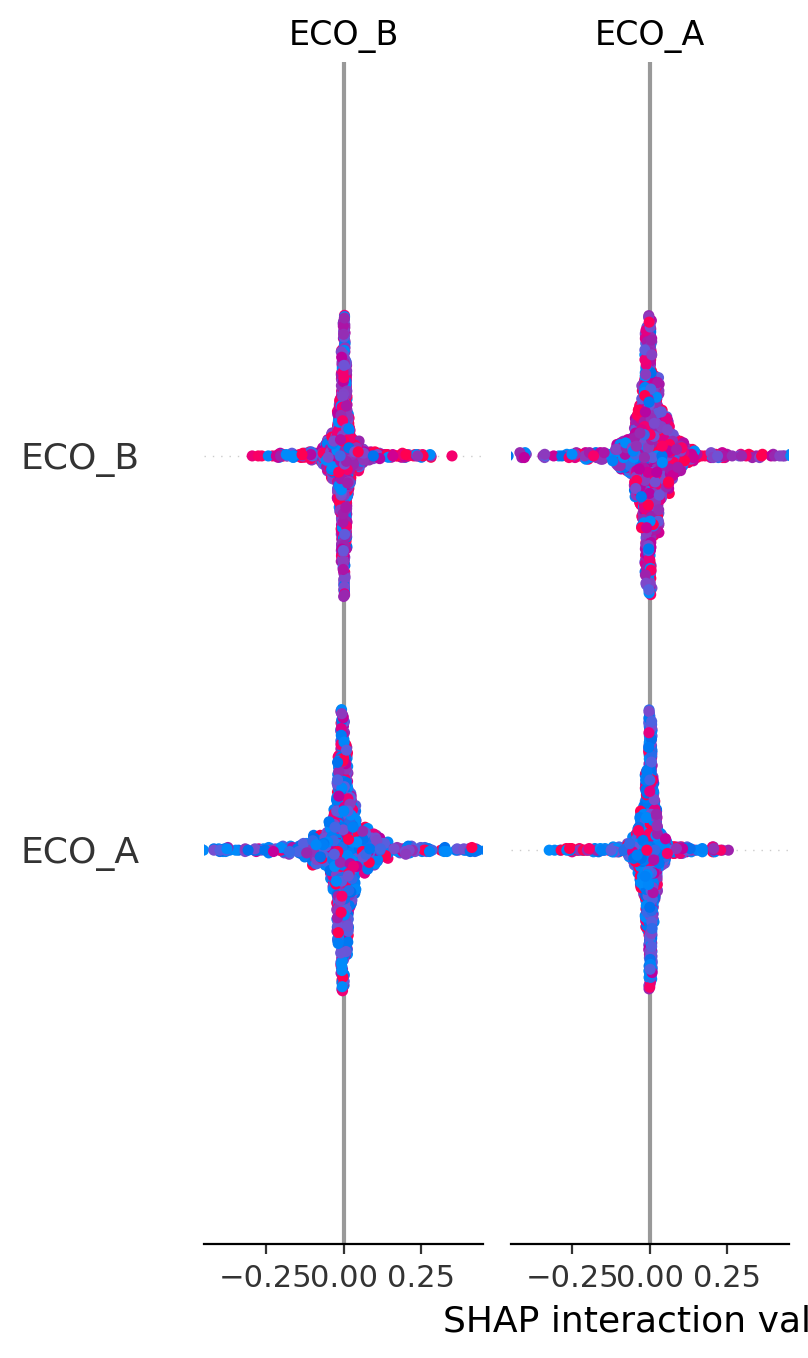

-------------------------------------------------- Gaussian Naive Bayes --------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.5491666666666667
roc_auc_score: 0.503607714439849
precision_score: 0.47126436781609193
f1_score: 0.13162118780096307


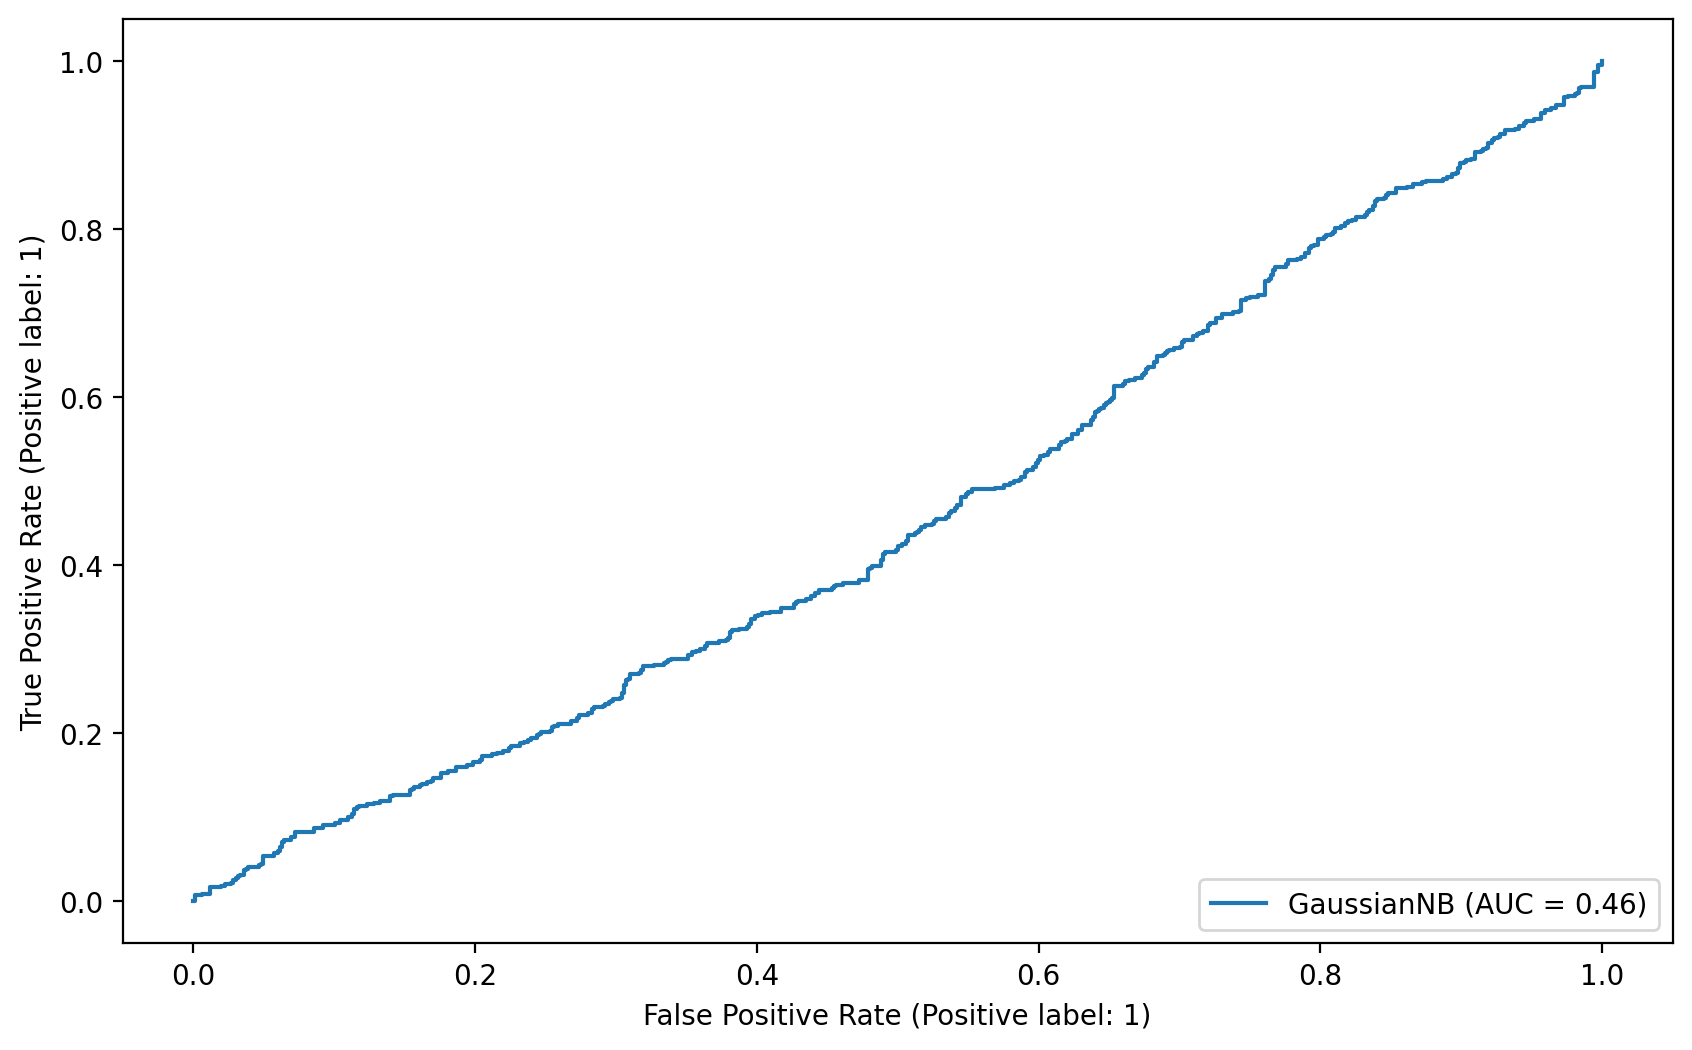

-------------------------------------------------- KNeighborsClassifier --------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.5675
roc_auc_score: 0.5135121296254153
precision_score: 0.4685714285714286
f1_score: 0.24011713030746704


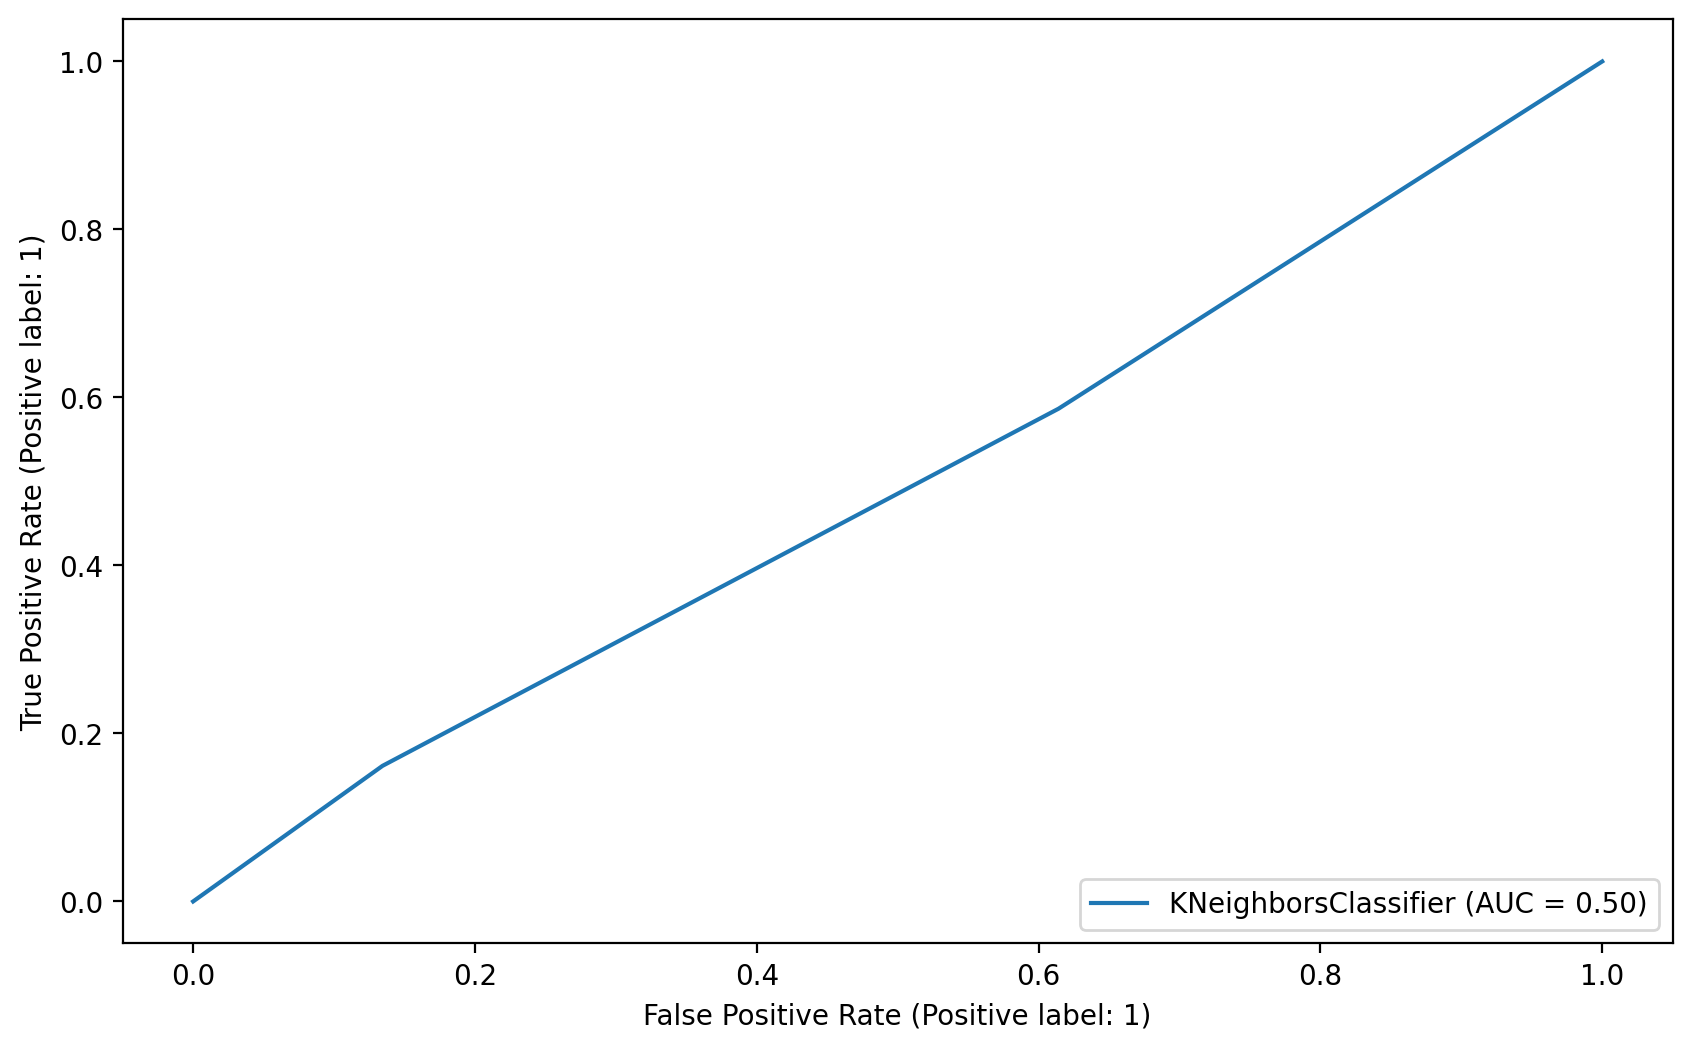

-------------------------------------------------- AdaBoostClassifier --------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.6016666666666667
roc_auc_score: 0.5145478359509303
precision_score: 0.453125
f1_score: 0.19528619528619529


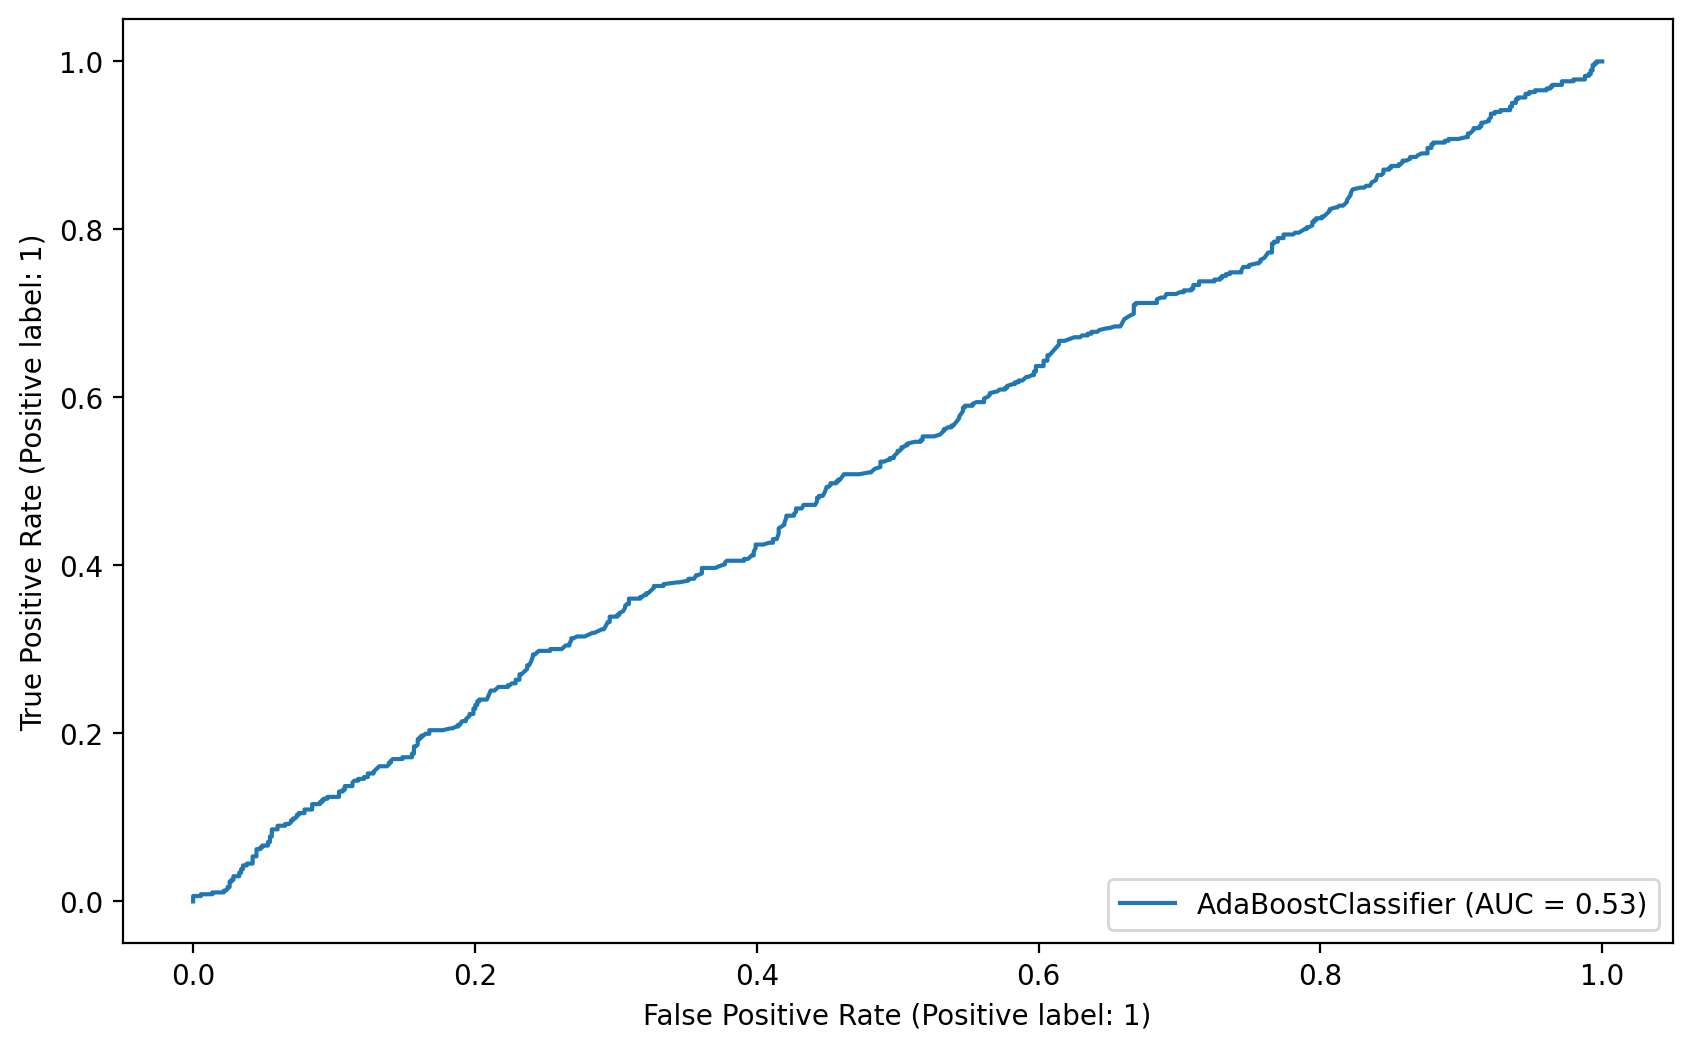

-------------------------------------------------- CatBoostClassifier --------------------------------------------------
Learning rate set to 0.020127
0:	learn: 0.6923250	total: 57.3ms	remaining: 57.3s
1:	learn: 0.6913533	total: 59.2ms	remaining: 29.5s
2:	learn: 0.6904604	total: 60.5ms	remaining: 20.1s
3:	learn: 0.6894899	total: 61.9ms	remaining: 15.4s
4:	learn: 0.6886920	total: 63.2ms	remaining: 12.6s
5:	learn: 0.6878936	total: 64.4ms	remaining: 10.7s
6:	learn: 0.6869058	total: 65.7ms	remaining: 9.31s
7:	learn: 0.6861576	total: 66.9ms	remaining: 8.29s
8:	learn: 0.6854383	total: 68ms	remaining: 7.49s
9:	learn: 0.6846570	total: 69.2ms	remaining: 6.86s
10:	learn: 0.6841169	total: 70.4ms	remaining: 6.33s
11:	learn: 0.6833642	total: 71.6ms	remaining: 5.89s
12:	learn: 0.6827226	total: 72.8ms	remaining: 5.53s
13:	learn: 0.6821174	total: 74.1ms	remaining: 5.22s
14:	learn: 0.6815520	total: 75.4ms	remaining: 4.95s
15:	learn: 0.6808583	total: 76.9ms	remaining: 4.73s
16:	learn: 0.6803378	total: 7

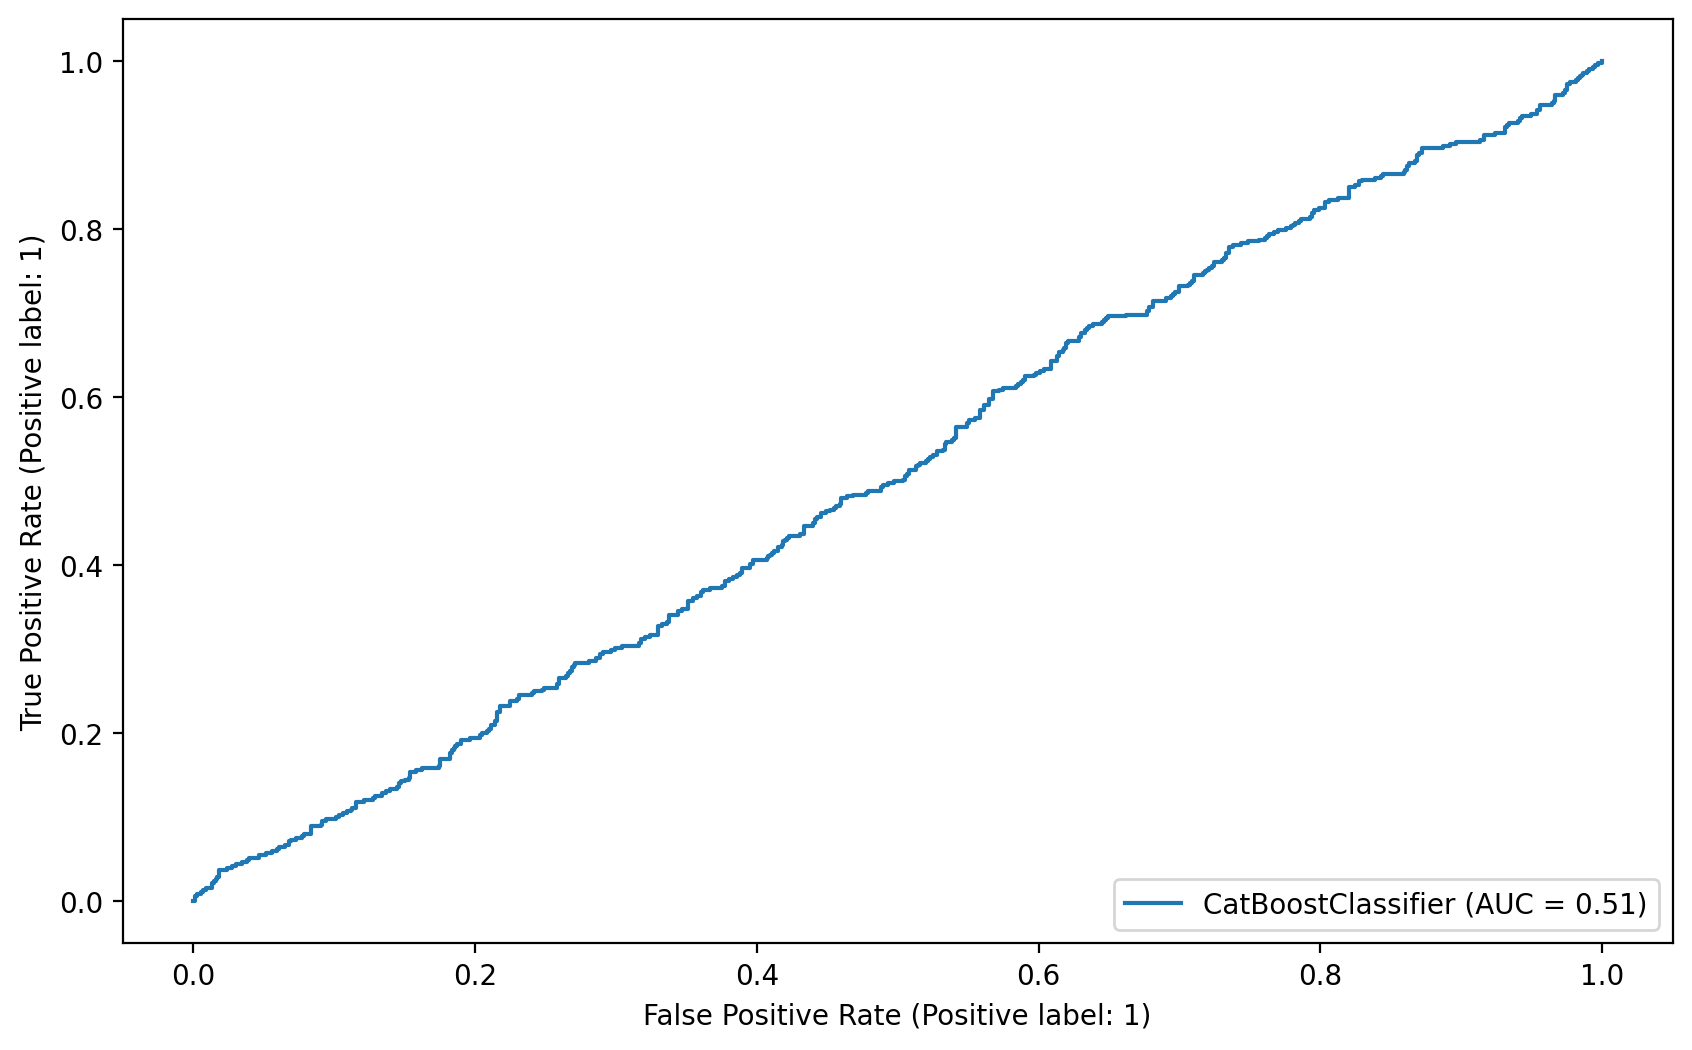

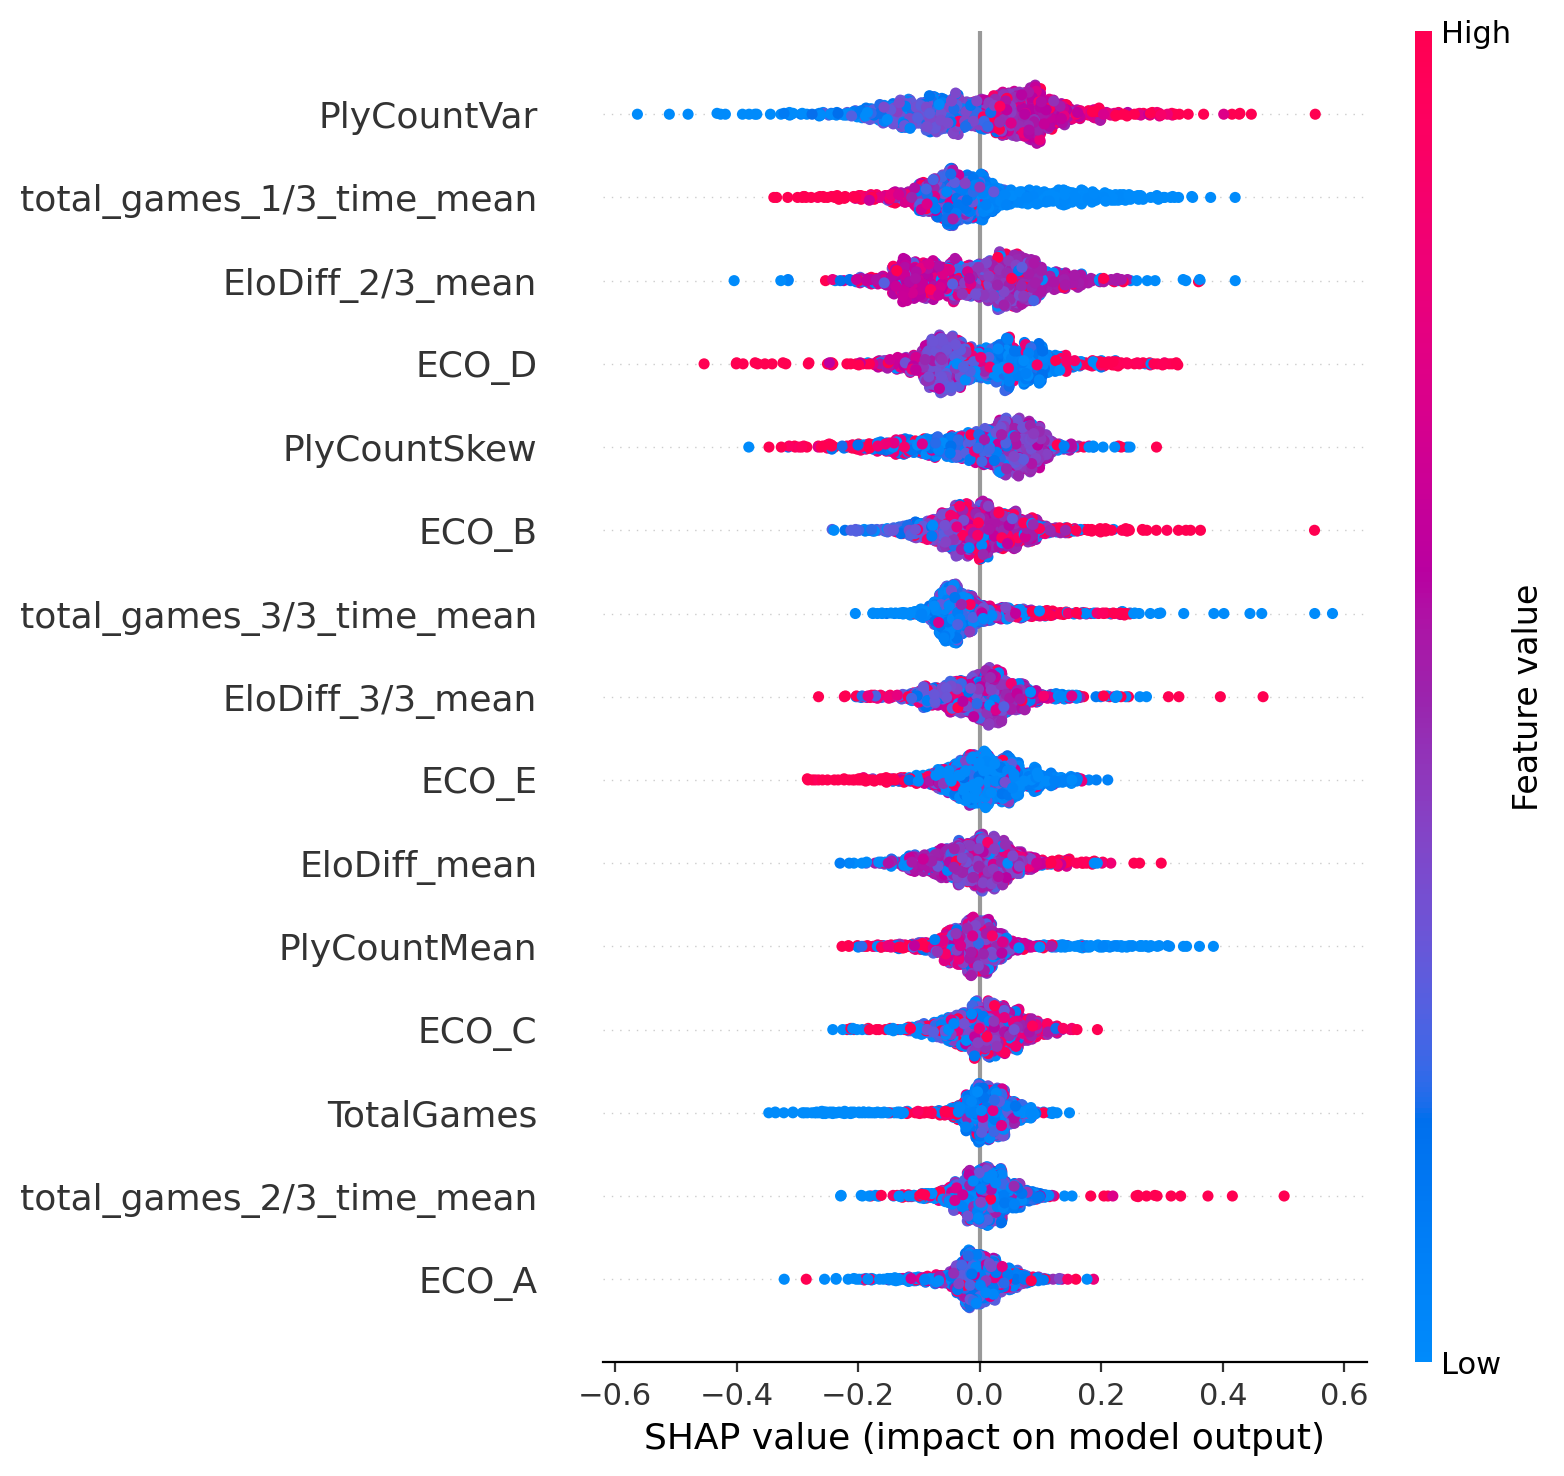

-------------------------------------------------- XGBClassifier --------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.5625
roc_auc_score: 0.5207125964811975
precision_score: 0.4378698224852071
f1_score: 0.36053593179049936


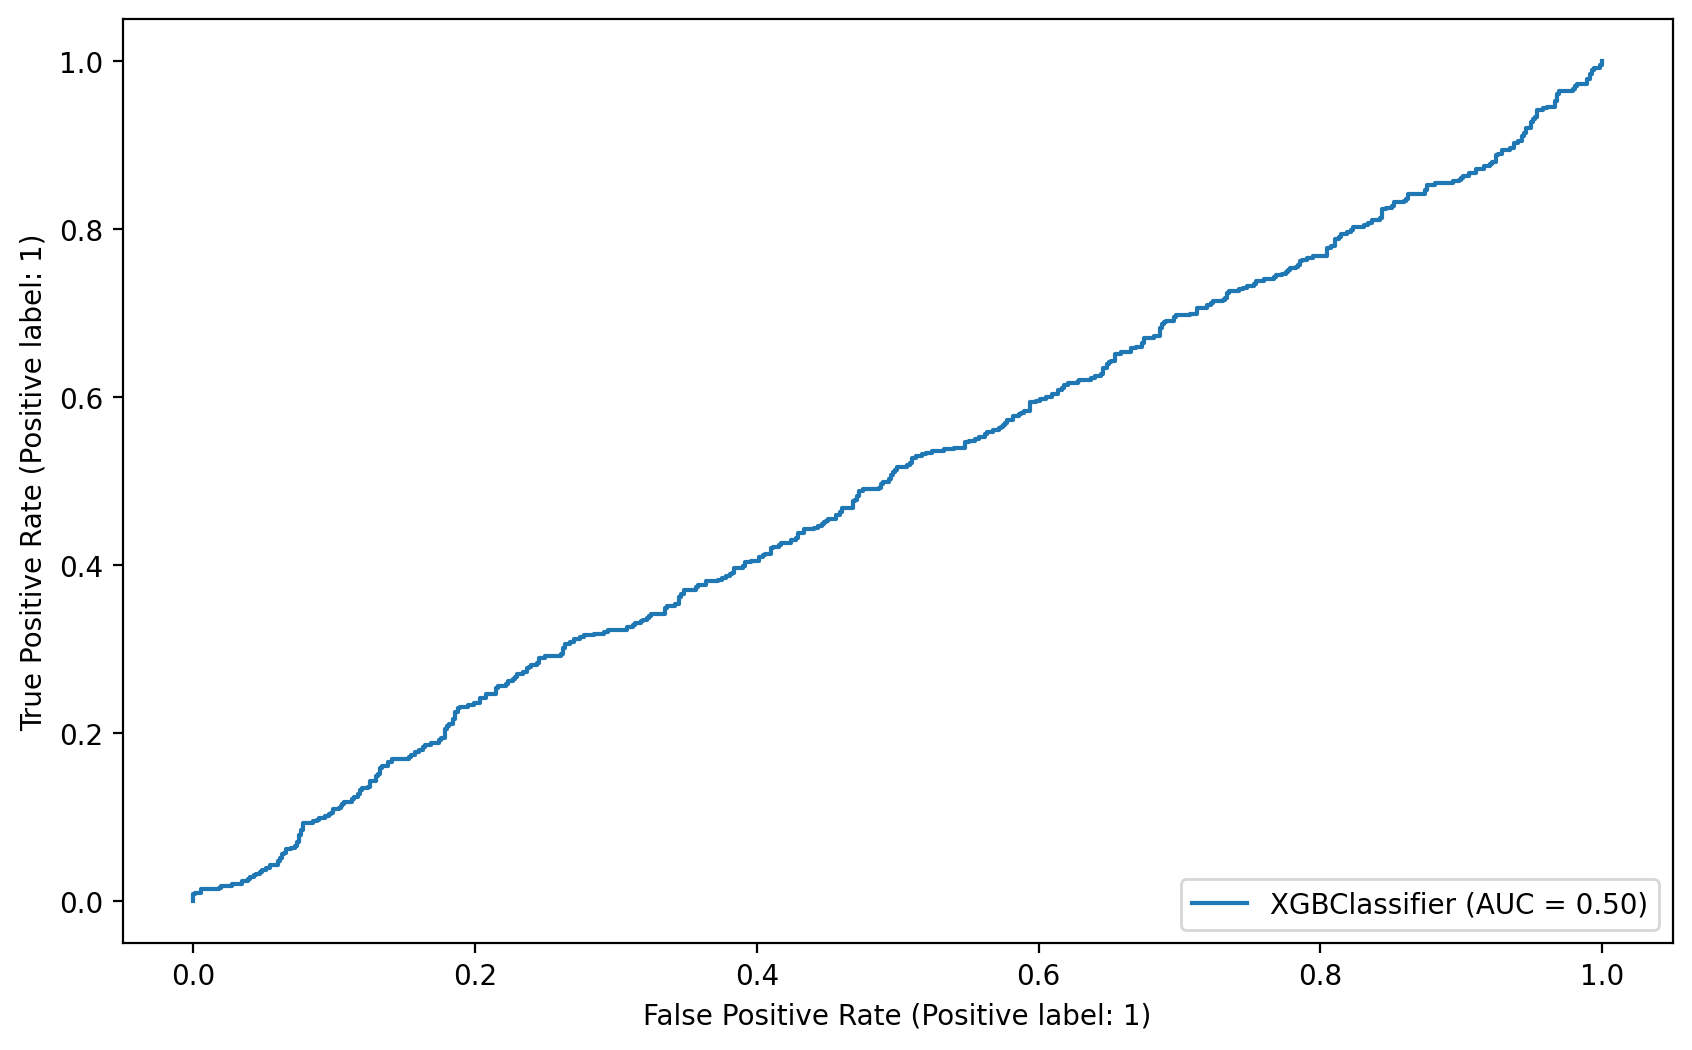

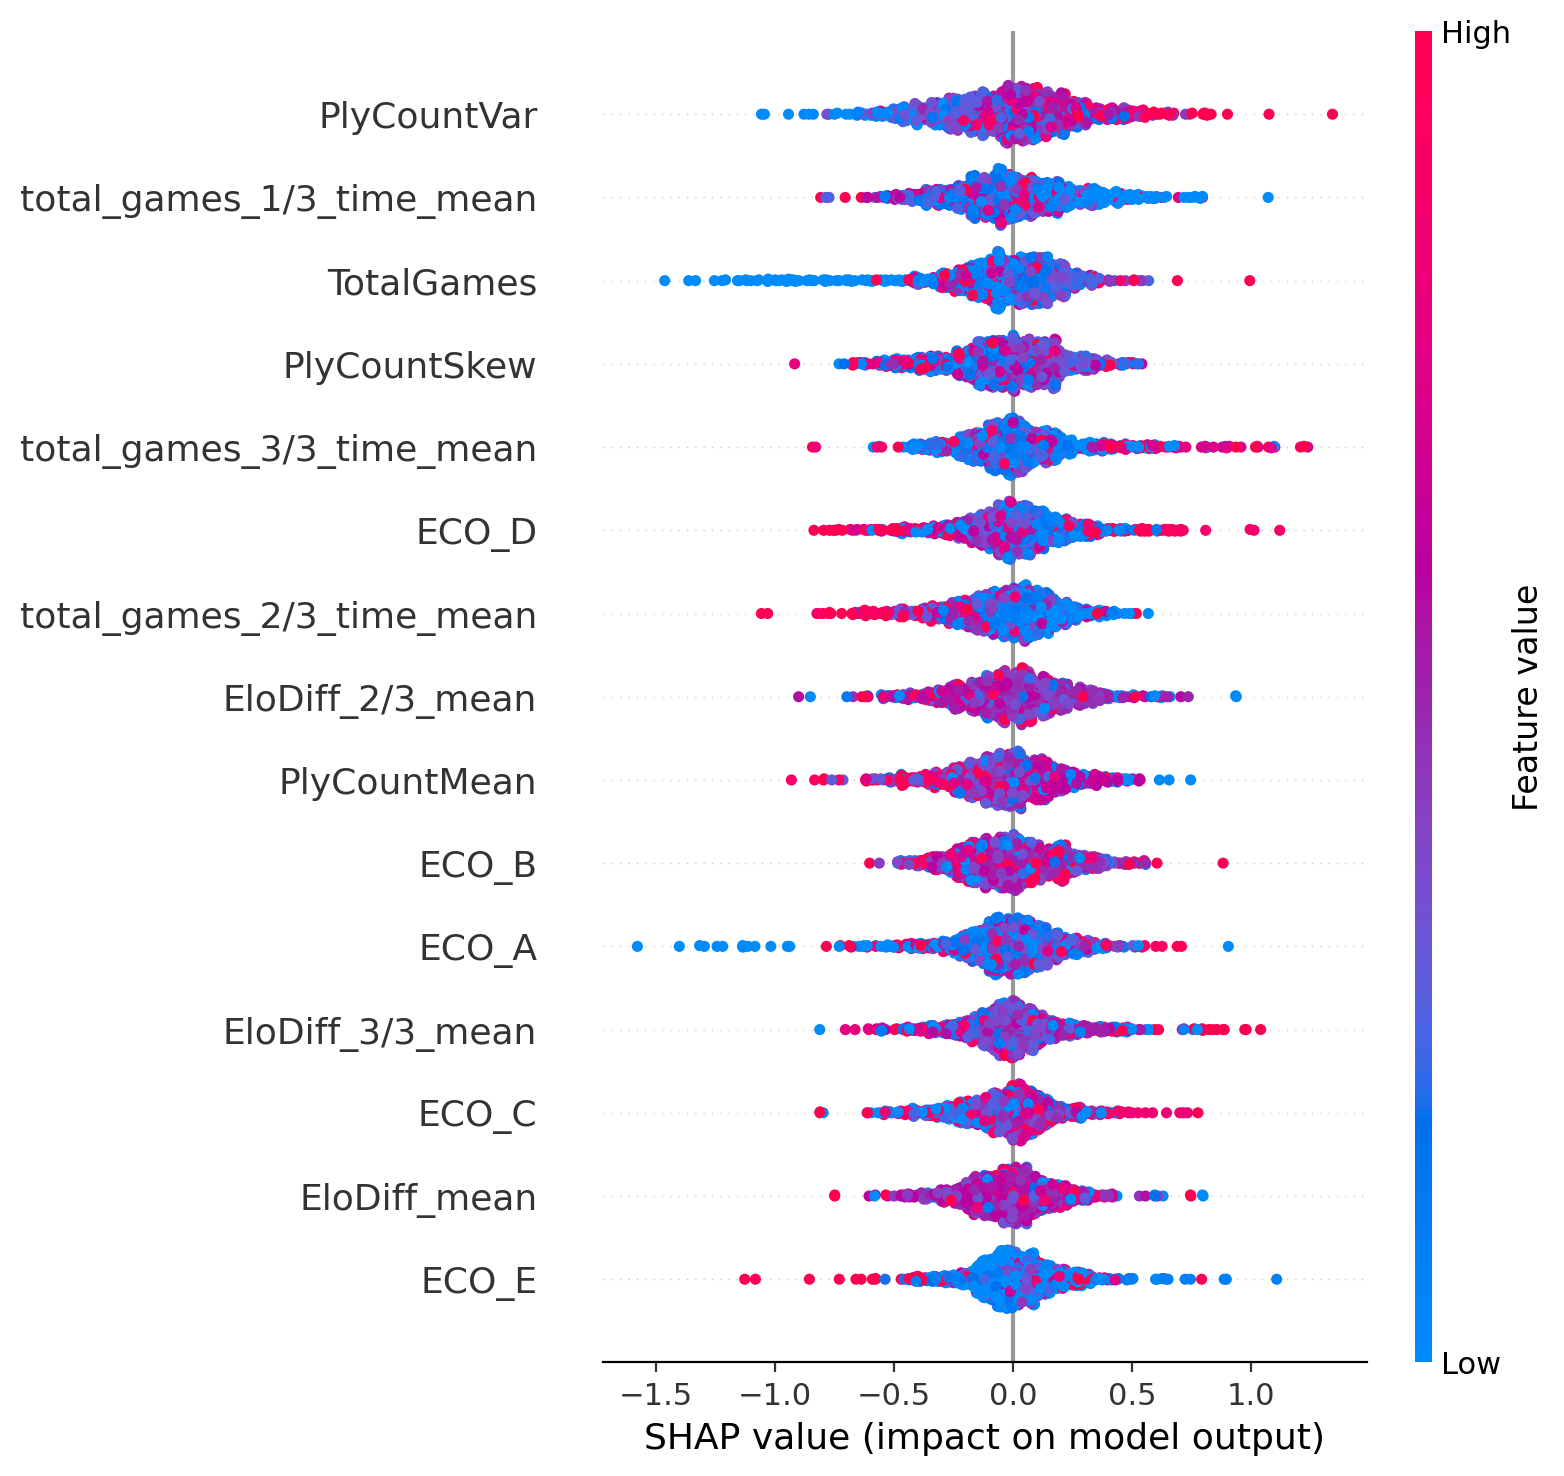

-------------------------------------------------- LGBMClassifier --------------------------------------------------
[LightGBM] [Info] Number of positive: 1916, number of negative: 2883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399250 -> initscore=-0.408592
[LightGBM] [Info] Start training from score -0.408592
Model name: LGBMClassifier
accuracy_score: 0.5358333333333334
roc_auc_score: 0.48490561722589265
precision_score: 0.37916666666666665
f1_score: 0.24627875507442487


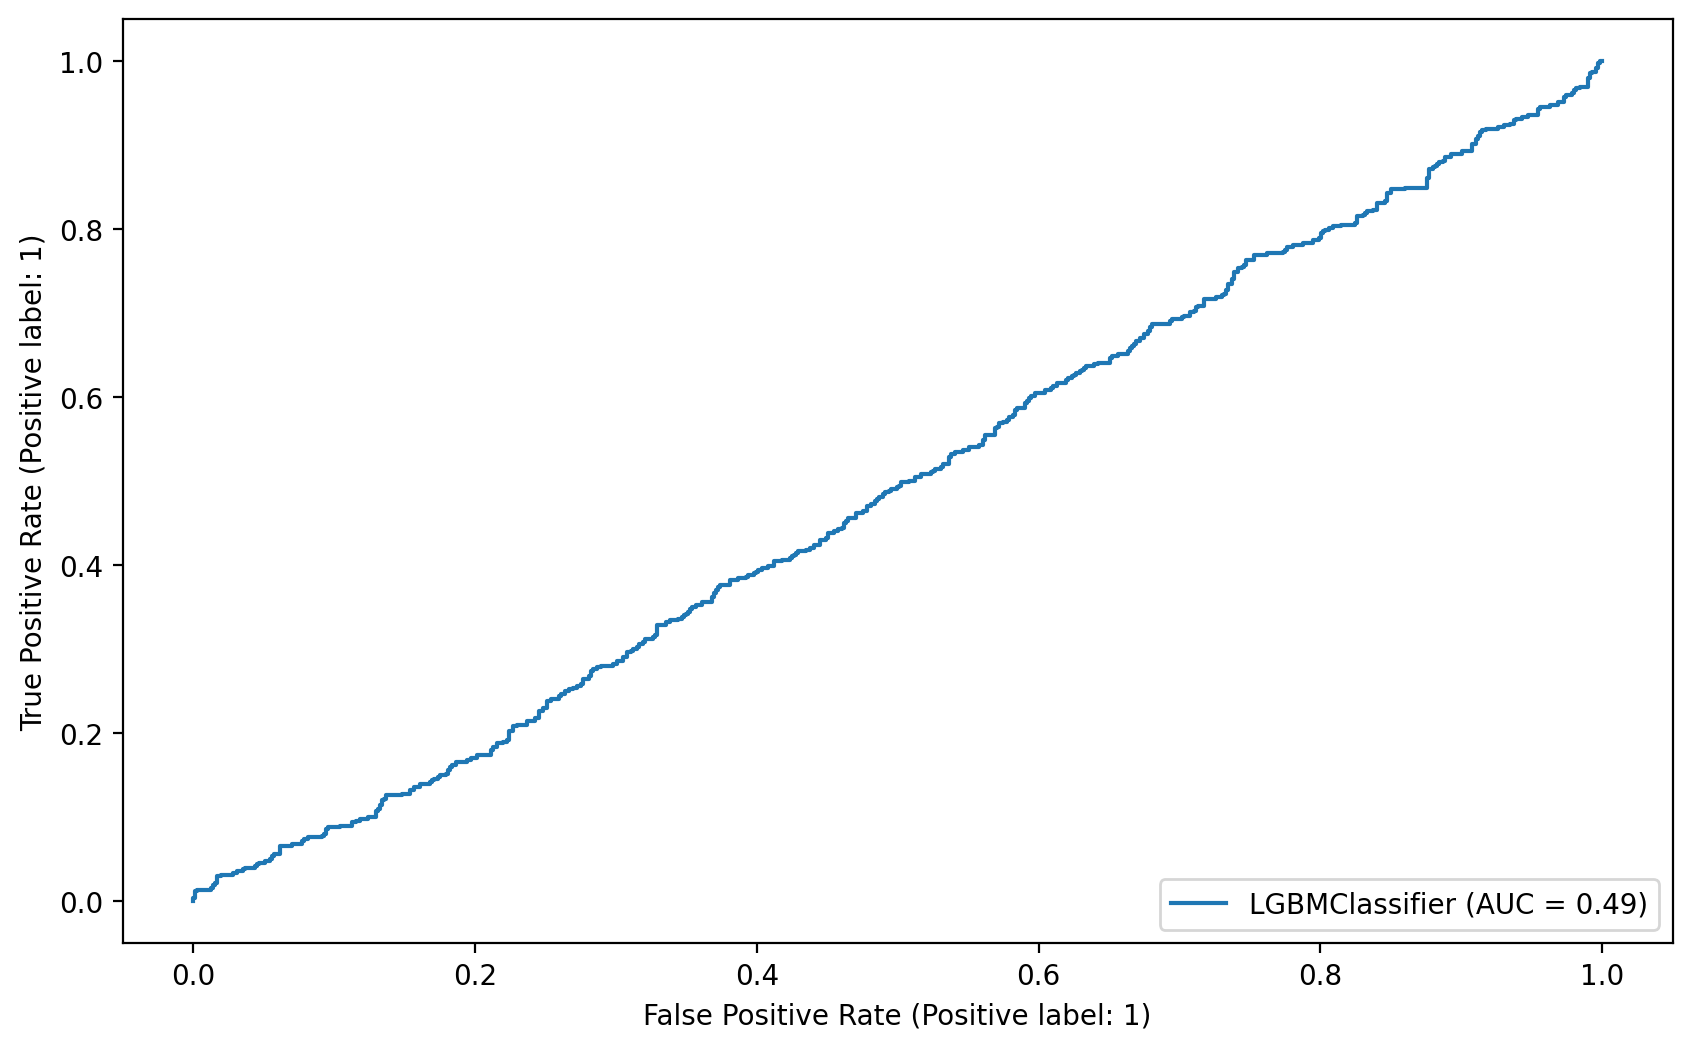

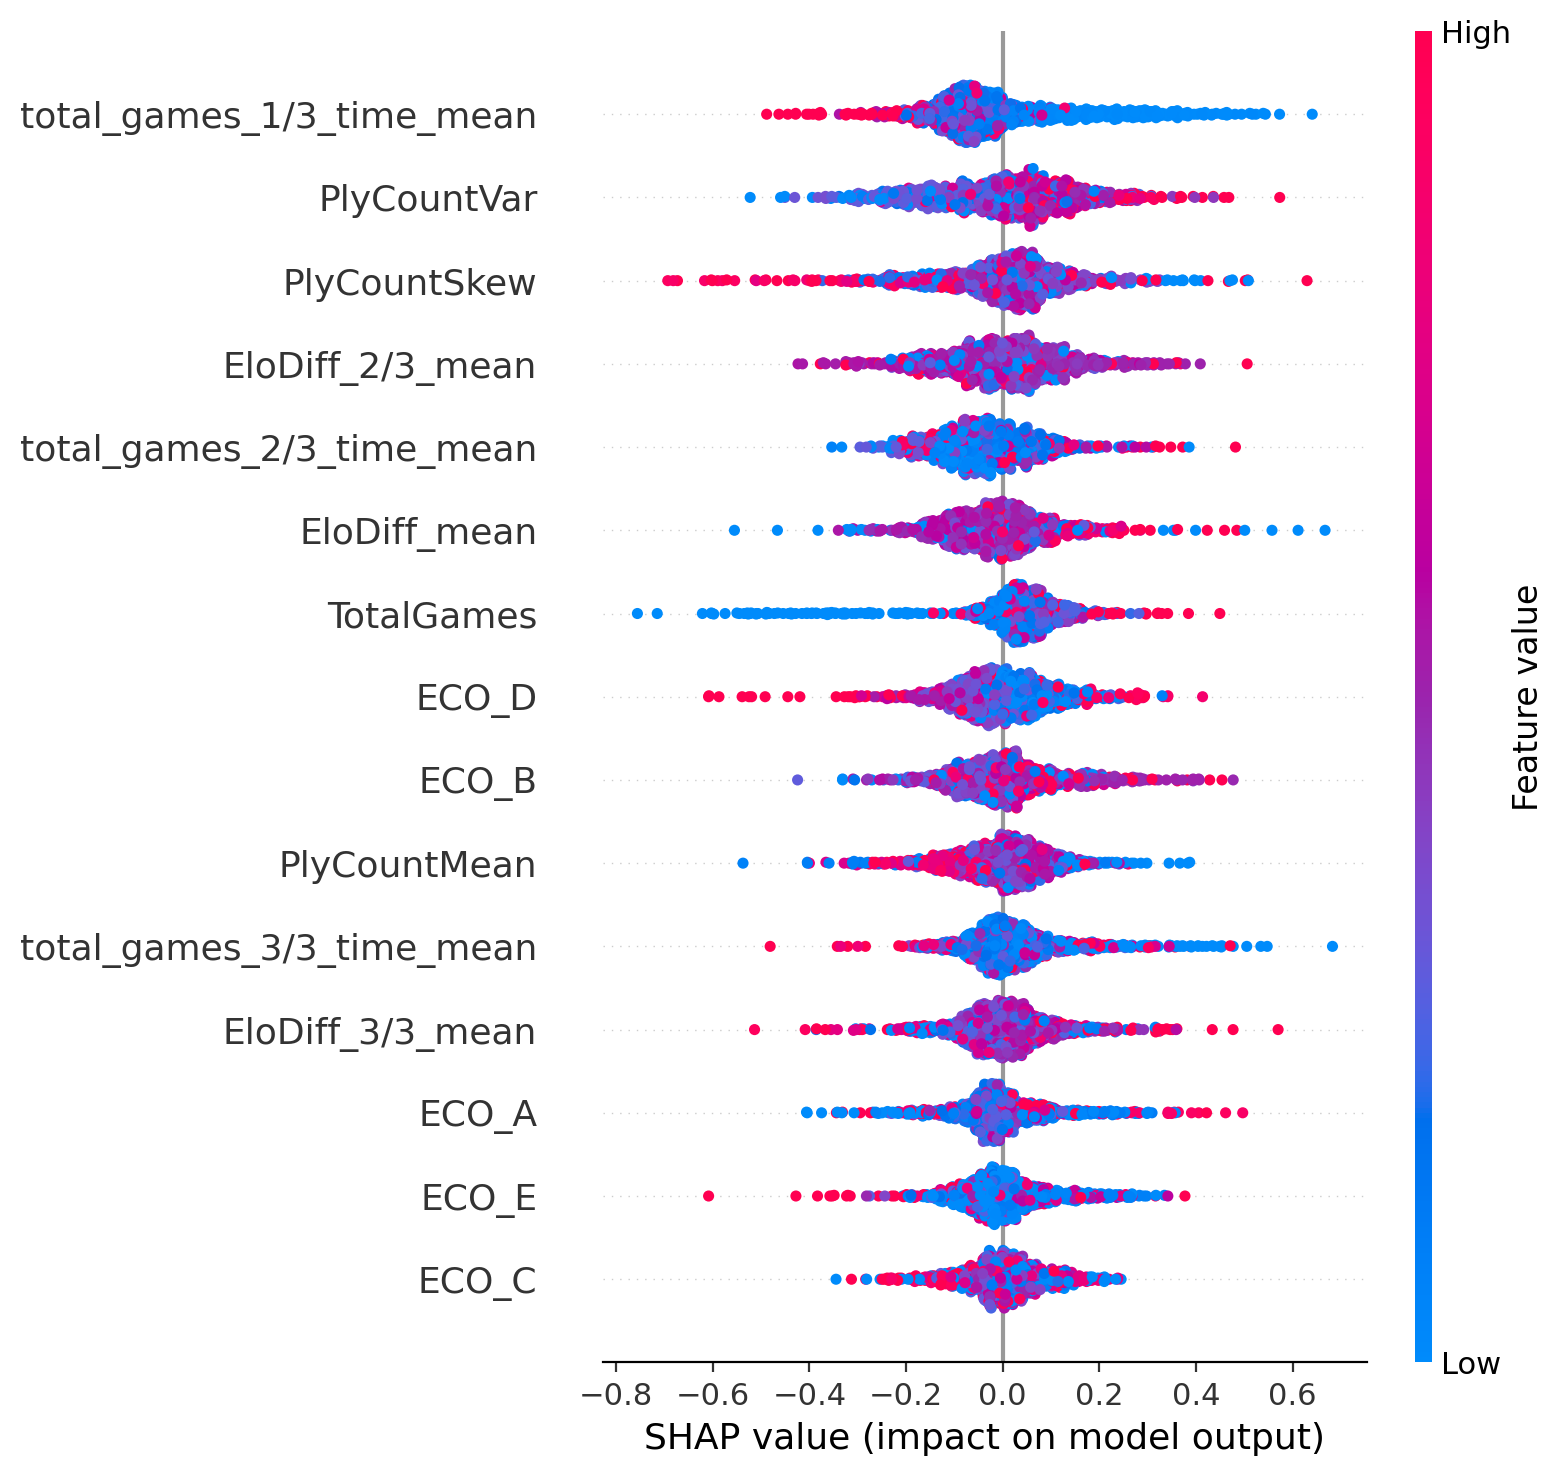

-------------------------------------------------- logistic regression --------------------------------------------------
Model name: logistic regression
accuracy_score: 0.6016666666666667
roc_auc_score: 0.5007070086579585
precision_score: 0.5
f1_score: 0.008298755186721992


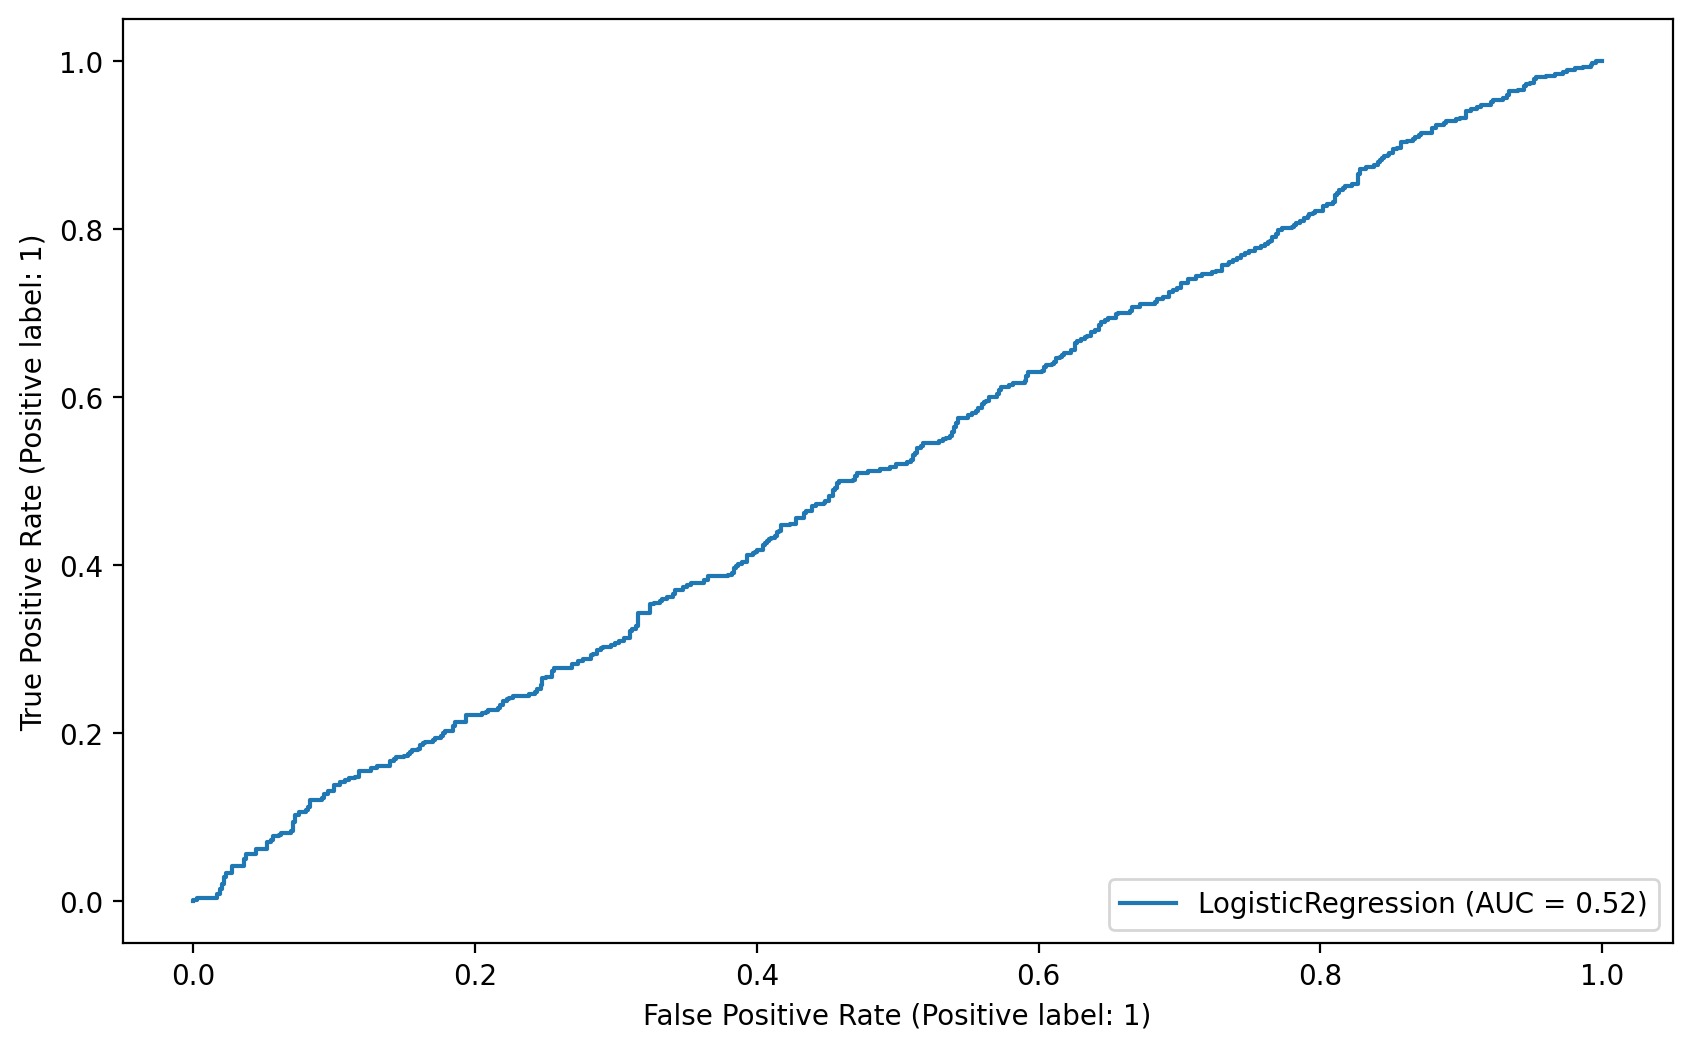

-------------------------------------------------- Support vector machine --------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.58
roc_auc_score: 0.49714285714285716
precision_score: 0.0
f1_score: 0.0


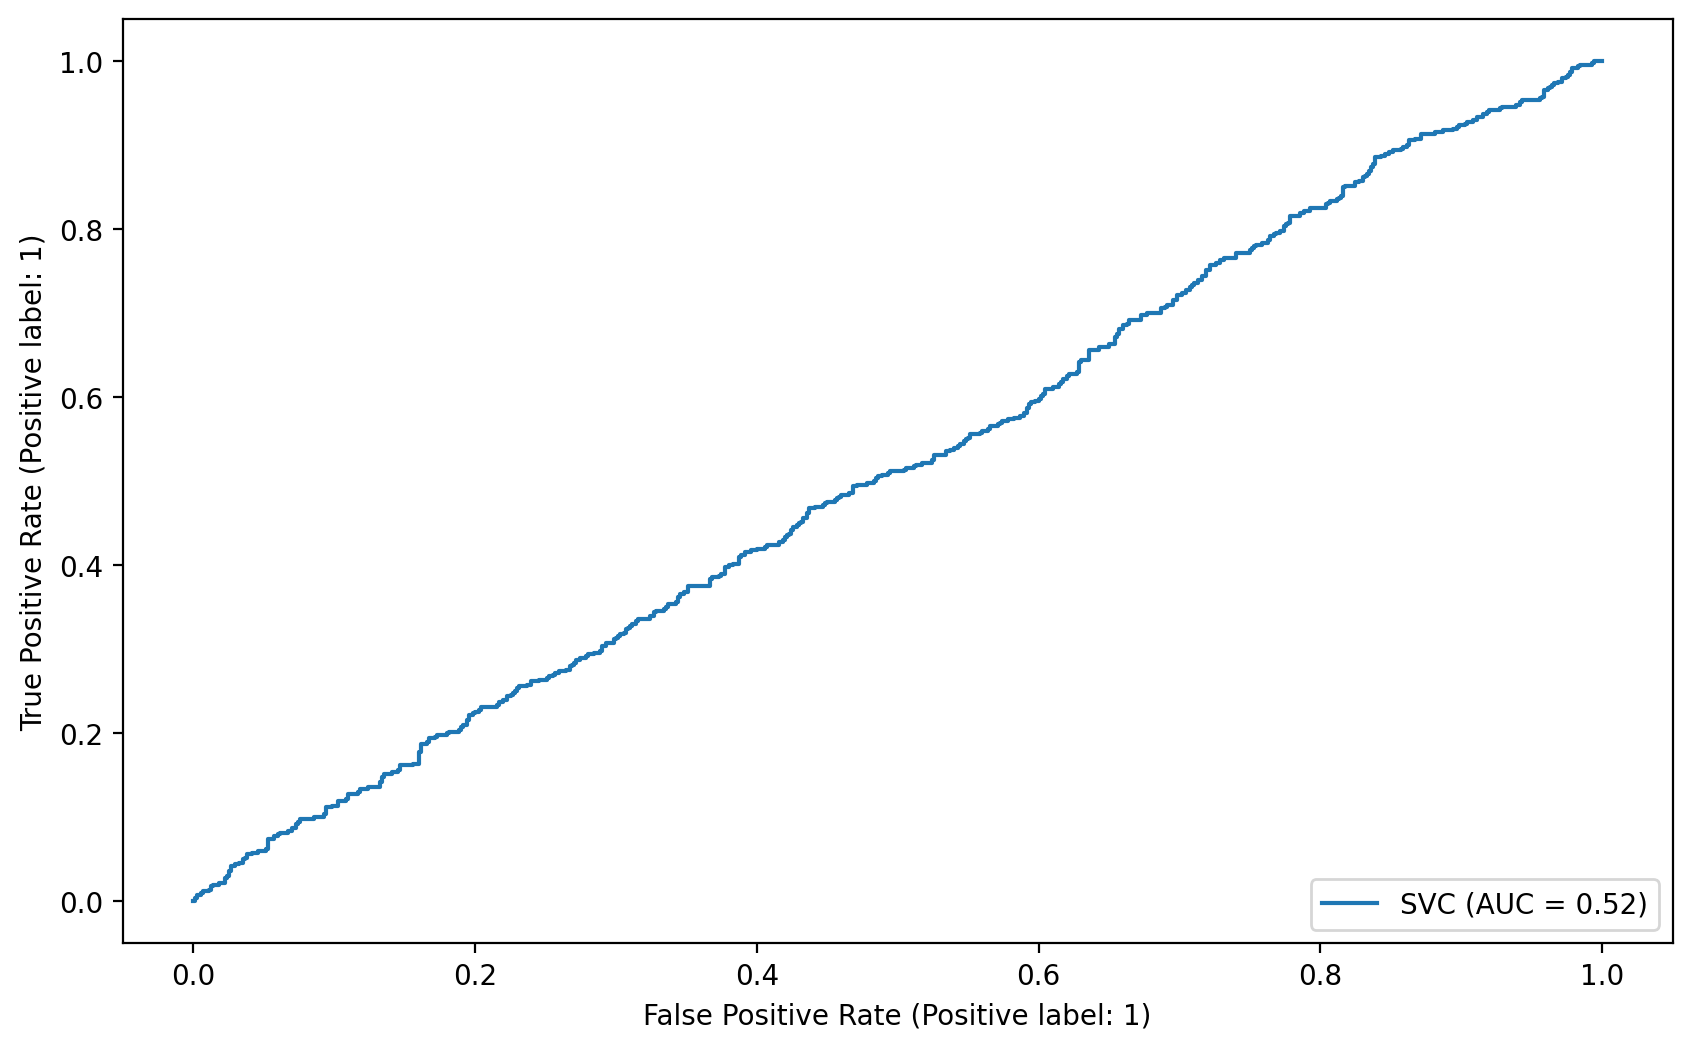

-------------------------------------------------- basic random forrest --------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.575
roc_auc_score: 0.5099436868484132
precision_score: 0.44871794871794873
f1_score: 0.21538461538461537


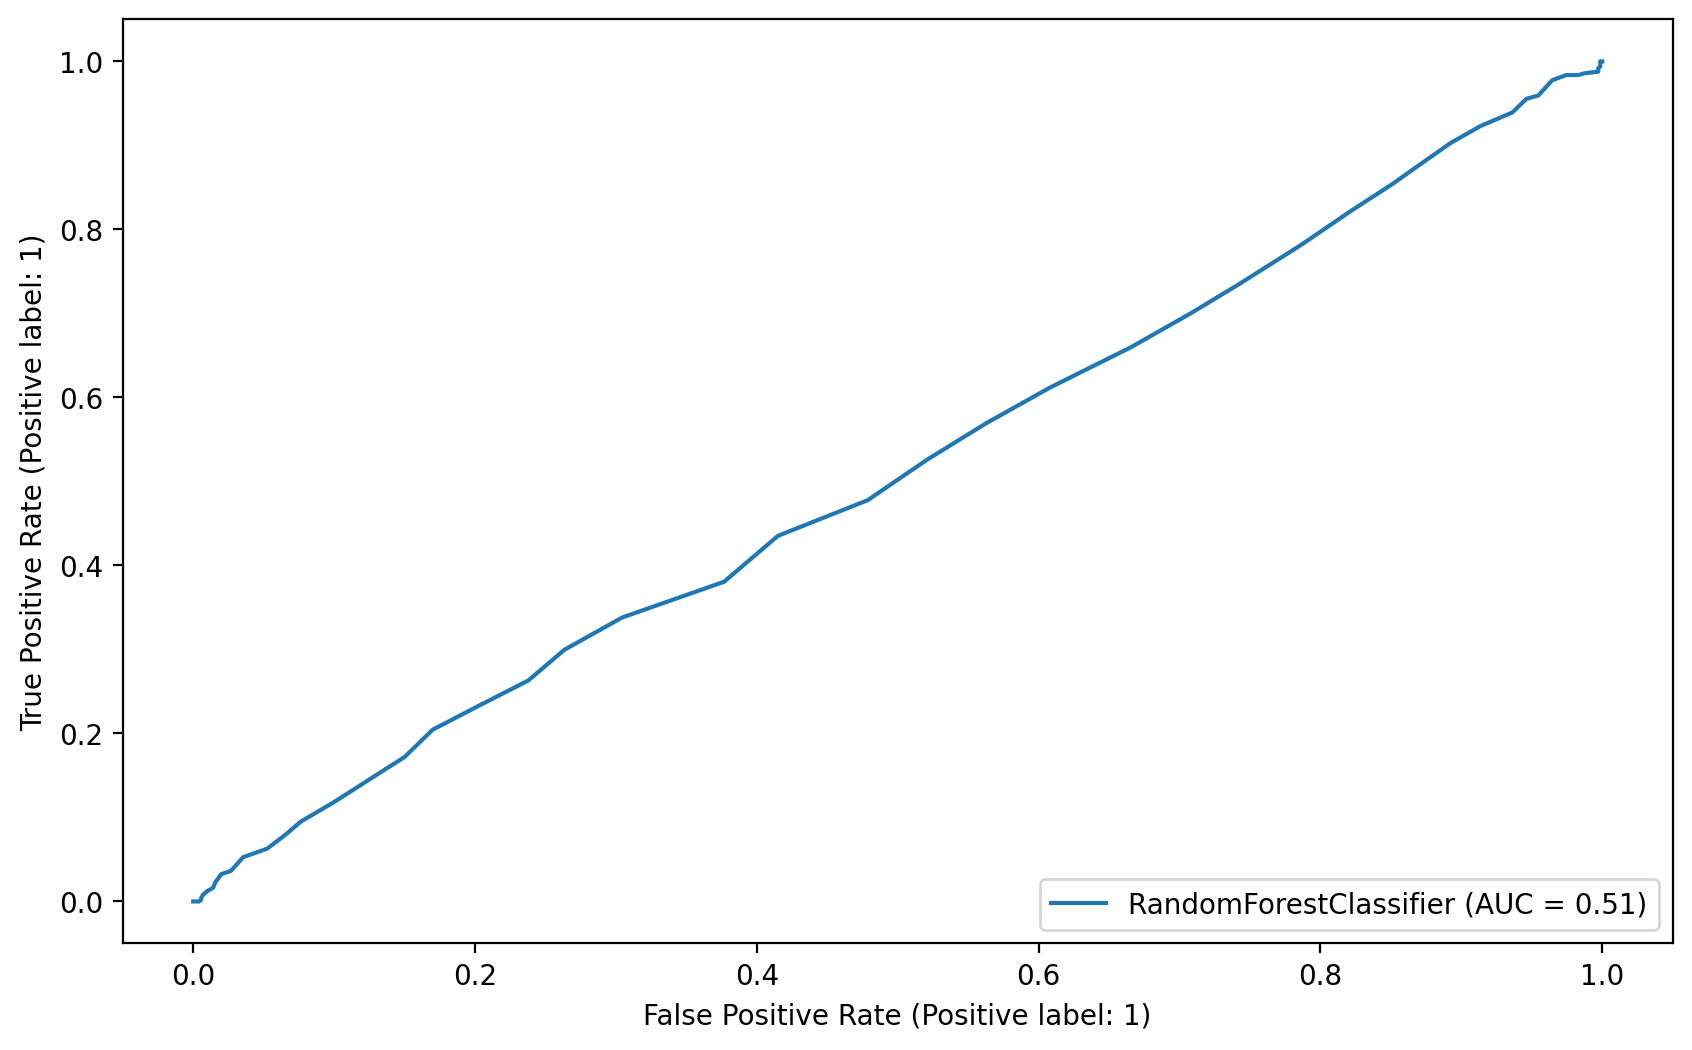

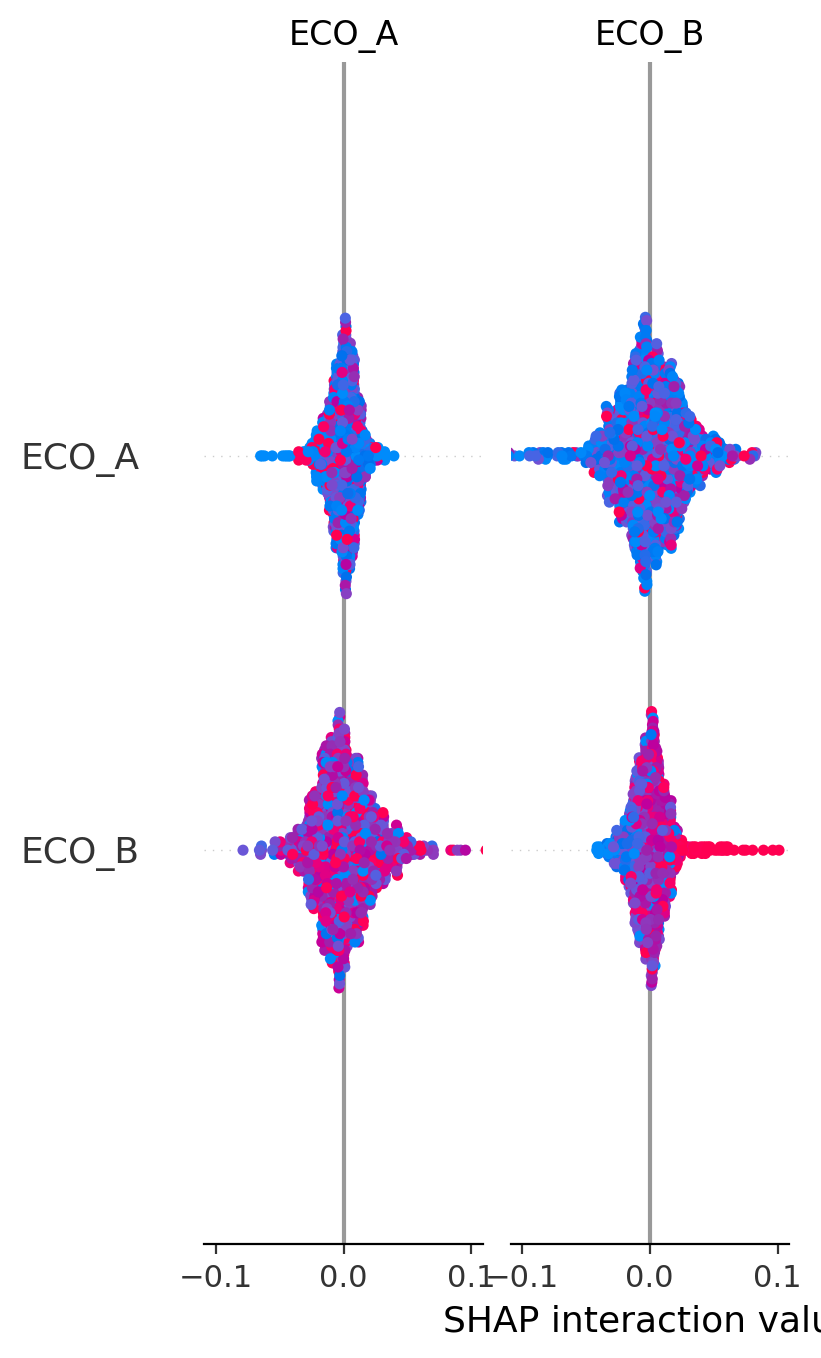

In [47]:
results=[]
for m in get_models():
    print("-"*50,m["name"],"-"*50)
    results.append(classify(parsed_details,0.2,m["model"],m["name"]))

### 2.2.3  Compare results

In [48]:
compare_model_results(results)

                        Accuracy  Precision  Recall      F1
decision tree             0.5200     0.3931  0.4387  0.4146
XGBClassifier             0.5625     0.4379  0.3064  0.3605
LGBMClassifier            0.5358     0.3792  0.1824  0.2463
KNeighborsClassifier      0.5675     0.4686  0.1614  0.2401
basic random forrest      0.5750     0.4487  0.1417  0.2154
CatBoostClassifier        0.5858     0.3646  0.1473  0.2099
AdaBoostClassifier        0.6017     0.4531  0.1245  0.1953
Gaussian Naive Bayes      0.5492     0.4713  0.0765  0.1316
logistic regression       0.6017     0.5000  0.0042  0.0083
Support vector machine    0.5800     0.0000  0.0000  0.0000


### 2.3 using game trends features

In this section we will try to predict game results using trend related features

### 2.3.1  Load data

In [52]:
players=df_interval.index
df=get_features_per_player(players,pd.to_datetime([f'{2018}-09-01 00:00:00']).min(),df_2018,extra_df)
df.index=list(df["Player"])
df=df.drop(columns="Player")
df["Label"]=choose_positive(label_trend(df_interval["Label"]))
df

mean          var  kurtosis      skew   min   max  Label
ABCi         1463.333333   739.022222 -0.428960 -0.428960  1406  1502      0
ABSBEGINNER  1344.142276  1451.811736 -0.302494 -0.302494  1241  1426      0
ADJUSTOR     1878.373218  1864.929391 -0.363291 -0.363291  1745  1994      0
AFCERGY      1571.542036  1115.665047 -0.014246 -0.014246  1461  1677      0
AFRF         1364.376000  1022.746624 -0.244517 -0.244517  1278  1456      0
...                  ...          ...       ...       ...   ...   ...    ...
zwartspeler  1821.970471  1499.353478  0.477892  0.477892  1724  1925      0
zwirek        985.571429   452.530612 -0.211077 -0.211077   951  1016      0
zxtxf        1332.290323  1331.109261 -0.369068 -0.369068  1252  1408      0
zyrq         1478.447326  2225.900386  0.052584  0.052584  1373  1590      0
zzyxx        1497.287770  1376.881217  0.554133  0.554133  1418  1597      0

[5999 rows x 7 columns]

In [53]:
df["Label"]=df_interval["Label"]
df

mean          var  kurtosis      skew   min   max  Label
ABCi         1463.333333   739.022222 -0.428960 -0.428960  1406  1502      0
ABSBEGINNER  1344.142276  1451.811736 -0.302494 -0.302494  1241  1426      0
ADJUSTOR     1878.373218  1864.929391 -0.363291 -0.363291  1745  1994      1
AFCERGY      1571.542036  1115.665047 -0.014246 -0.014246  1461  1677      1
AFRF         1364.376000  1022.746624 -0.244517 -0.244517  1278  1456      0
...                  ...          ...       ...       ...   ...   ...    ...
zwartspeler  1821.970471  1499.353478  0.477892  0.477892  1724  1925      0
zwirek        985.571429   452.530612 -0.211077 -0.211077   951  1016      1
zxtxf        1332.290323  1331.109261 -0.369068 -0.369068  1252  1408      1
zyrq         1478.447326  2225.900386  0.052584  0.052584  1373  1590      0
zzyxx        1497.287770  1376.881217  0.554133  0.554133  1418  1597      0

[5999 rows x 7 columns]

### 2.3.2  Run classification model

-------------------------------------------------- decision tree --------------------------------------------------
Model name: decision tree
accuracy_score: 0.5125
roc_auc_score: 0.49701181909422004
precision_score: 0.4205020920502092
f1_score: 0.4072948328267477


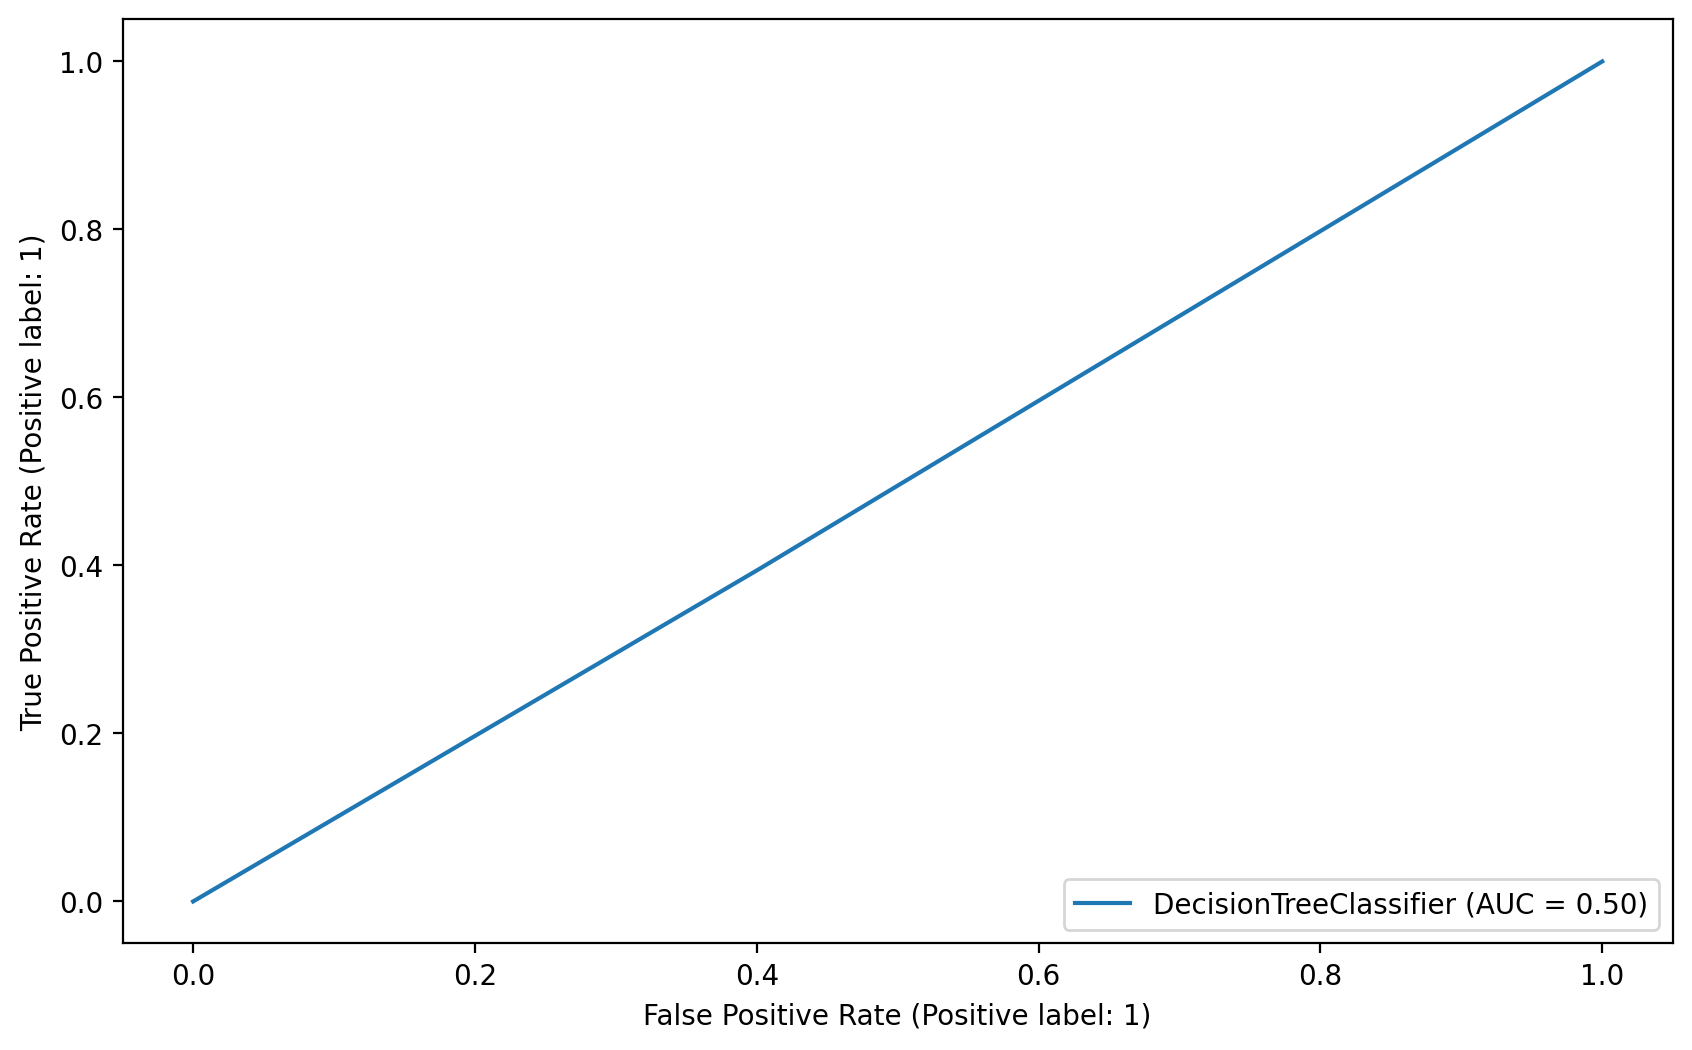

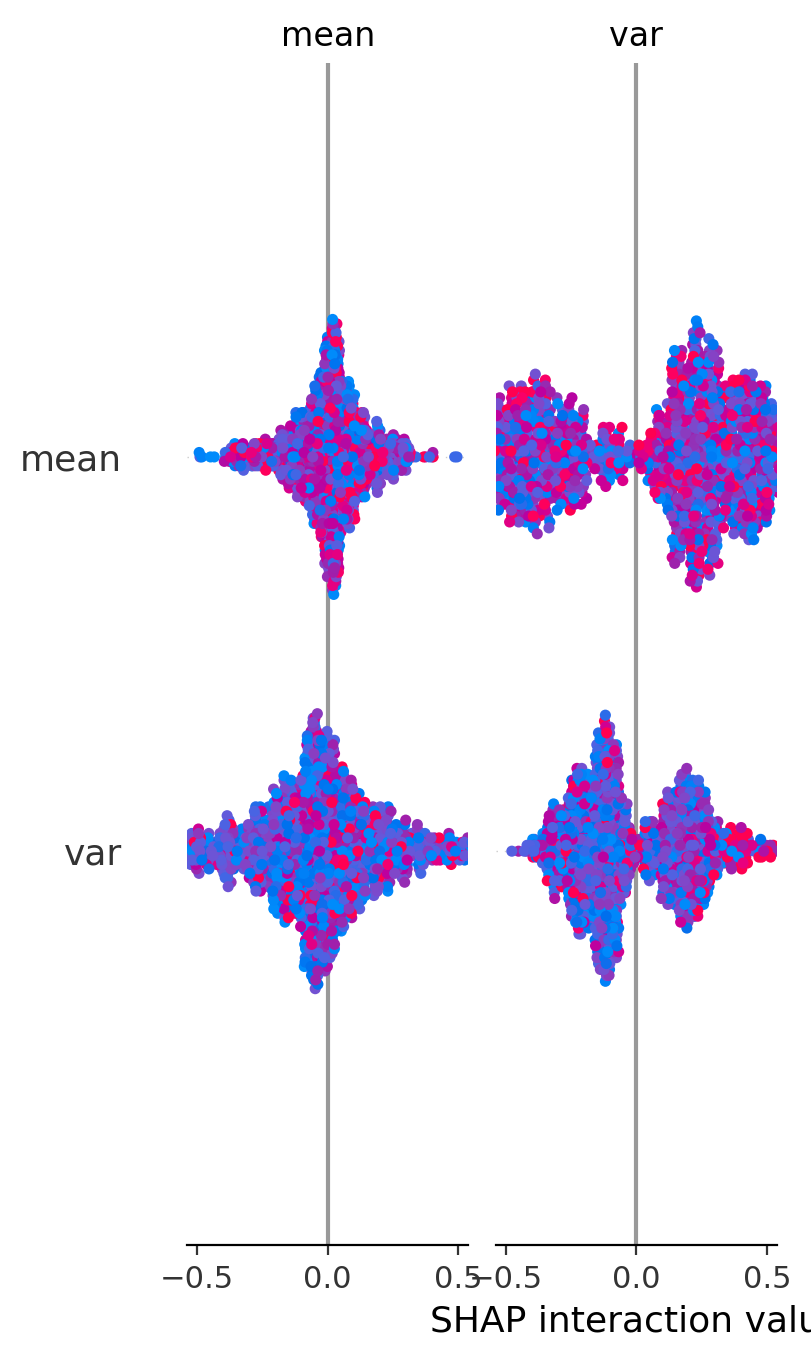

-------------------------------------------------- Gaussian Naive Bayes --------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.6208333333333333
roc_auc_score: 0.5146616221855576
precision_score: 0.6052631578947368
f1_score: 0.09181636726546906


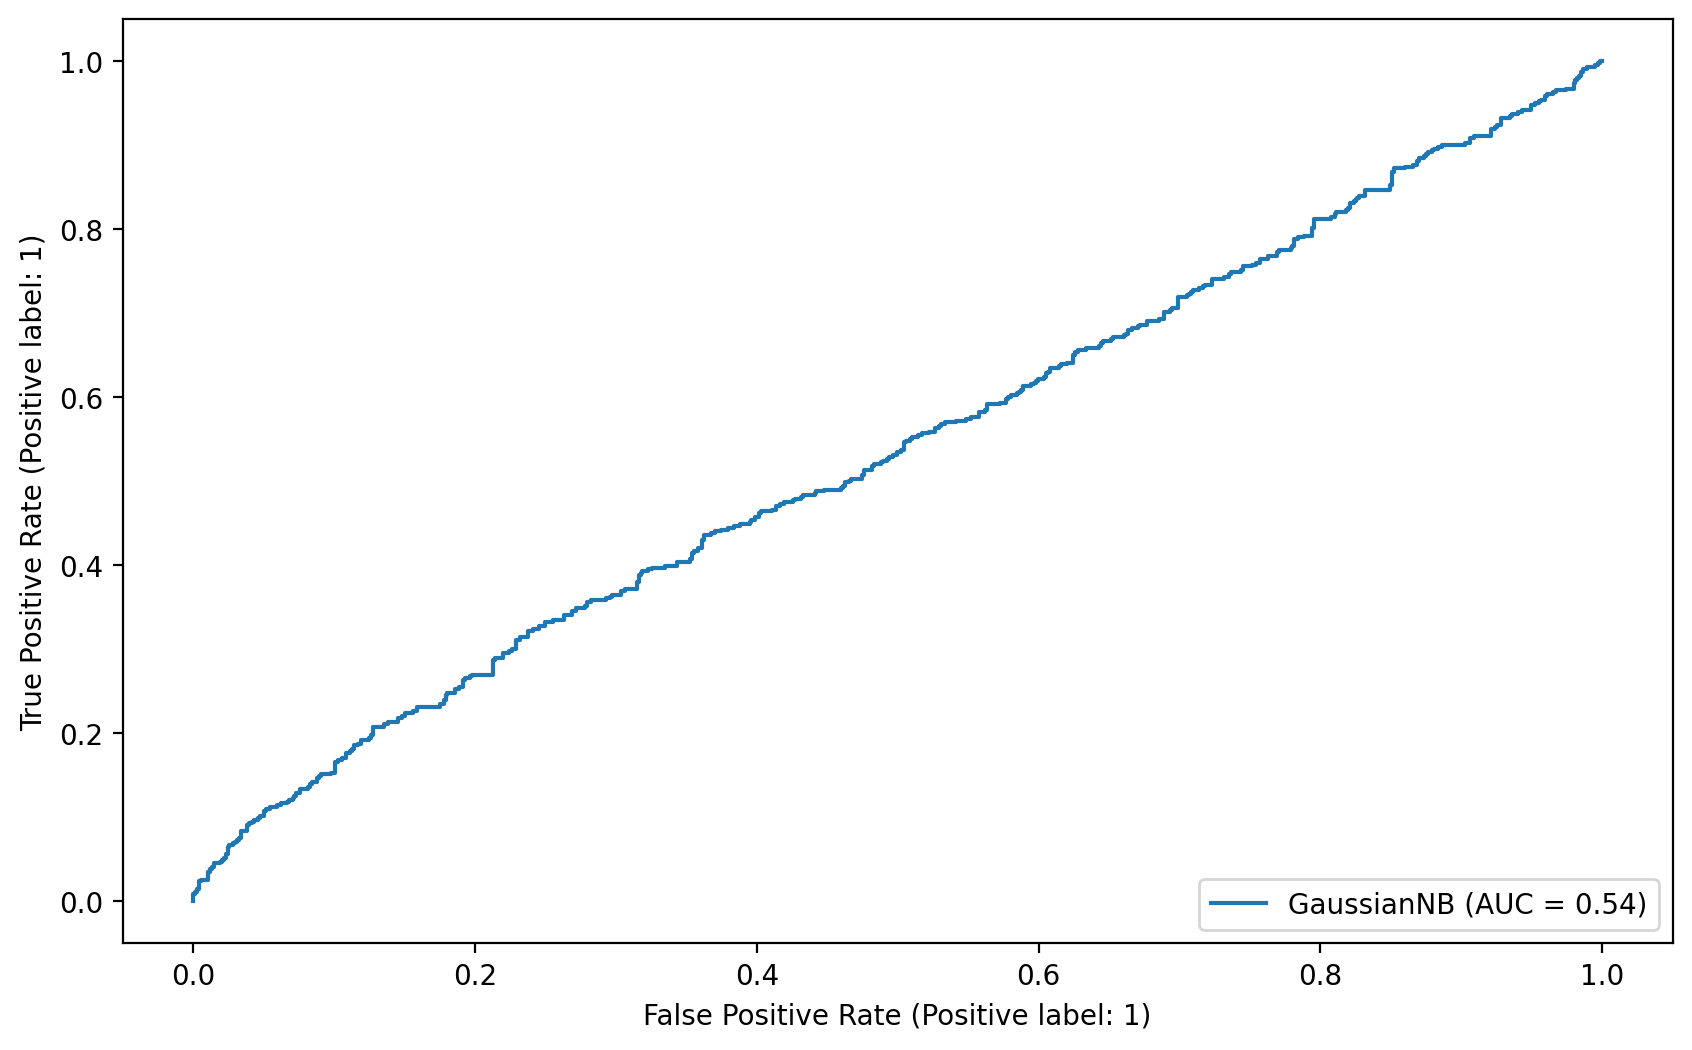

-------------------------------------------------- KNeighborsClassifier --------------------------------------------------
Model name: KNeighborsClassifier
accuracy_score: 0.5841666666666666
roc_auc_score: 0.5021701645191388
precision_score: 0.38461538461538464
f1_score: 0.23112480739599384


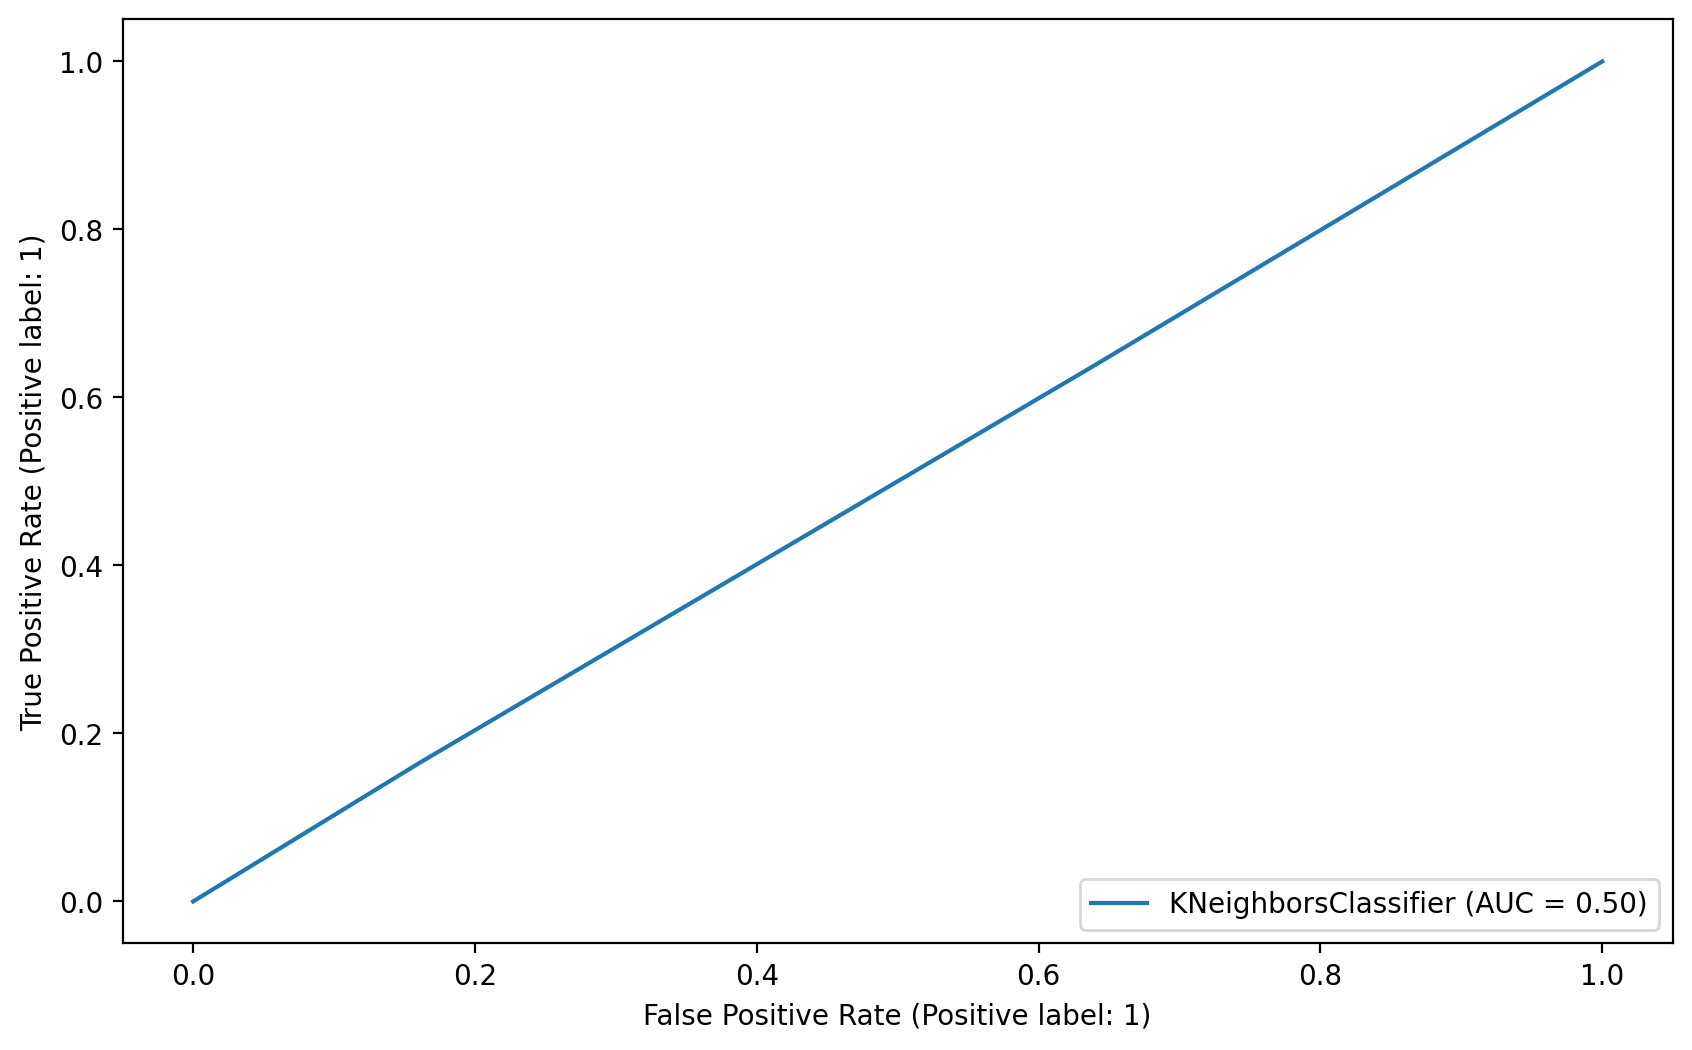

-------------------------------------------------- AdaBoostClassifier --------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.59
roc_auc_score: 0.5136099955377064
precision_score: 0.5517241379310345
f1_score: 0.11510791366906473


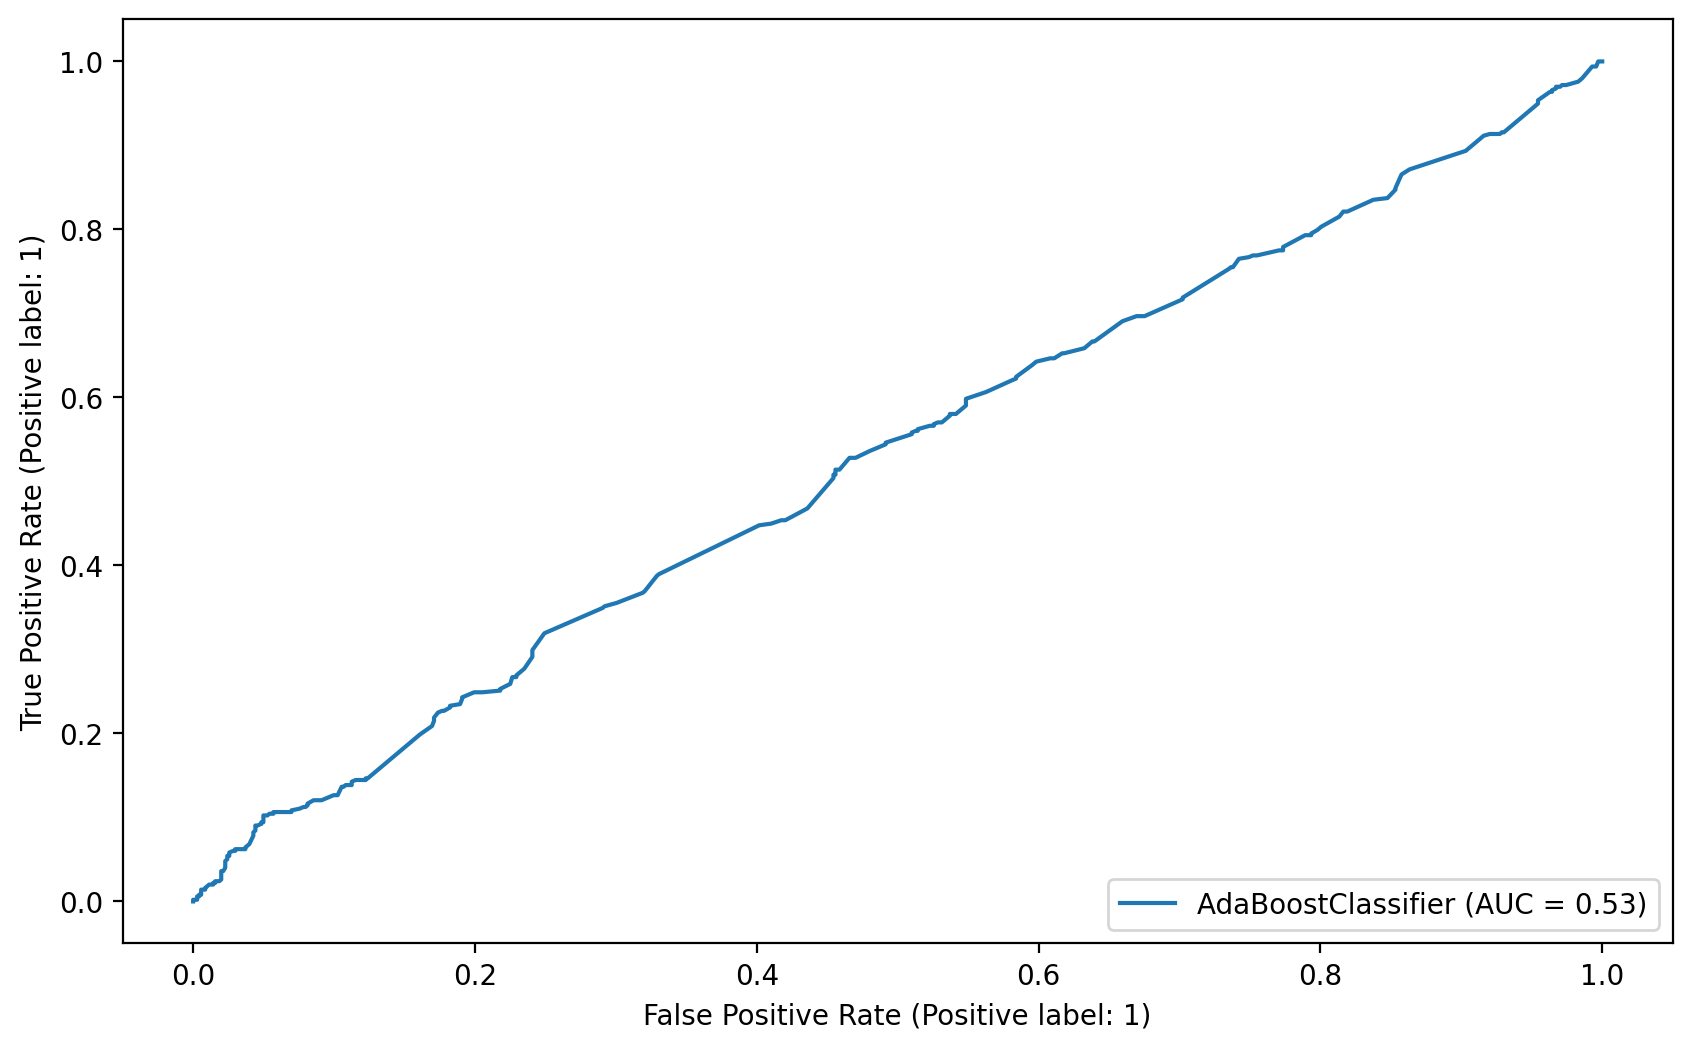

-------------------------------------------------- CatBoostClassifier --------------------------------------------------
Learning rate set to 0.020127
0:	learn: 0.6922724	total: 1.85ms	remaining: 1.85s
1:	learn: 0.6913992	total: 3.65ms	remaining: 1.82s
2:	learn: 0.6905843	total: 5.5ms	remaining: 1.83s
3:	learn: 0.6898070	total: 7.54ms	remaining: 1.88s
4:	learn: 0.6890038	total: 9.49ms	remaining: 1.89s
5:	learn: 0.6882758	total: 11.4ms	remaining: 1.89s
6:	learn: 0.6876066	total: 13.5ms	remaining: 1.92s
7:	learn: 0.6869017	total: 15.5ms	remaining: 1.92s
8:	learn: 0.6862302	total: 17.5ms	remaining: 1.93s
9:	learn: 0.6855364	total: 18.9ms	remaining: 1.87s
10:	learn: 0.6849421	total: 20.1ms	remaining: 1.81s
11:	learn: 0.6843310	total: 21.5ms	remaining: 1.77s
12:	learn: 0.6837961	total: 22.8ms	remaining: 1.73s
13:	learn: 0.6832500	total: 24ms	remaining: 1.69s
14:	learn: 0.6826998	total: 25.6ms	remaining: 1.68s
15:	learn: 0.6821770	total: 26.8ms	remaining: 1.65s
16:	learn: 0.6817038	total: 27

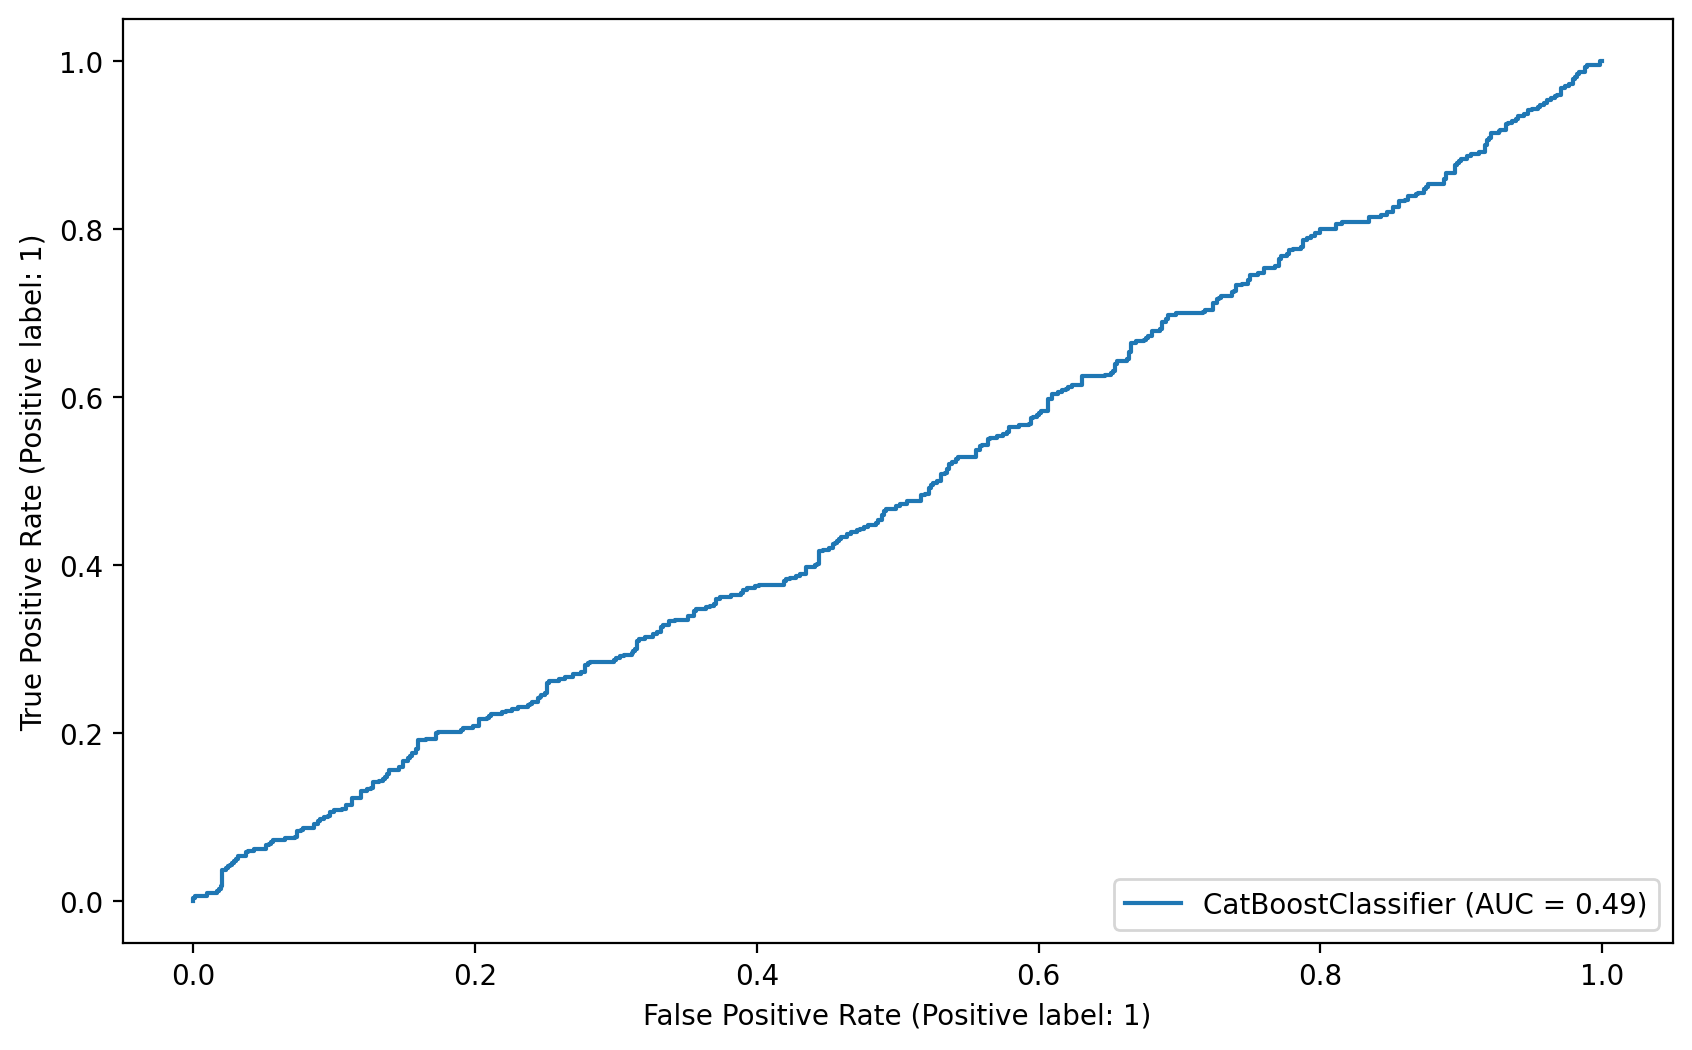

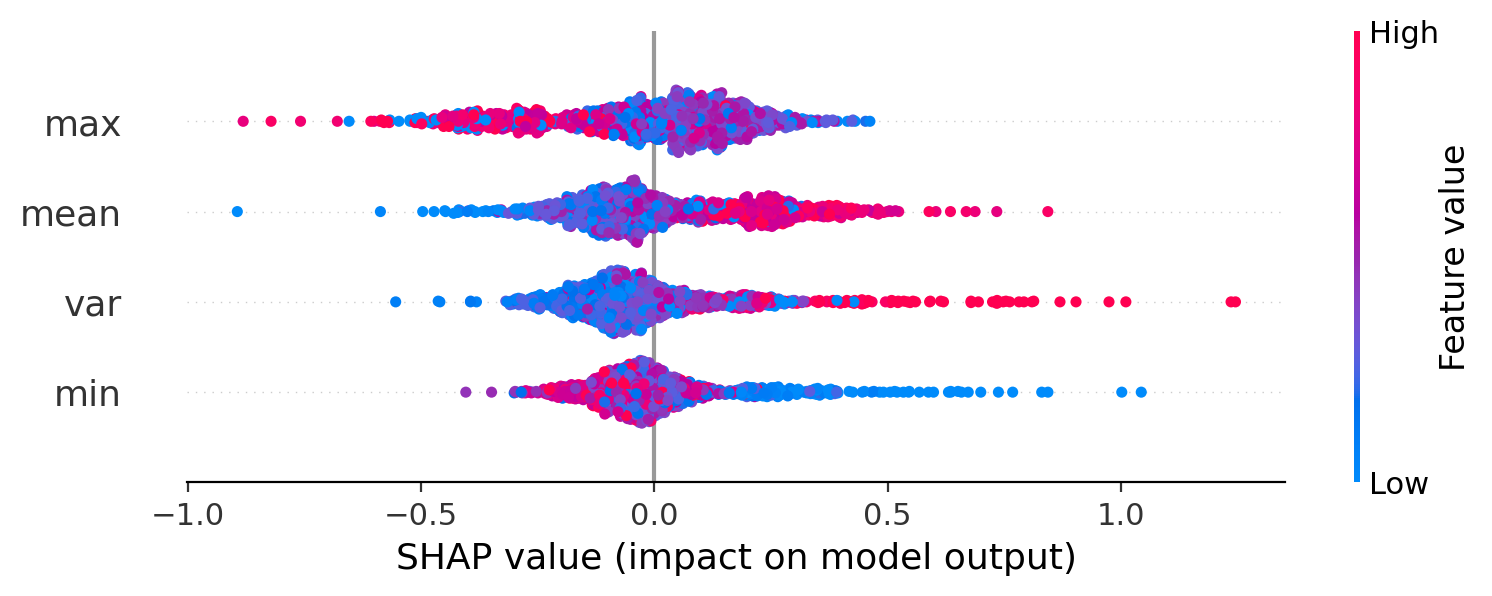

-------------------------------------------------- XGBClassifier --------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.5308333333333334
roc_auc_score: 0.4816886196682293
precision_score: 0.36538461538461536
f1_score: 0.28824273072060685


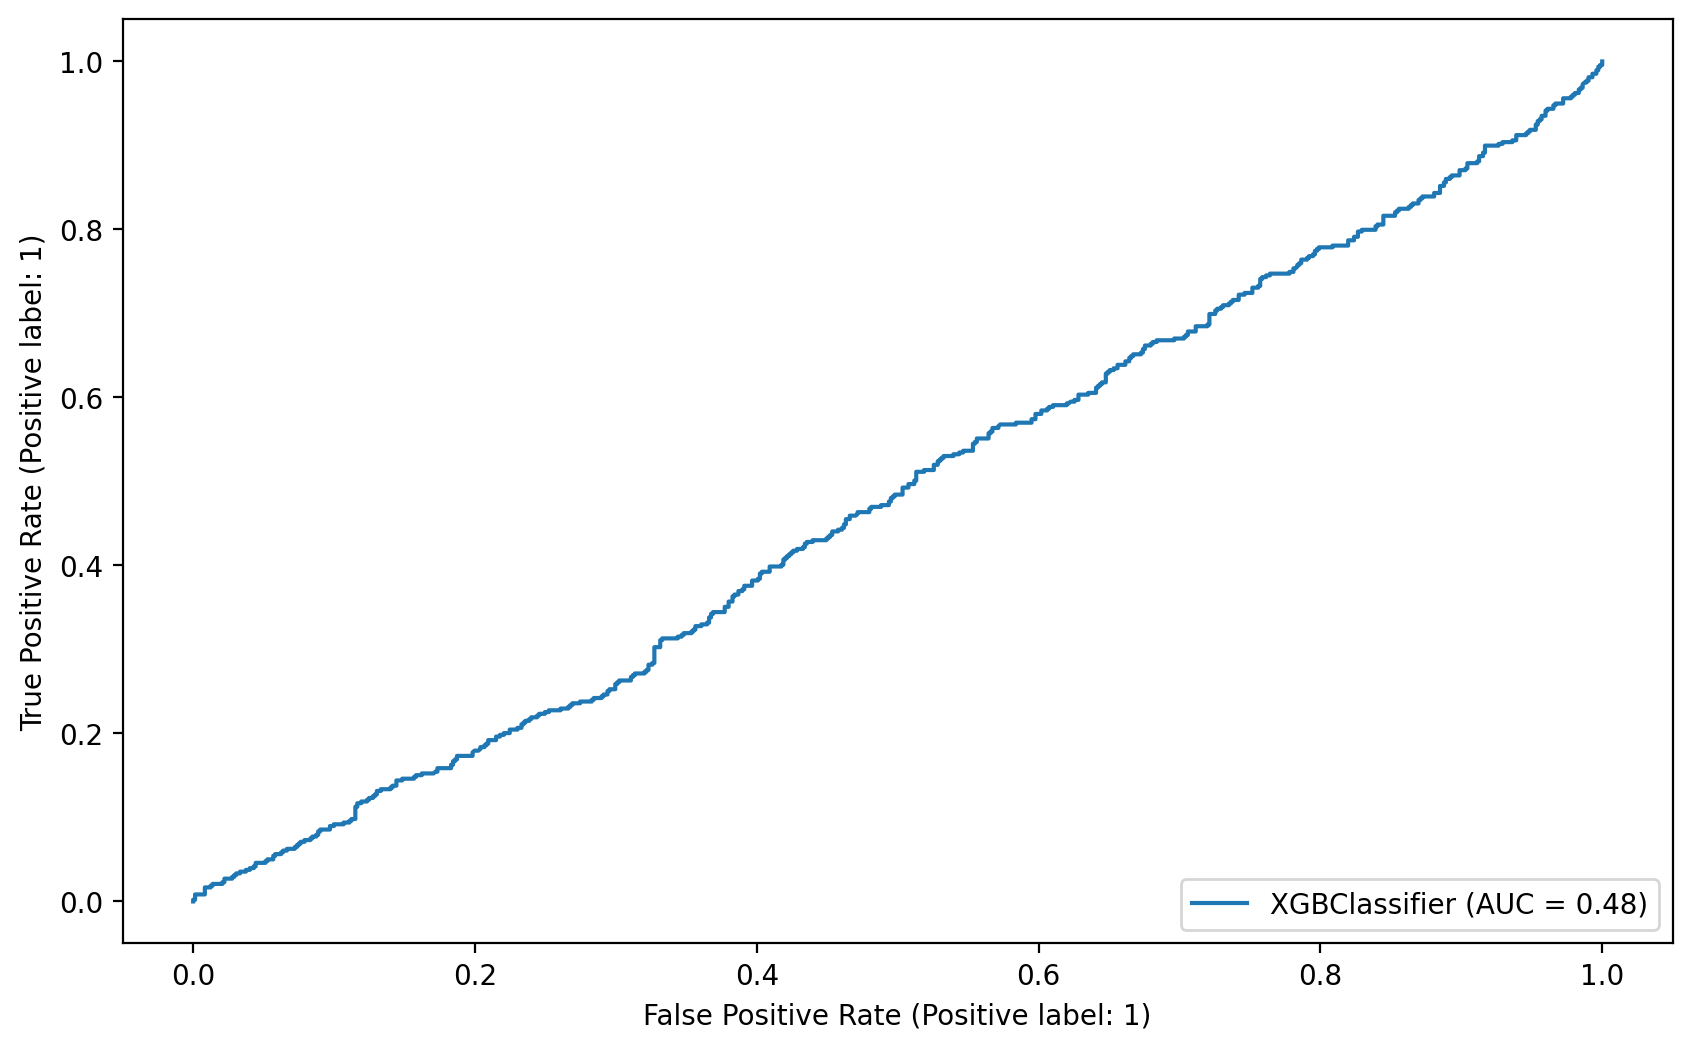

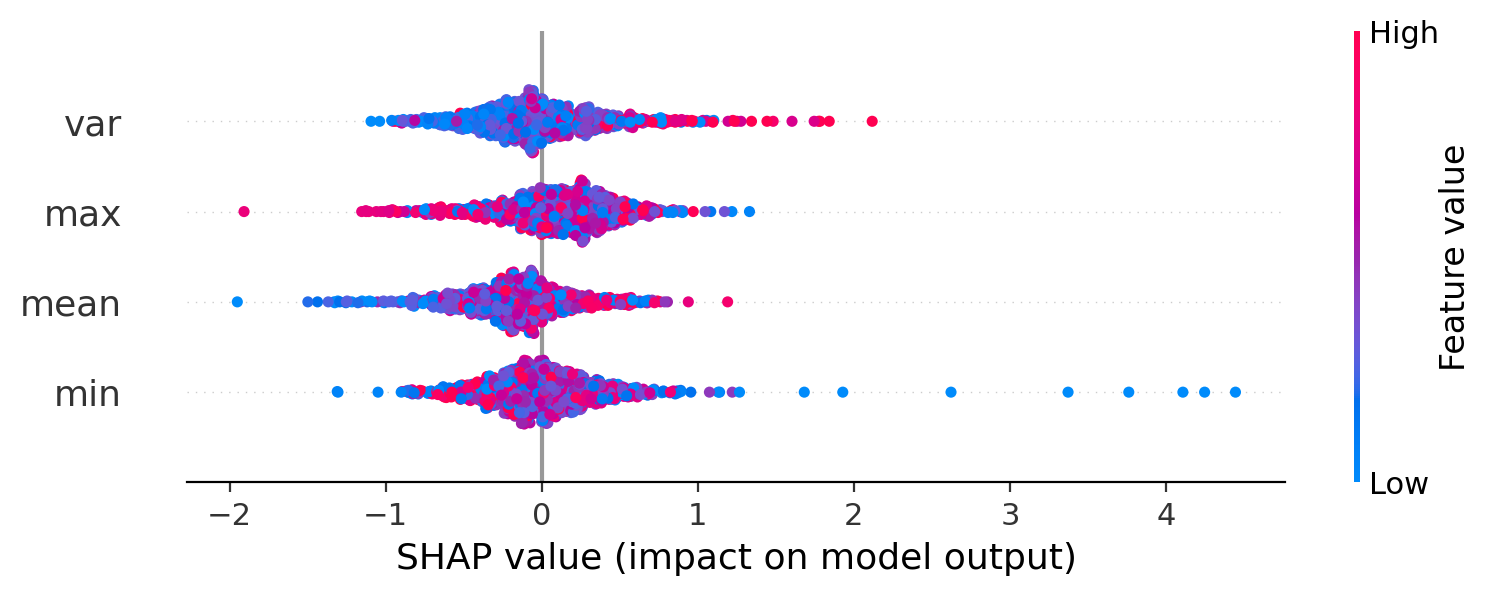

-------------------------------------------------- LGBMClassifier --------------------------------------------------
[LightGBM] [Info] Number of positive: 1933, number of negative: 2866
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402792 -> initscore=-0.393844
[LightGBM] [Info] Start training from score -0.393844
Model name: LGBMClassifier
accuracy_score: 0.5575
roc_auc_score: 0.4969053040372635
precision_score: 0.3939393939393939
f1_score: 0.2552594670406732


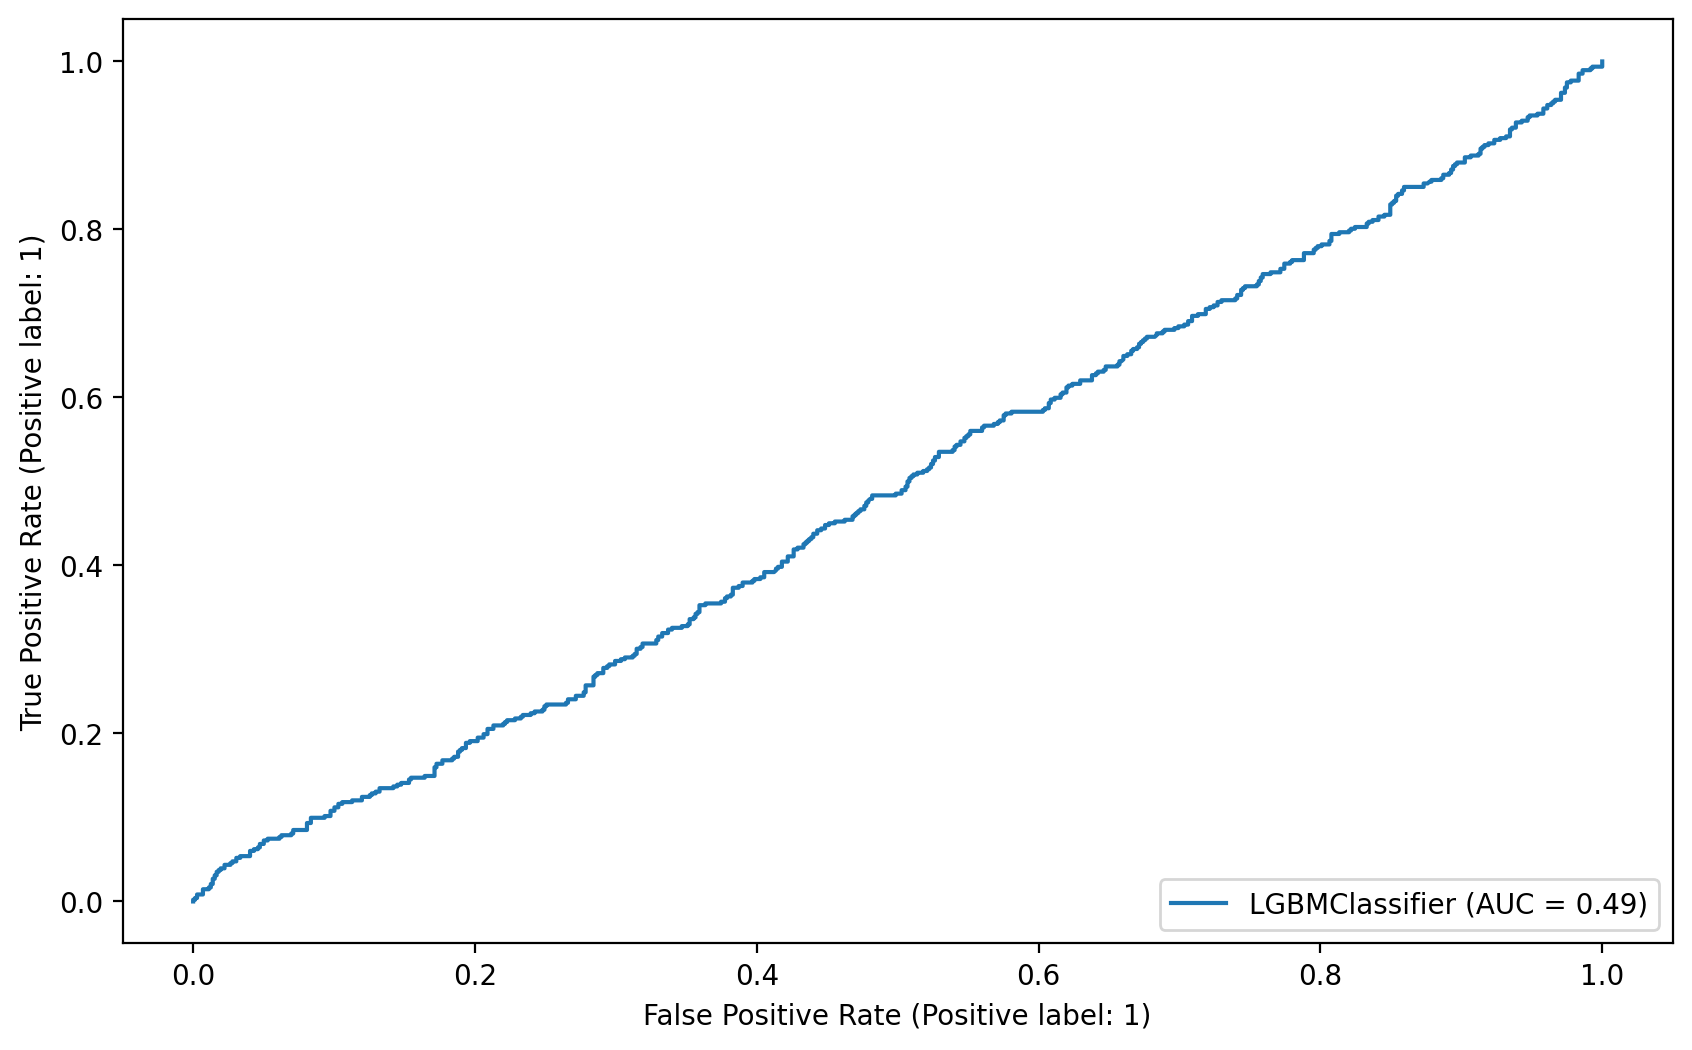

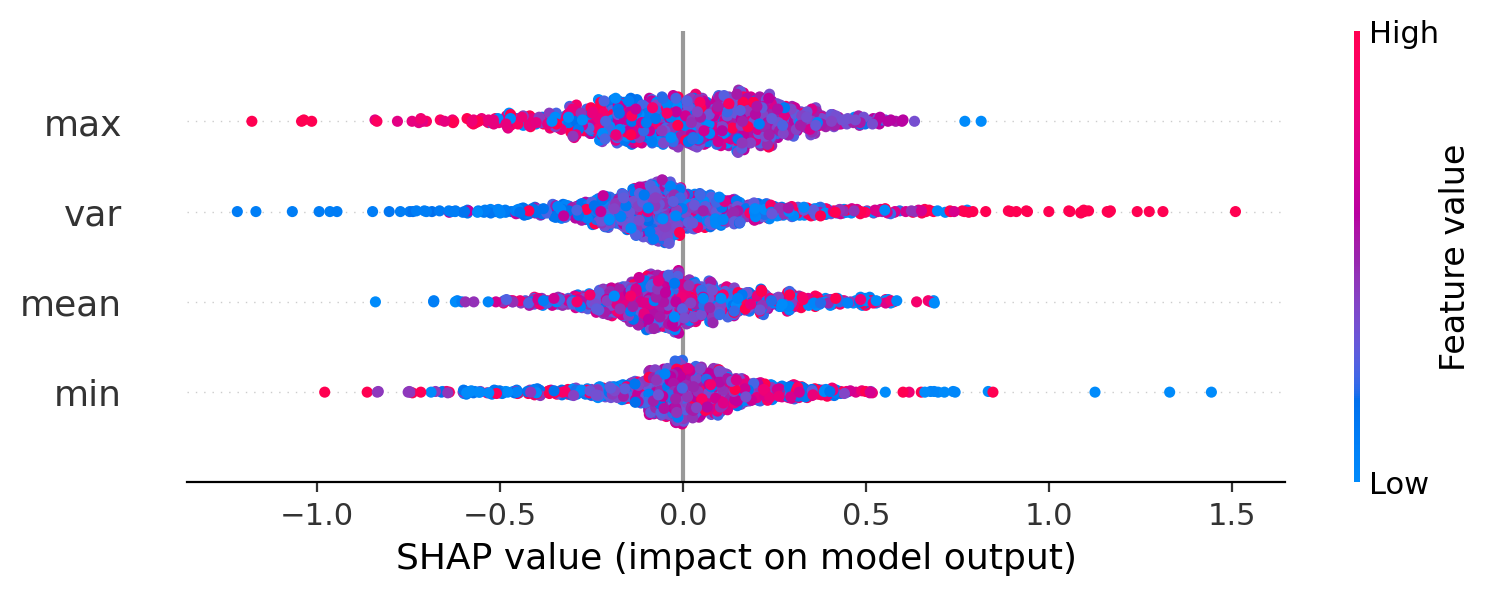

-------------------------------------------------- logistic regression --------------------------------------------------
Model name: logistic regression
accuracy_score: 0.595
roc_auc_score: 0.5073377428689542
precision_score: 0.7142857142857143
f1_score: 0.039525691699604744


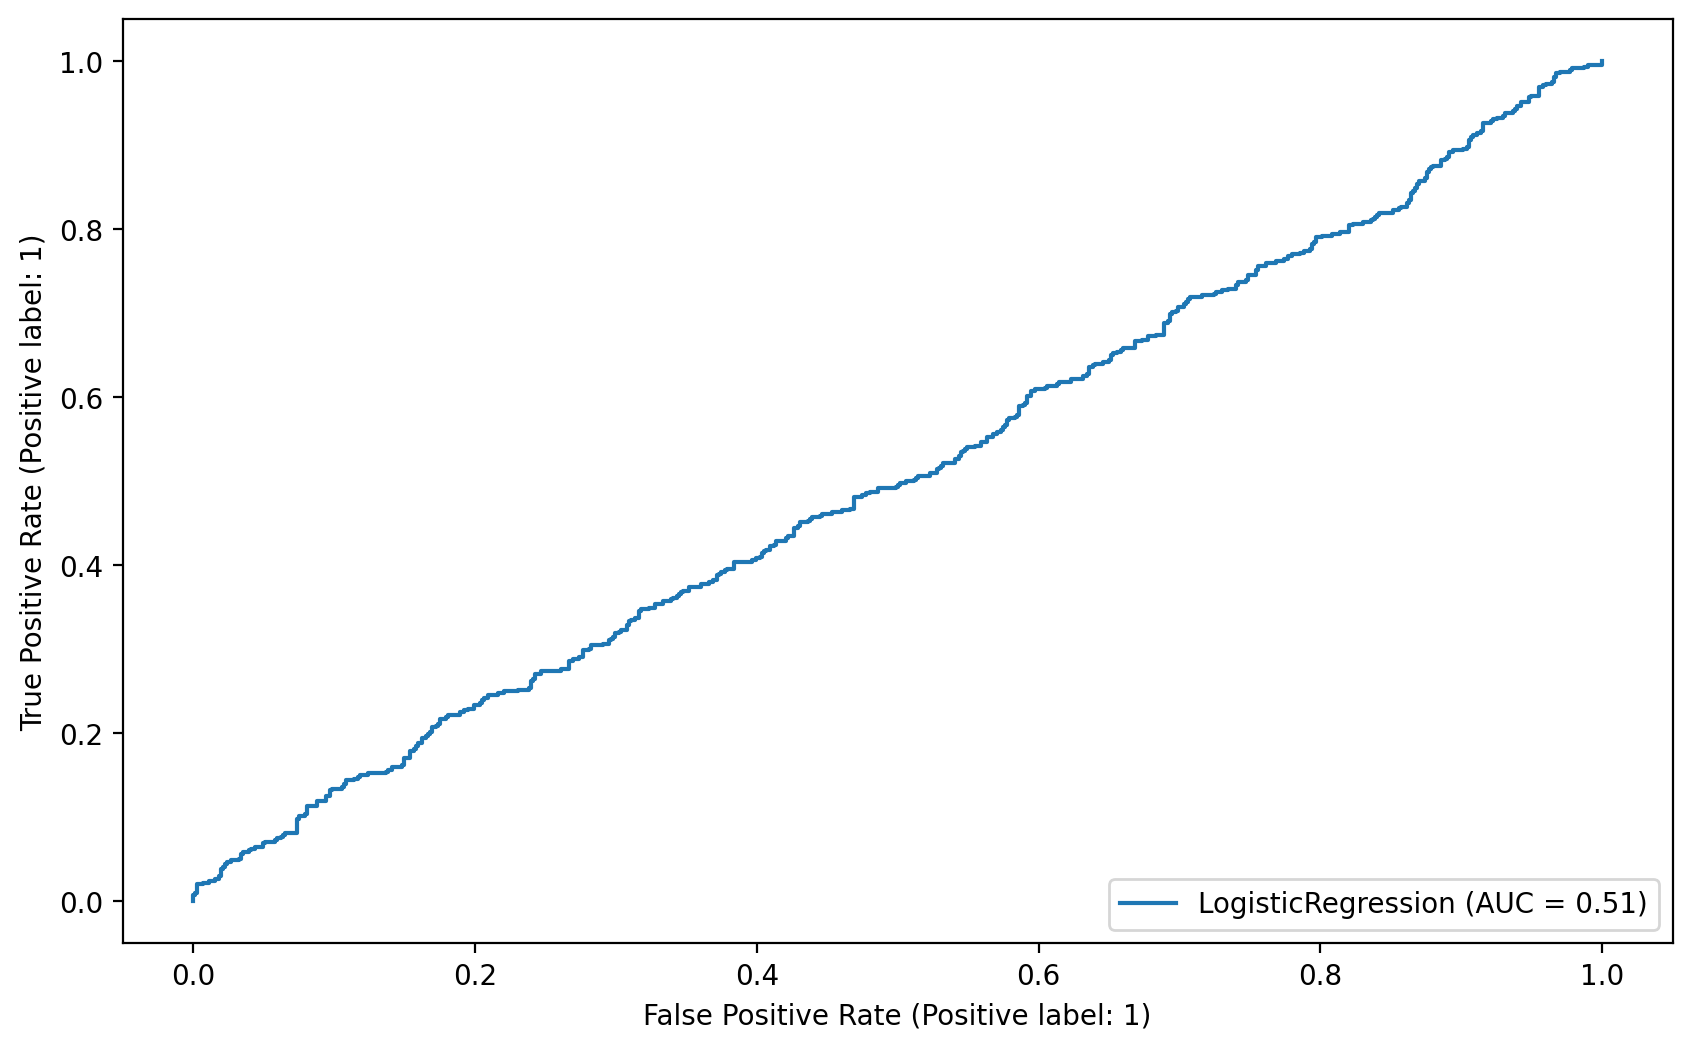

-------------------------------------------------- Support vector machine --------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.5733333333333334
roc_auc_score: 0.5067677698249592
precision_score: 0.5428571428571428
f1_score: 0.06909090909090909


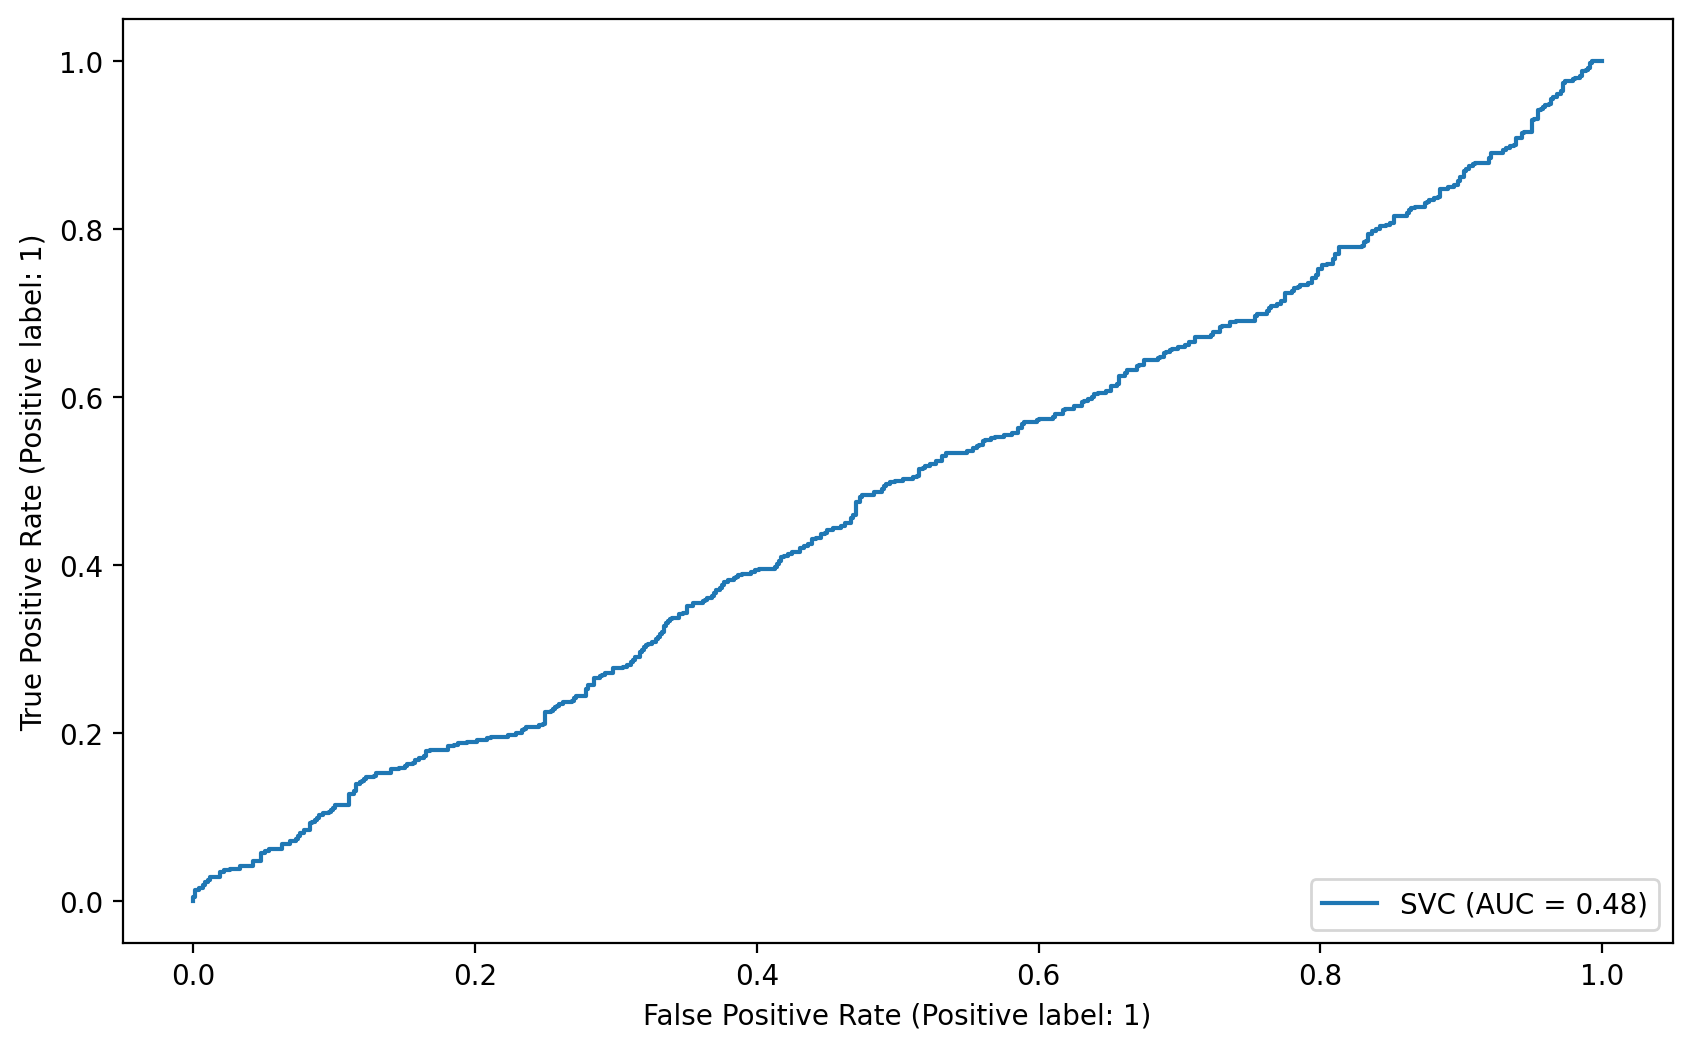

-------------------------------------------------- basic random forrest --------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.5566666666666666
roc_auc_score: 0.5096434730581072
precision_score: 0.4005681818181818
f1_score: 0.3464373464373464


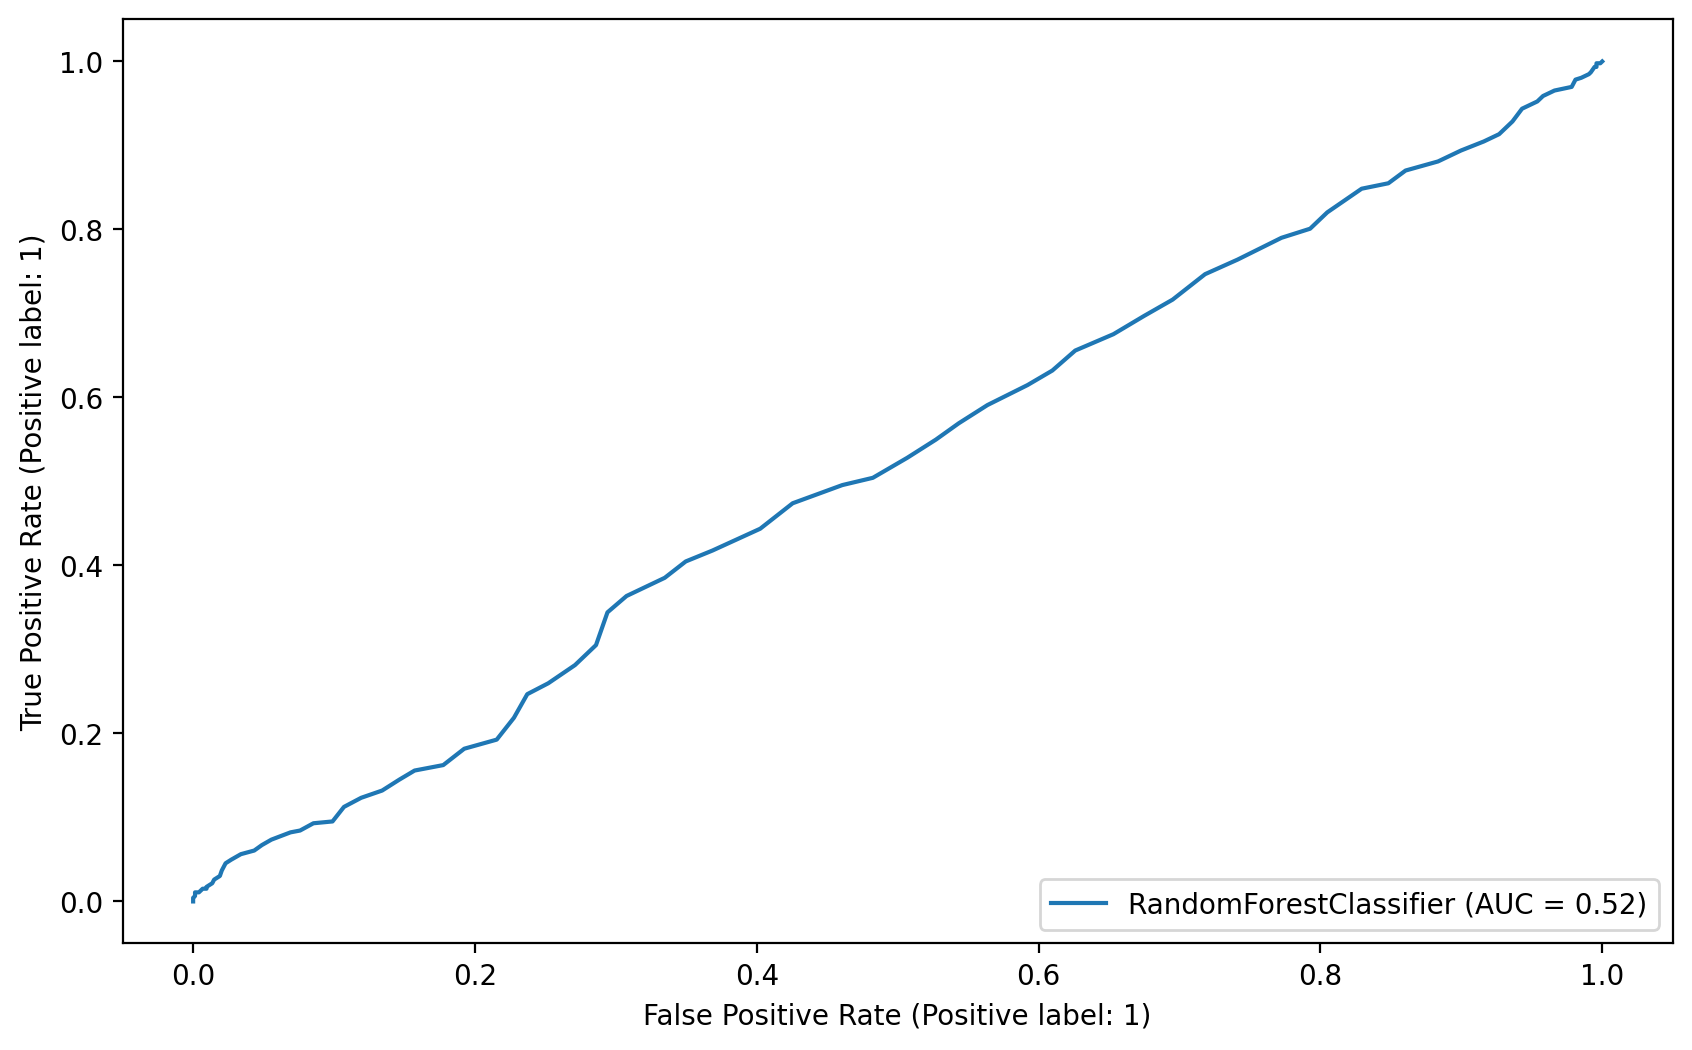

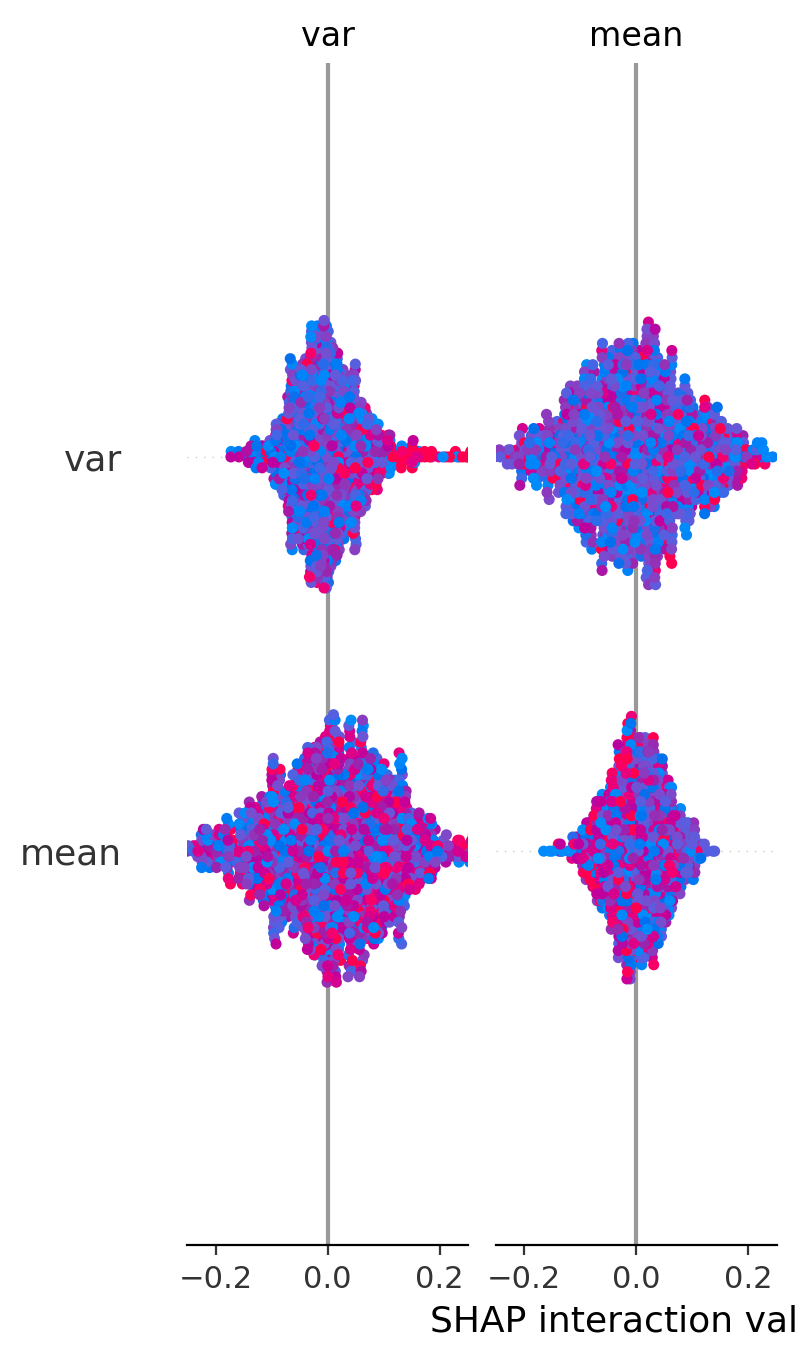

In [54]:
results=[]
for m in get_models():
    print("-"*50,m["name"],"-"*50)
    results.append(classify(df.drop(columns=["kurtosis","skew"]),0.2,m["model"],m["name"]))

### 2.3.3  Compare results

In [55]:
compare_model_results(results)

                        Accuracy  Precision  Recall      F1
decision tree             0.5125     0.4205  0.3949  0.4073
basic random forrest      0.5567     0.4006  0.3052  0.3464
XGBClassifier             0.5308     0.3654  0.2380  0.2882
LGBMClassifier            0.5575     0.3939  0.1888  0.2553
KNeighborsClassifier      0.5842     0.3846  0.1652  0.2311
CatBoostClassifier        0.5808     0.4094  0.1083  0.1713
AdaBoostClassifier        0.5900     0.5517  0.0643  0.1151
Gaussian Naive Bayes      0.6208     0.6053  0.0497  0.0918
Support vector machine    0.5733     0.5429  0.0369  0.0691
logistic regression       0.5950     0.7143  0.0203  0.0395


### 2.4 best features selection
in this section we will take all the featurs from previous section and attempt to classify using all of them

### 2.4.1  Load data

In [56]:
df_interval=df_interval.sort_index()
df_interval=df_interval.drop("3",axis=1)

parsed_details=parsed_details.sort_index()
df=df.sort_index()
df=df.drop(columns=["kurtosis","skew"])

join_df=df.copy()

for c in parsed_details.columns:
    join_df[c]=parsed_details[c]
for c in df_interval.columns:
    join_df[c]=df_interval[c]
join_df

mean          var   min   max  Label      ECO_A  \
ABCi         1463.333333   739.022222  1406  1502      0  20.000000   
ABSBEGINNER  1344.142276  1451.811736  1241  1426      0   5.826558   
ADJUSTOR     1878.373218  1864.929391  1745  1994      1  18.660907   
AFCERGY      1571.542036  1115.665047  1461  1677      1  26.934436   
AFRF         1364.376000  1022.746624  1278  1456      0  20.840000   
...                  ...          ...   ...   ...    ...        ...   
zwartspeler  1821.970471  1499.353478  1724  1925      0  29.130088   
zwirek        985.571429   452.530612   951  1016      1  42.857143   
zxtxf        1332.290323  1331.109261  1252  1408      1  58.064516   
zyrq         1478.447326  2225.900386  1373  1590      0  20.907618   
zzyxx        1497.287770  1376.881217  1418  1597      0  27.338129   

                 ECO_B      ECO_C      ECO_D      ECO_E  ...  TotalGames  \
ABCi         26.666667   0.000000  26.666667  26.666667  ...          15   
ABSBEGINNER  23.983740  56.436314  13.346883   0.406504  ...        1476   
ADJUSTOR     35.485961  36.090713   0.215983   9.546436  ...        4630   
AFCERGY      30.379996   0.472534  30.399685  11.813349  ...        5079   
AFRF         55.560000  23.080000   0.440000   0.080000  ...        2500   
...                ...        ...        ...        ...  ...         ...   
zwartspeler  29.449322   1.436552  20.430966  19.553073  ...        1253   
zwirek       14.285714  14.285714  28.571429   0.000000  ...           7   
zxtxf        25.806452   6.451613   6.451613   3.225806  ...          31   
zyrq         36.628849  11.669368  30.470016   0.324149  ...         617   
zzyxx        40.647482  16.906475   5.755396   9.352518  ...         278   

             EloDiff_2/3_mean  EloDiff_3/3_mean  EloDiff_mean  \
ABCi               -64.200000         84.000000    -10.533333   
ABSBEGINNER          3.953252          6.638211     -1.865854   
ADJUSTOR            17.977317         70.421632      5.944708   
AFCERGY              1.687537        -28.724749     -1.141366   
AFRF                 1.735894         94.116307      1.068000   
...                       ...               ...           ...   
zwartspeler          2.837321        -85.854067     -1.141261   
zwirek            -235.000000        166.333333    -42.142857   
zxtxf               14.400000         27.181818     -0.419355   
zyrq                -5.194175          2.548544      0.035656   
zzyxx                5.838710       -109.602151     -9.482014   

             total_games_1/3_time_mean  total_games_2/3_time_mean  \
ABCi                                10                          4   
ABSBEGINNER                        400                        510   
ADJUSTOR                          1106                       1951   
AFCERGY                           1529                       2411   
AFRF                               610                       1182   
...                                ...                        ...   
zwartspeler                        445                        695   
zwirek                               3                          2   
zxtxf                               12                         10   
zyrq                               139                        161   
zzyxx                               61                        109   

             total_games_3/3_time_mean       0       1       2  
ABCi                                 1  1458.0  1429.0  1457.0  
ABSBEGINNER                        566  1317.0  1356.0  1289.0  
ADJUSTOR                          1573  1893.0  1862.0  1917.0  
AFCERGY                           1139  1532.0  1637.0  1600.0  
AFRF                               708  1353.0  1387.0  1285.0  
...                                ...     ...     ...     ...  
zwartspeler                        113  1821.0  1818.0  1812.0  
zwirek                               2   951.0   963.0  1016.0  
zxtxf                                9  1331.0  1362.0  130

### 2.4.2  Run classification model

-------------------------------------------------- decision tree --------------------------------------------------
Model name: decision tree
accuracy_score: 0.6983333333333334
roc_auc_score: 0.6855021267392402
precision_score: 0.6289308176100629
f1_score: 0.6237006237006237


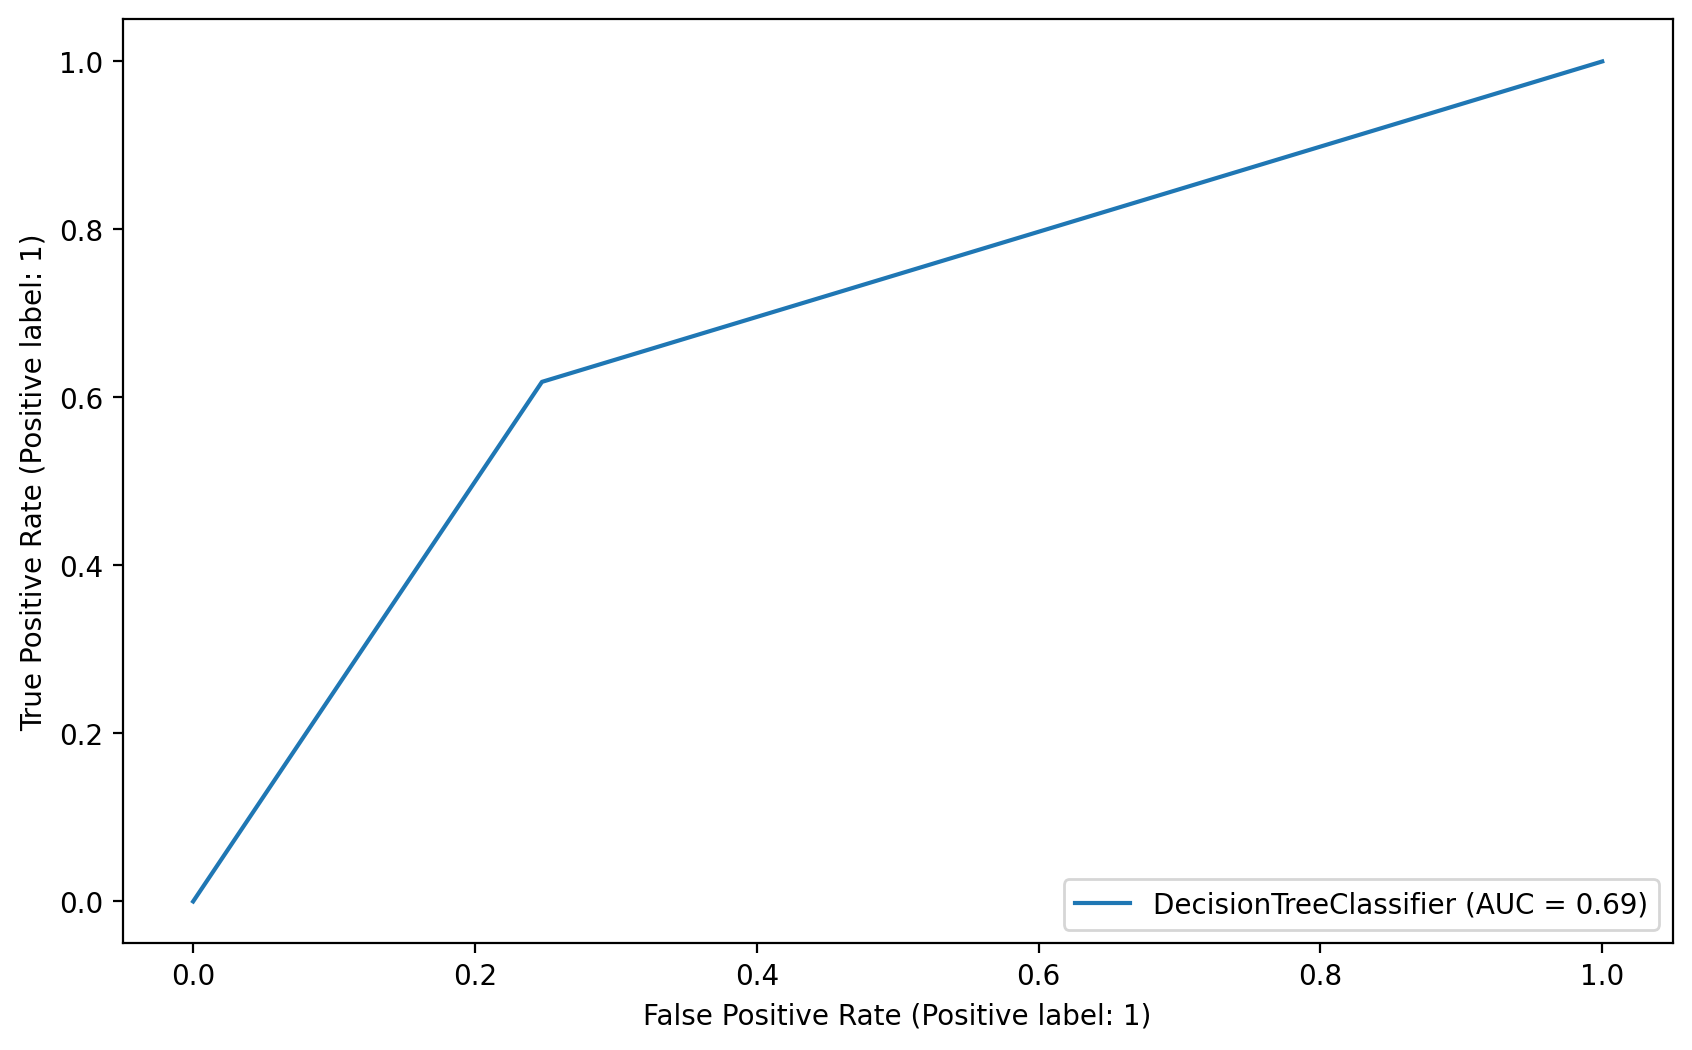

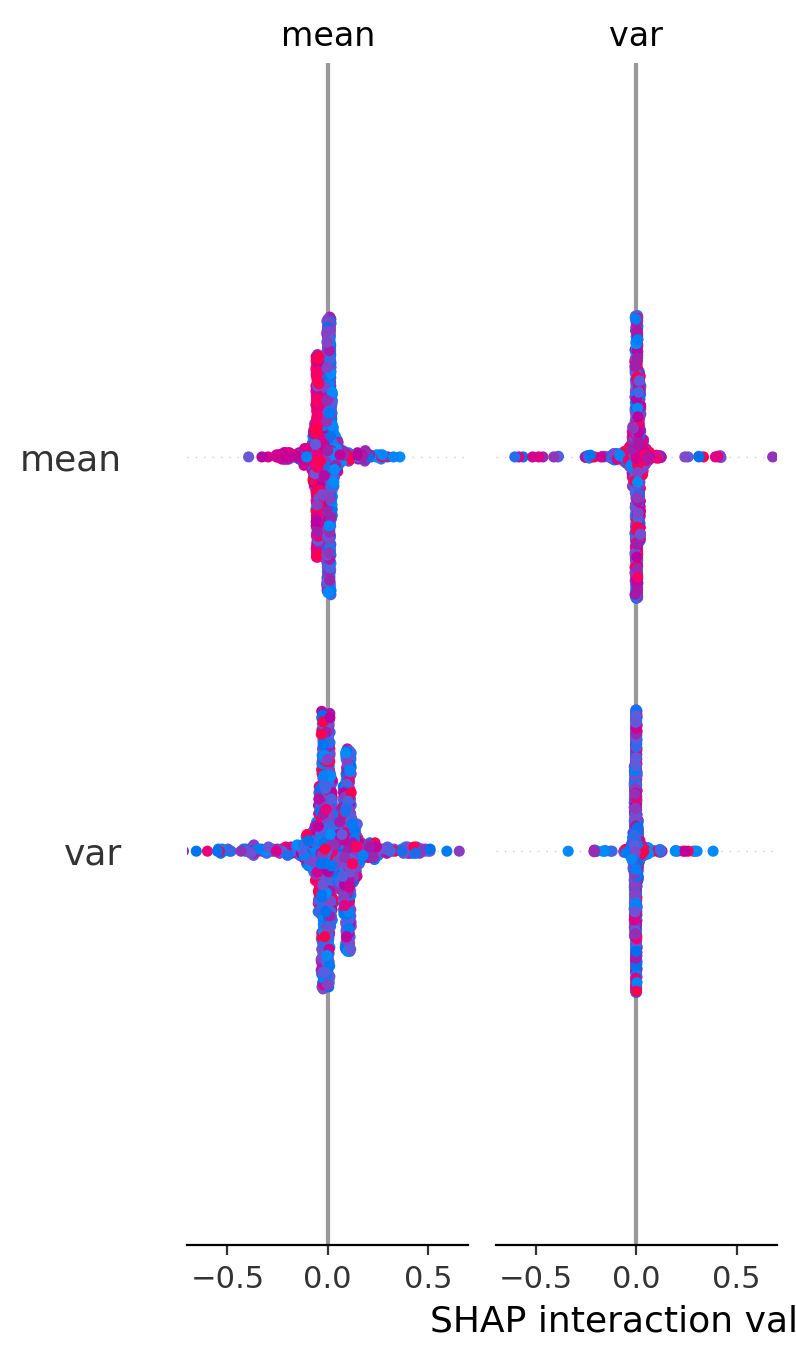

-------------------------------------------------- Gaussian Naive Bayes --------------------------------------------------
Model name: Gaussian Naive Bayes
accuracy_score: 0.5975
roc_auc_score: 0.5205794847812802
precision_score: 0.5641025641025641
f1_score: 0.15411558669001751


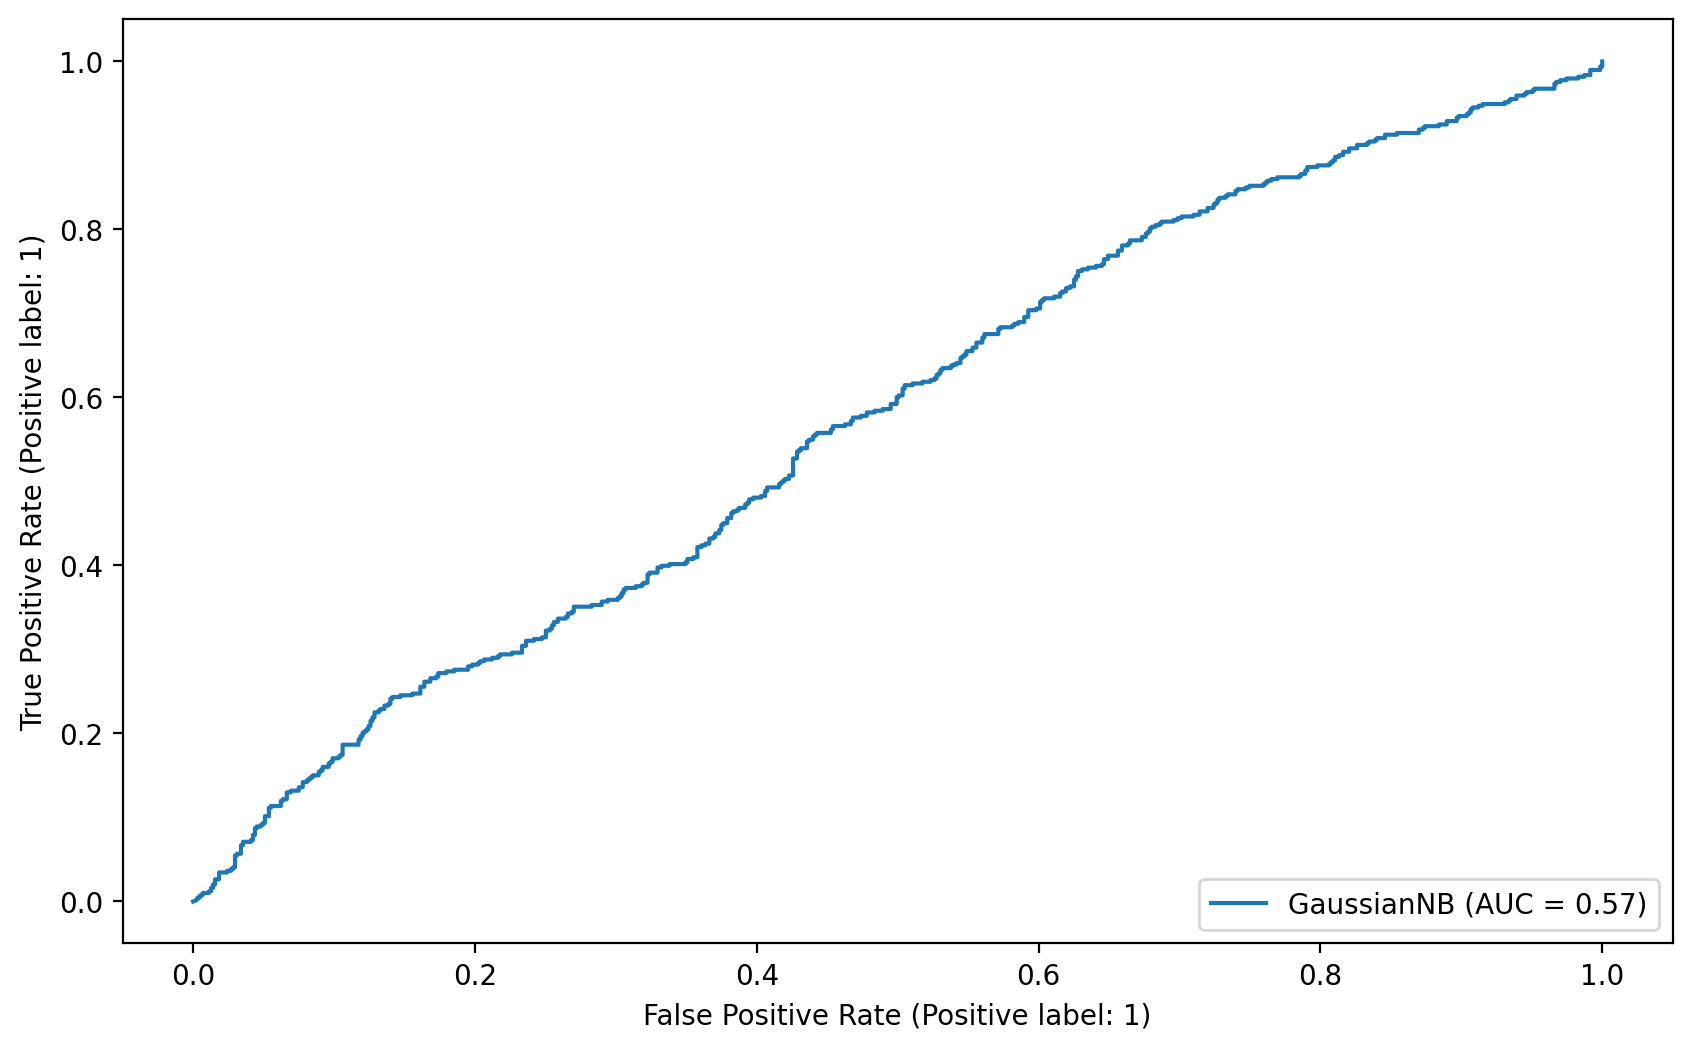

-------------------------------------------------- KNeighborsClassifier --------------------------------------------------


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b5160b93880>
Traceback (most recent call last):
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribut

Model name: KNeighborsClassifier
accuracy_score: 0.5658333333333333
roc_auc_score: 0.5036758044057881
precision_score: 0.41836734693877553
f1_score: 0.23941605839416058


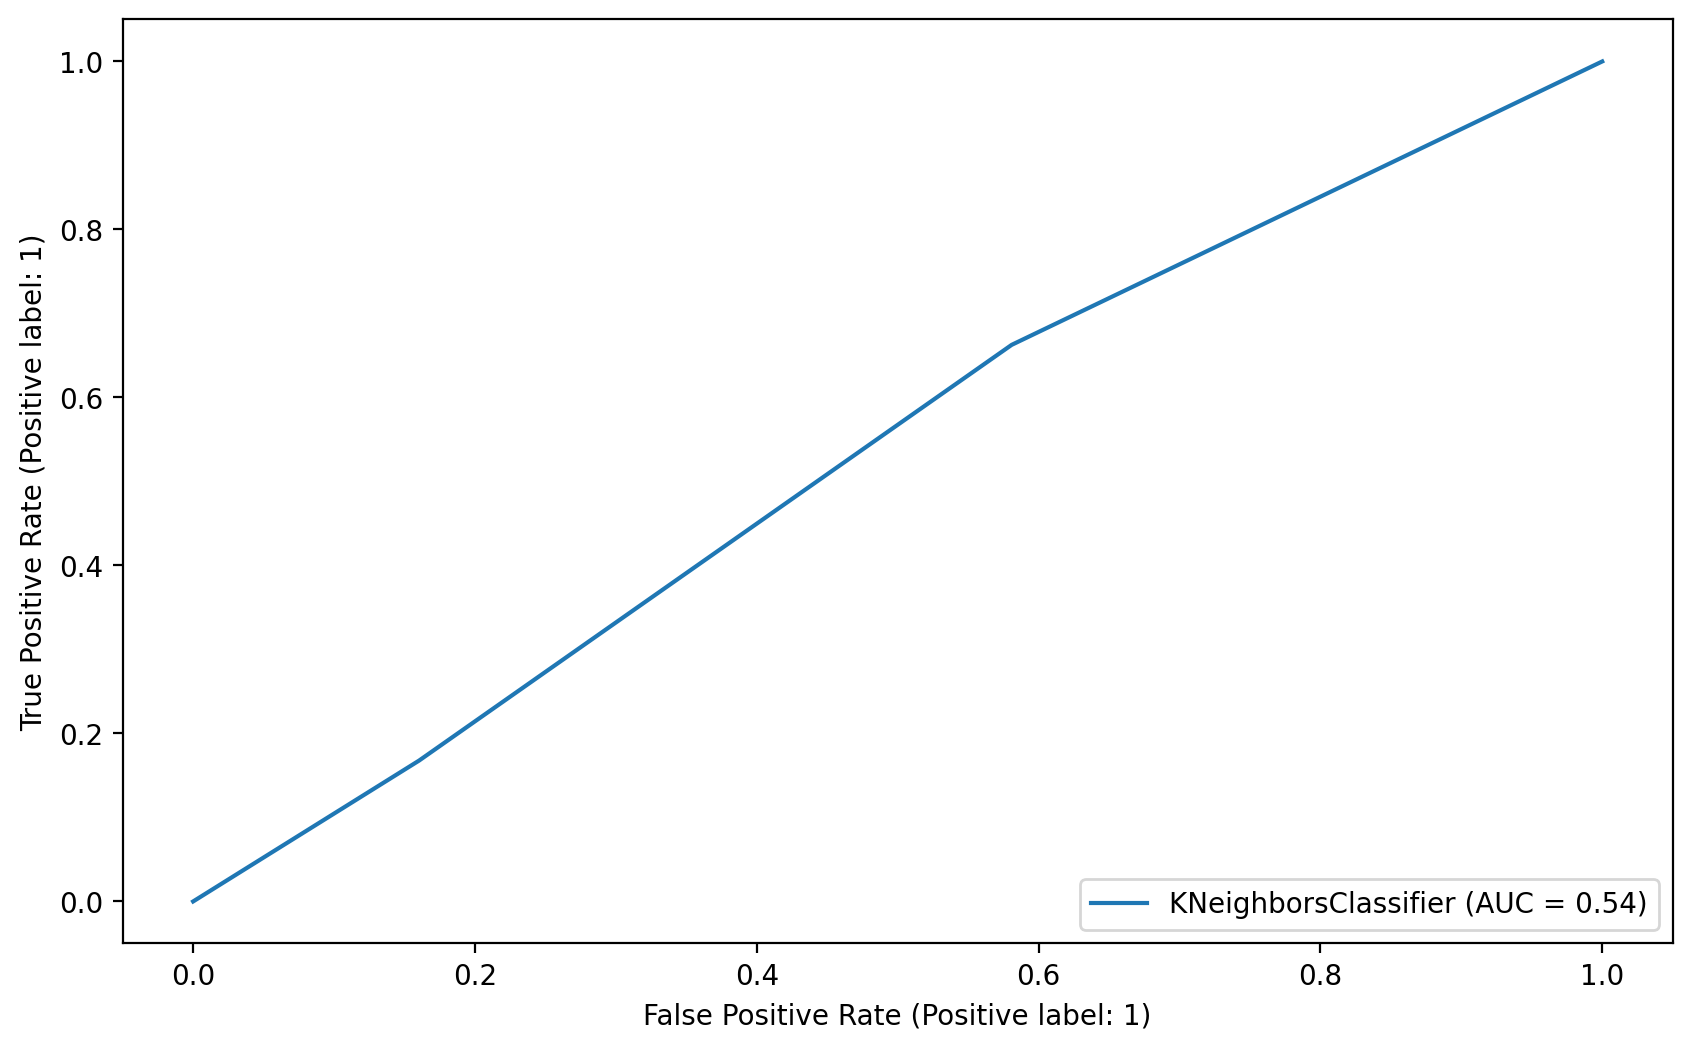

-------------------------------------------------- AdaBoostClassifier --------------------------------------------------
Model name: AdaBoostClassifier
accuracy_score: 0.7558333333333334
roc_auc_score: 0.7177084433181994
precision_score: 0.7478005865102639
f1_score: 0.635118306351183


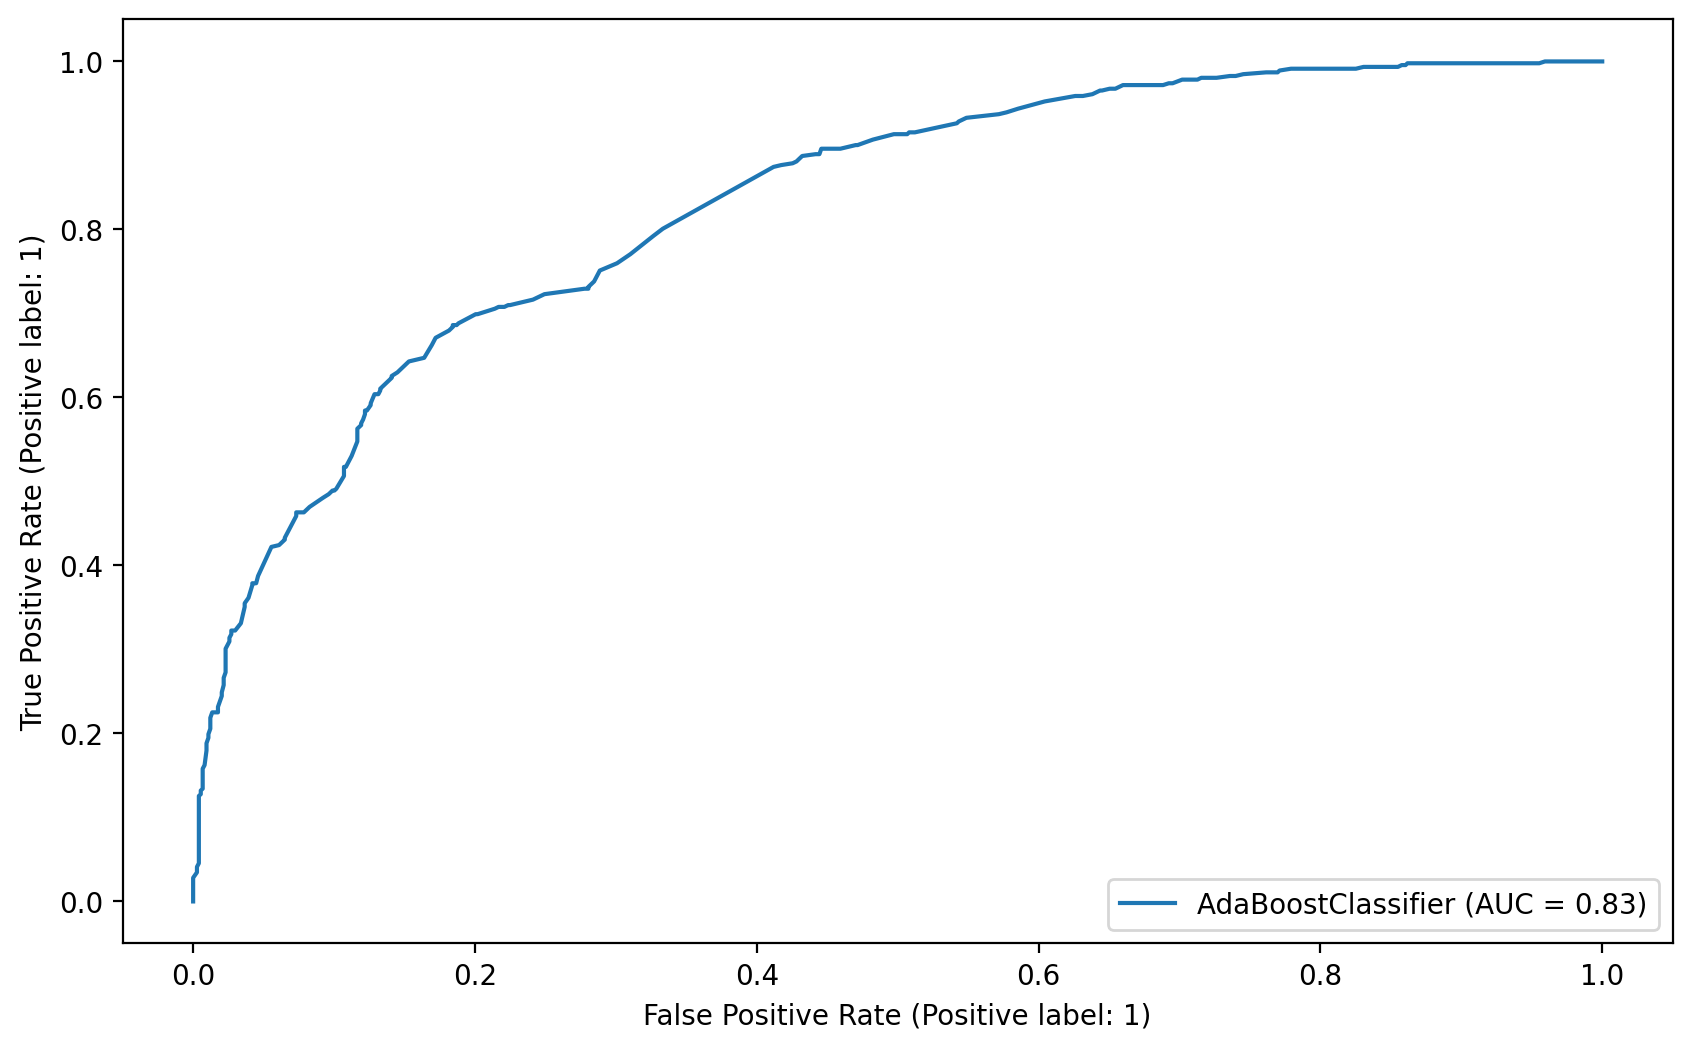

-------------------------------------------------- CatBoostClassifier --------------------------------------------------
Learning rate set to 0.020127
0:	learn: 0.6907039	total: 2.52ms	remaining: 2.52s
1:	learn: 0.6884893	total: 3.89ms	remaining: 1.94s
2:	learn: 0.6876149	total: 5.18ms	remaining: 1.72s
3:	learn: 0.6851416	total: 6.58ms	remaining: 1.64s
4:	learn: 0.6828452	total: 7.94ms	remaining: 1.58s
5:	learn: 0.6802754	total: 9.38ms	remaining: 1.55s
6:	learn: 0.6776044	total: 10.7ms	remaining: 1.52s
7:	learn: 0.6753359	total: 12ms	remaining: 1.49s
8:	learn: 0.6723257	total: 13.7ms	remaining: 1.51s
9:	learn: 0.6693791	total: 15.1ms	remaining: 1.49s
10:	learn: 0.6674119	total: 16.4ms	remaining: 1.47s
11:	learn: 0.6659341	total: 17.7ms	remaining: 1.46s
12:	learn: 0.6642507	total: 19.2ms	remaining: 1.46s
13:	learn: 0.6618236	total: 20.6ms	remaining: 1.45s
14:	learn: 0.6592471	total: 22.1ms	remaining: 1.45s
15:	learn: 0.6575079	total: 23.6ms	remaining: 1.45s
16:	learn: 0.6558906	total: 2

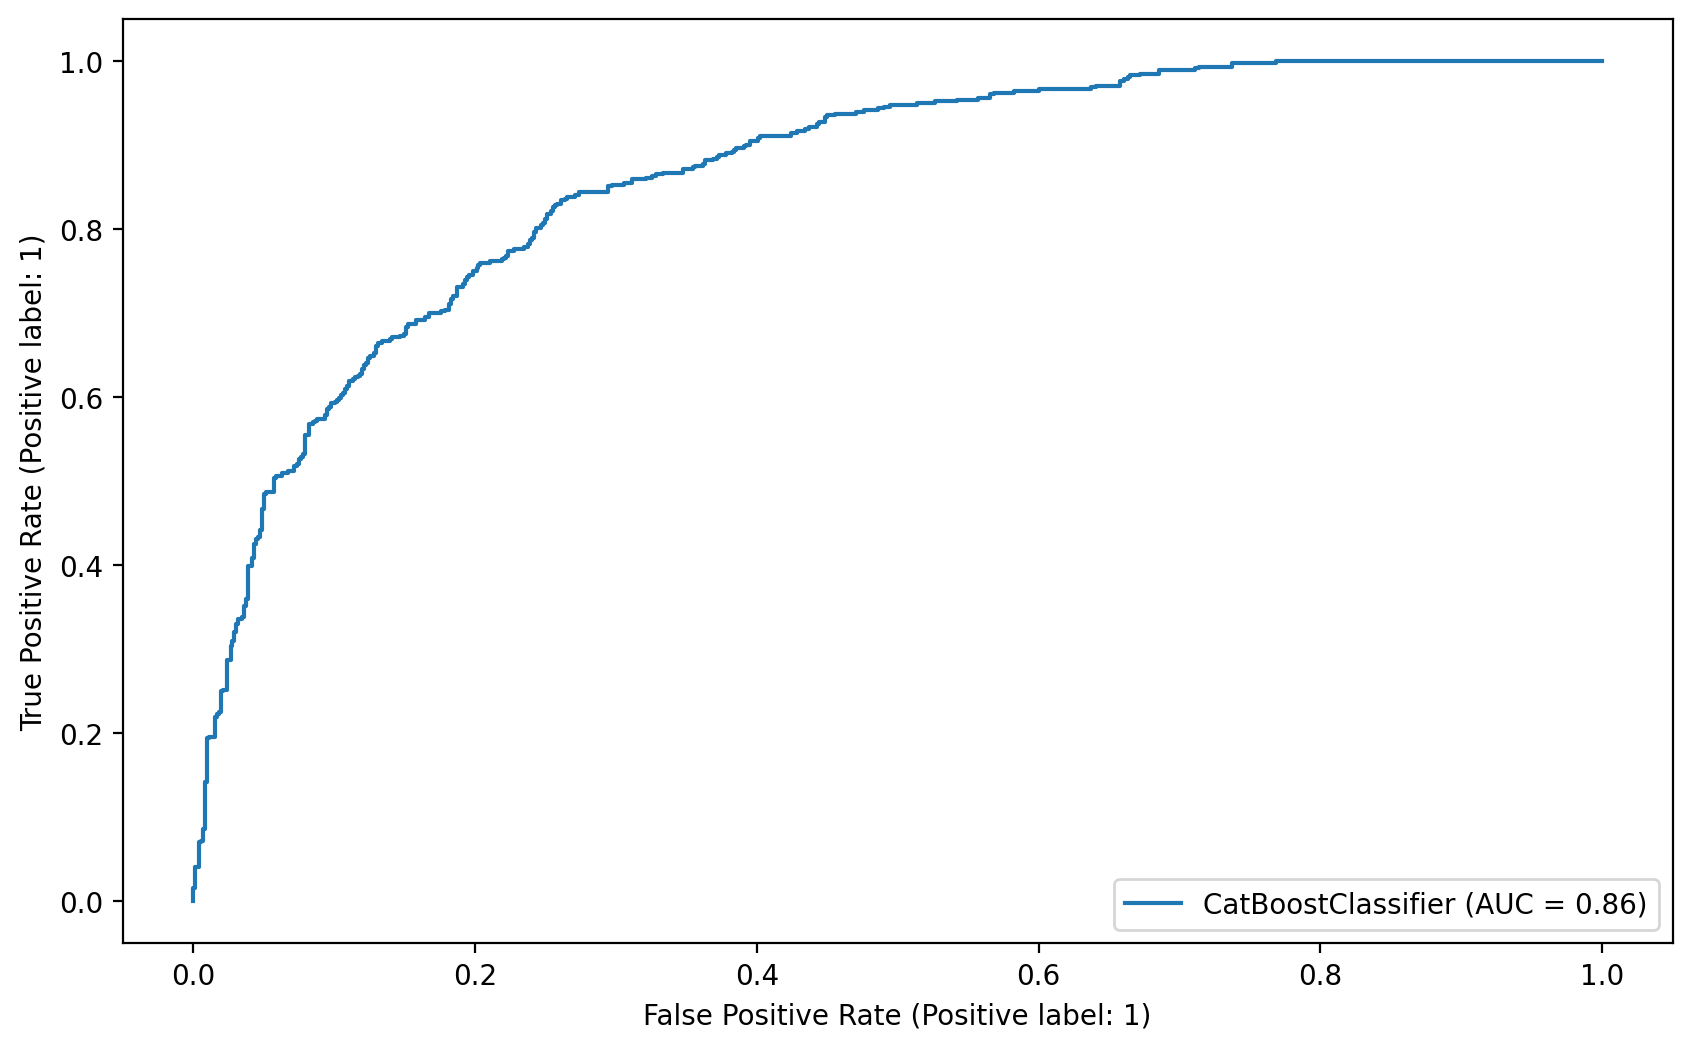

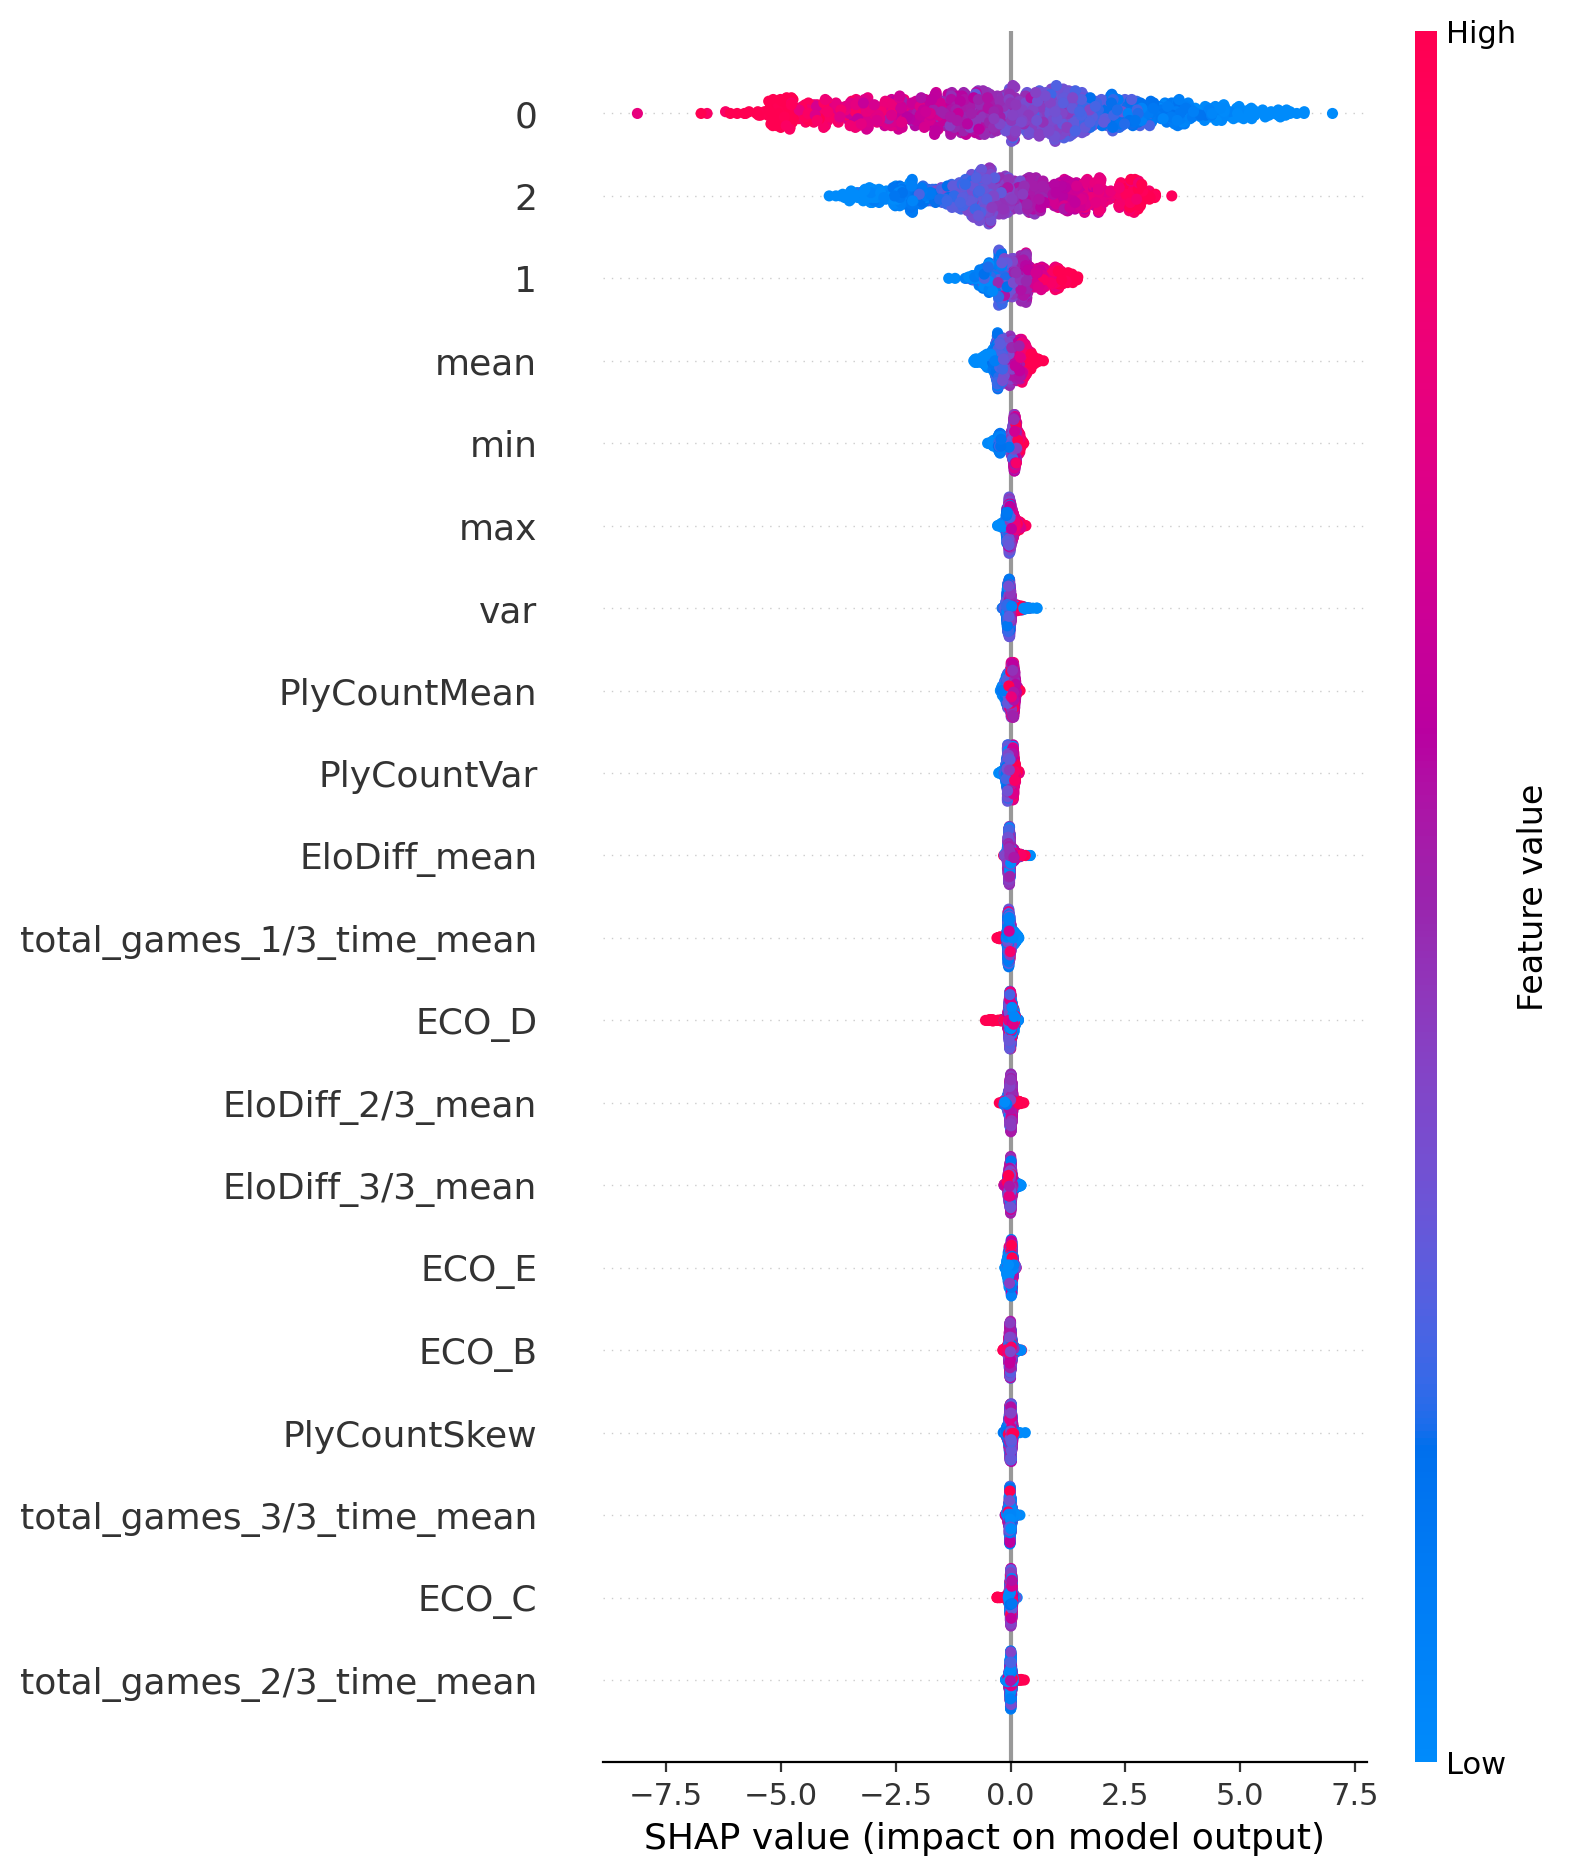

-------------------------------------------------- XGBClassifier --------------------------------------------------
Model name: XGBClassifier
accuracy_score: 0.7558333333333334
roc_auc_score: 0.7449602407049215
precision_score: 0.7130801687763713
f1_score: 0.6976264189886481


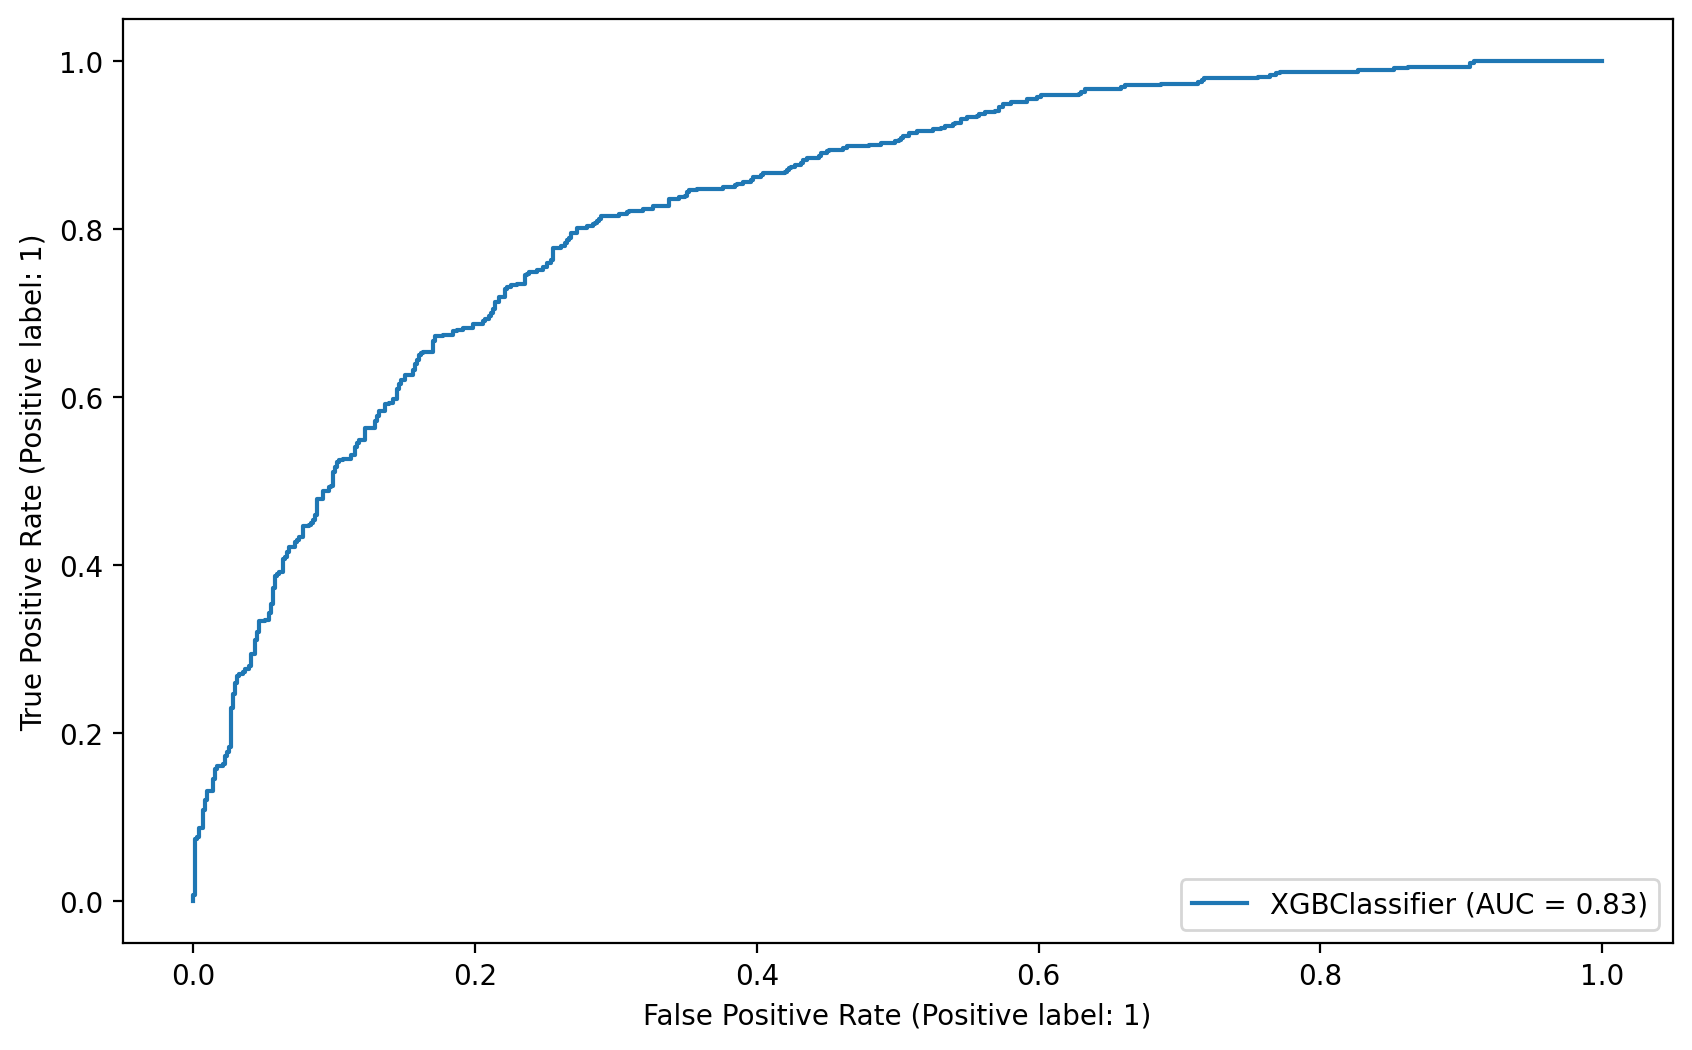

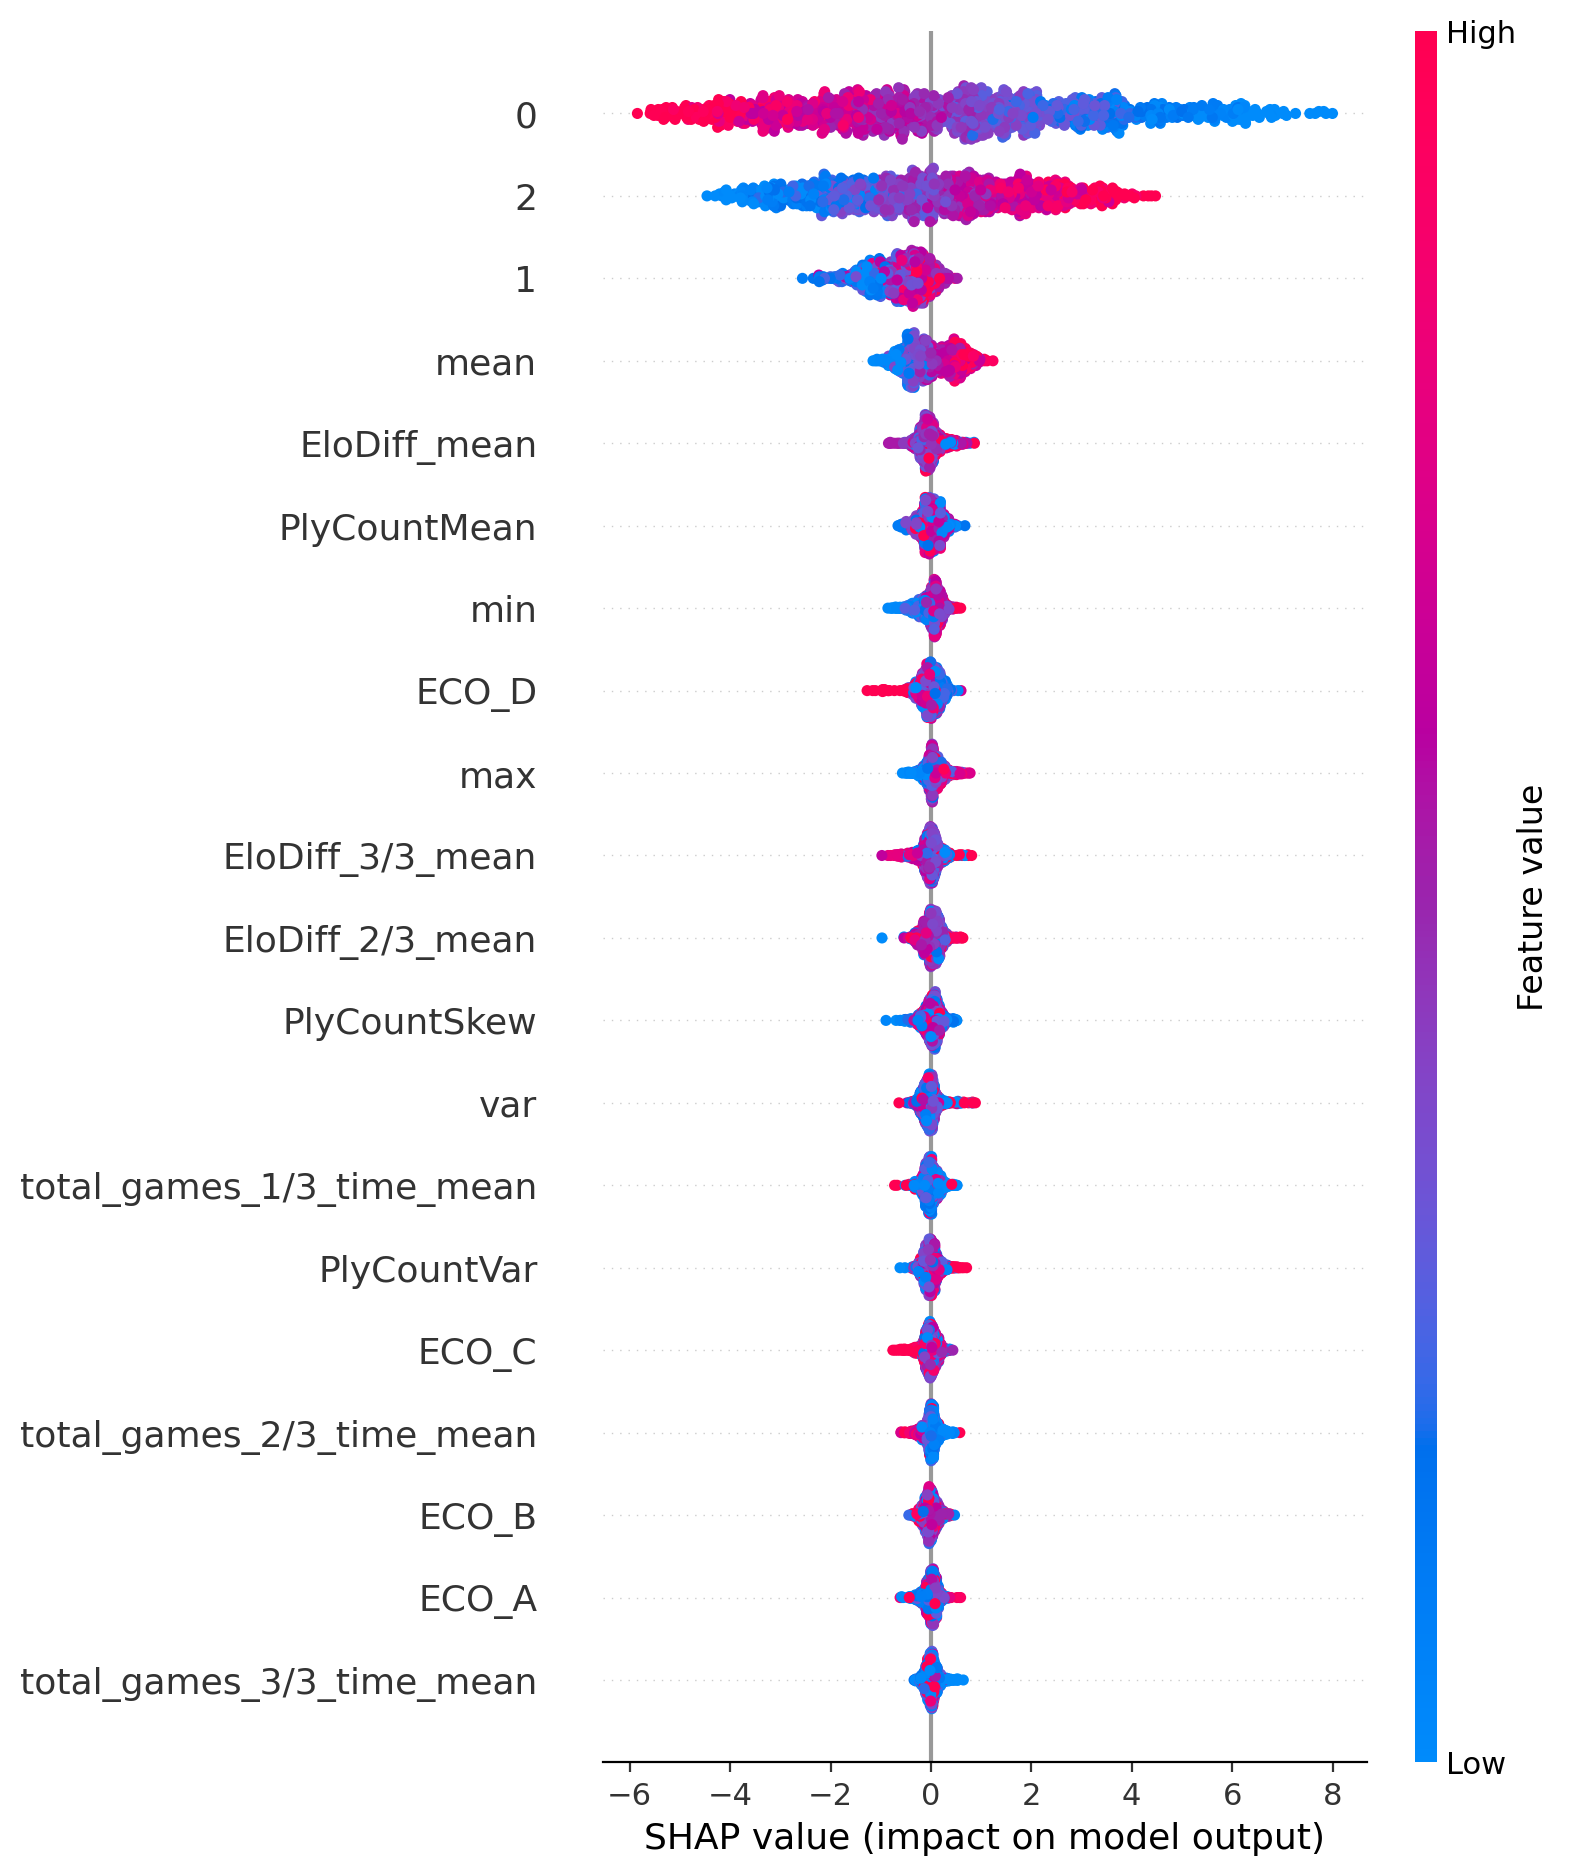

-------------------------------------------------- LGBMClassifier --------------------------------------------------
[LightGBM] [Info] Number of positive: 1945, number of negative: 2854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 4799, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.405293 -> initscore=-0.383460
[LightGBM] [Info] Start training from score -0.383460
Model name: LGBMClassifier
accuracy_score: 0.7733333333333333
roc_auc_score: 0.7568638880792772
precision_score: 0.7239819004524887
f1_score: 0.7017543859649124


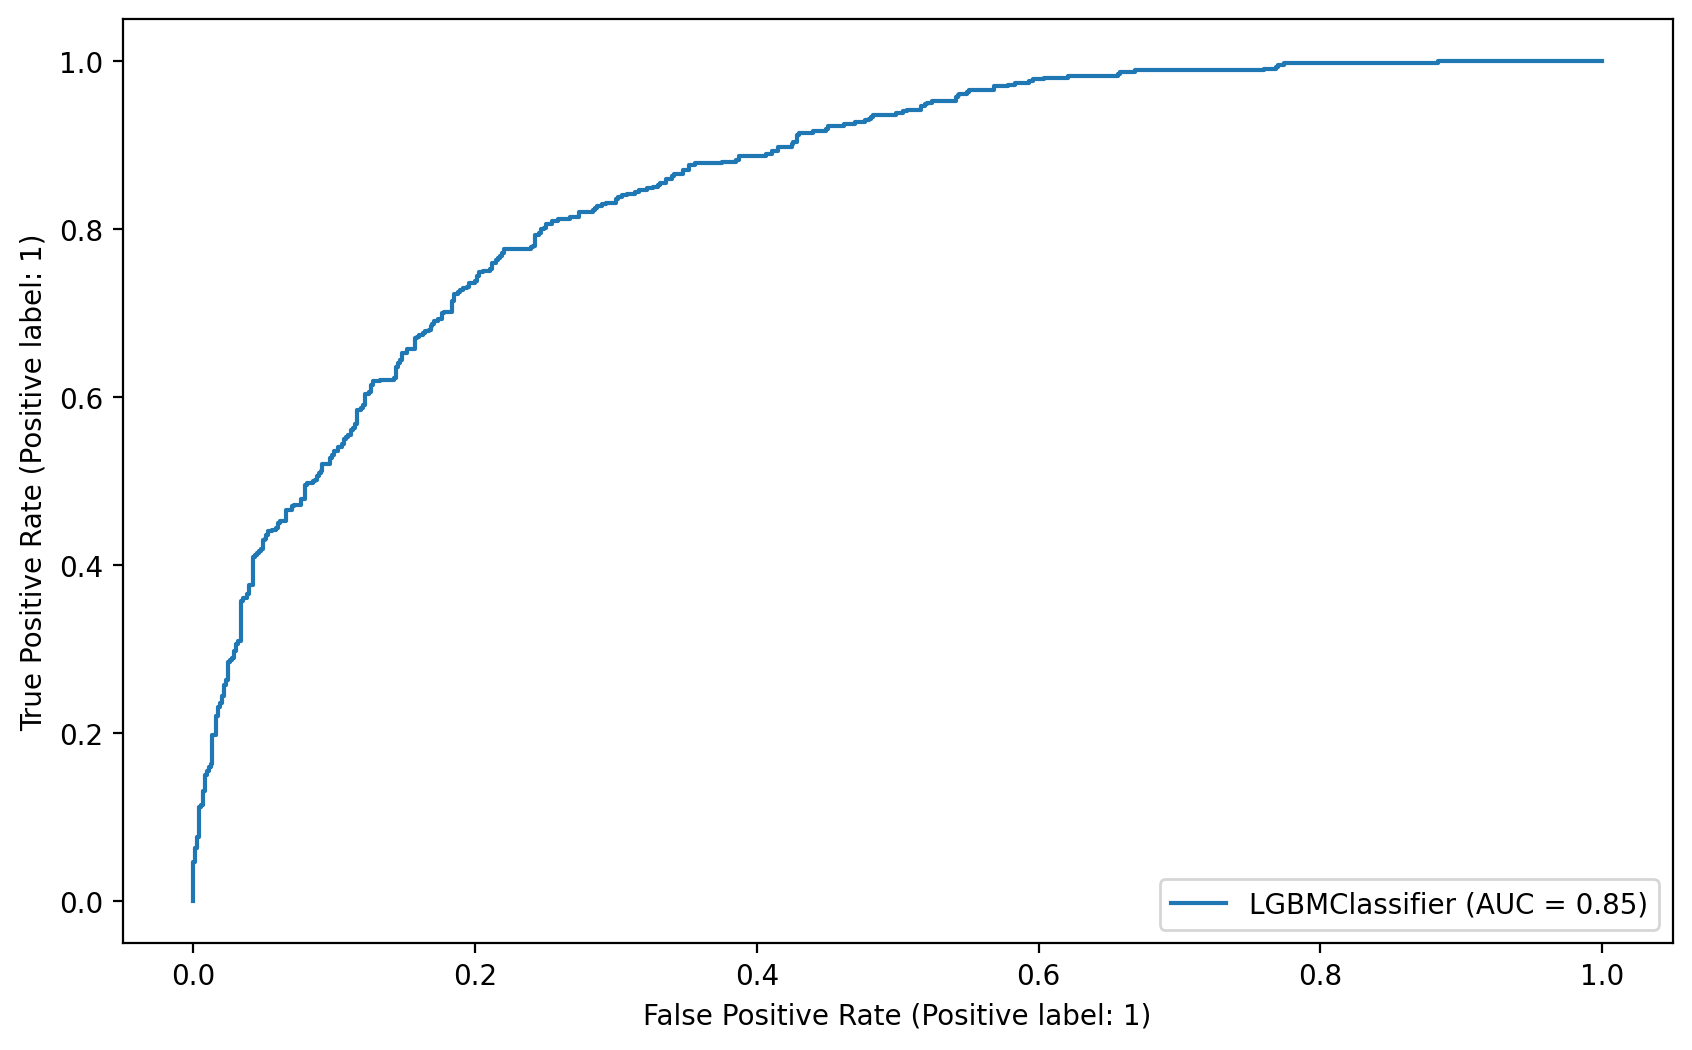

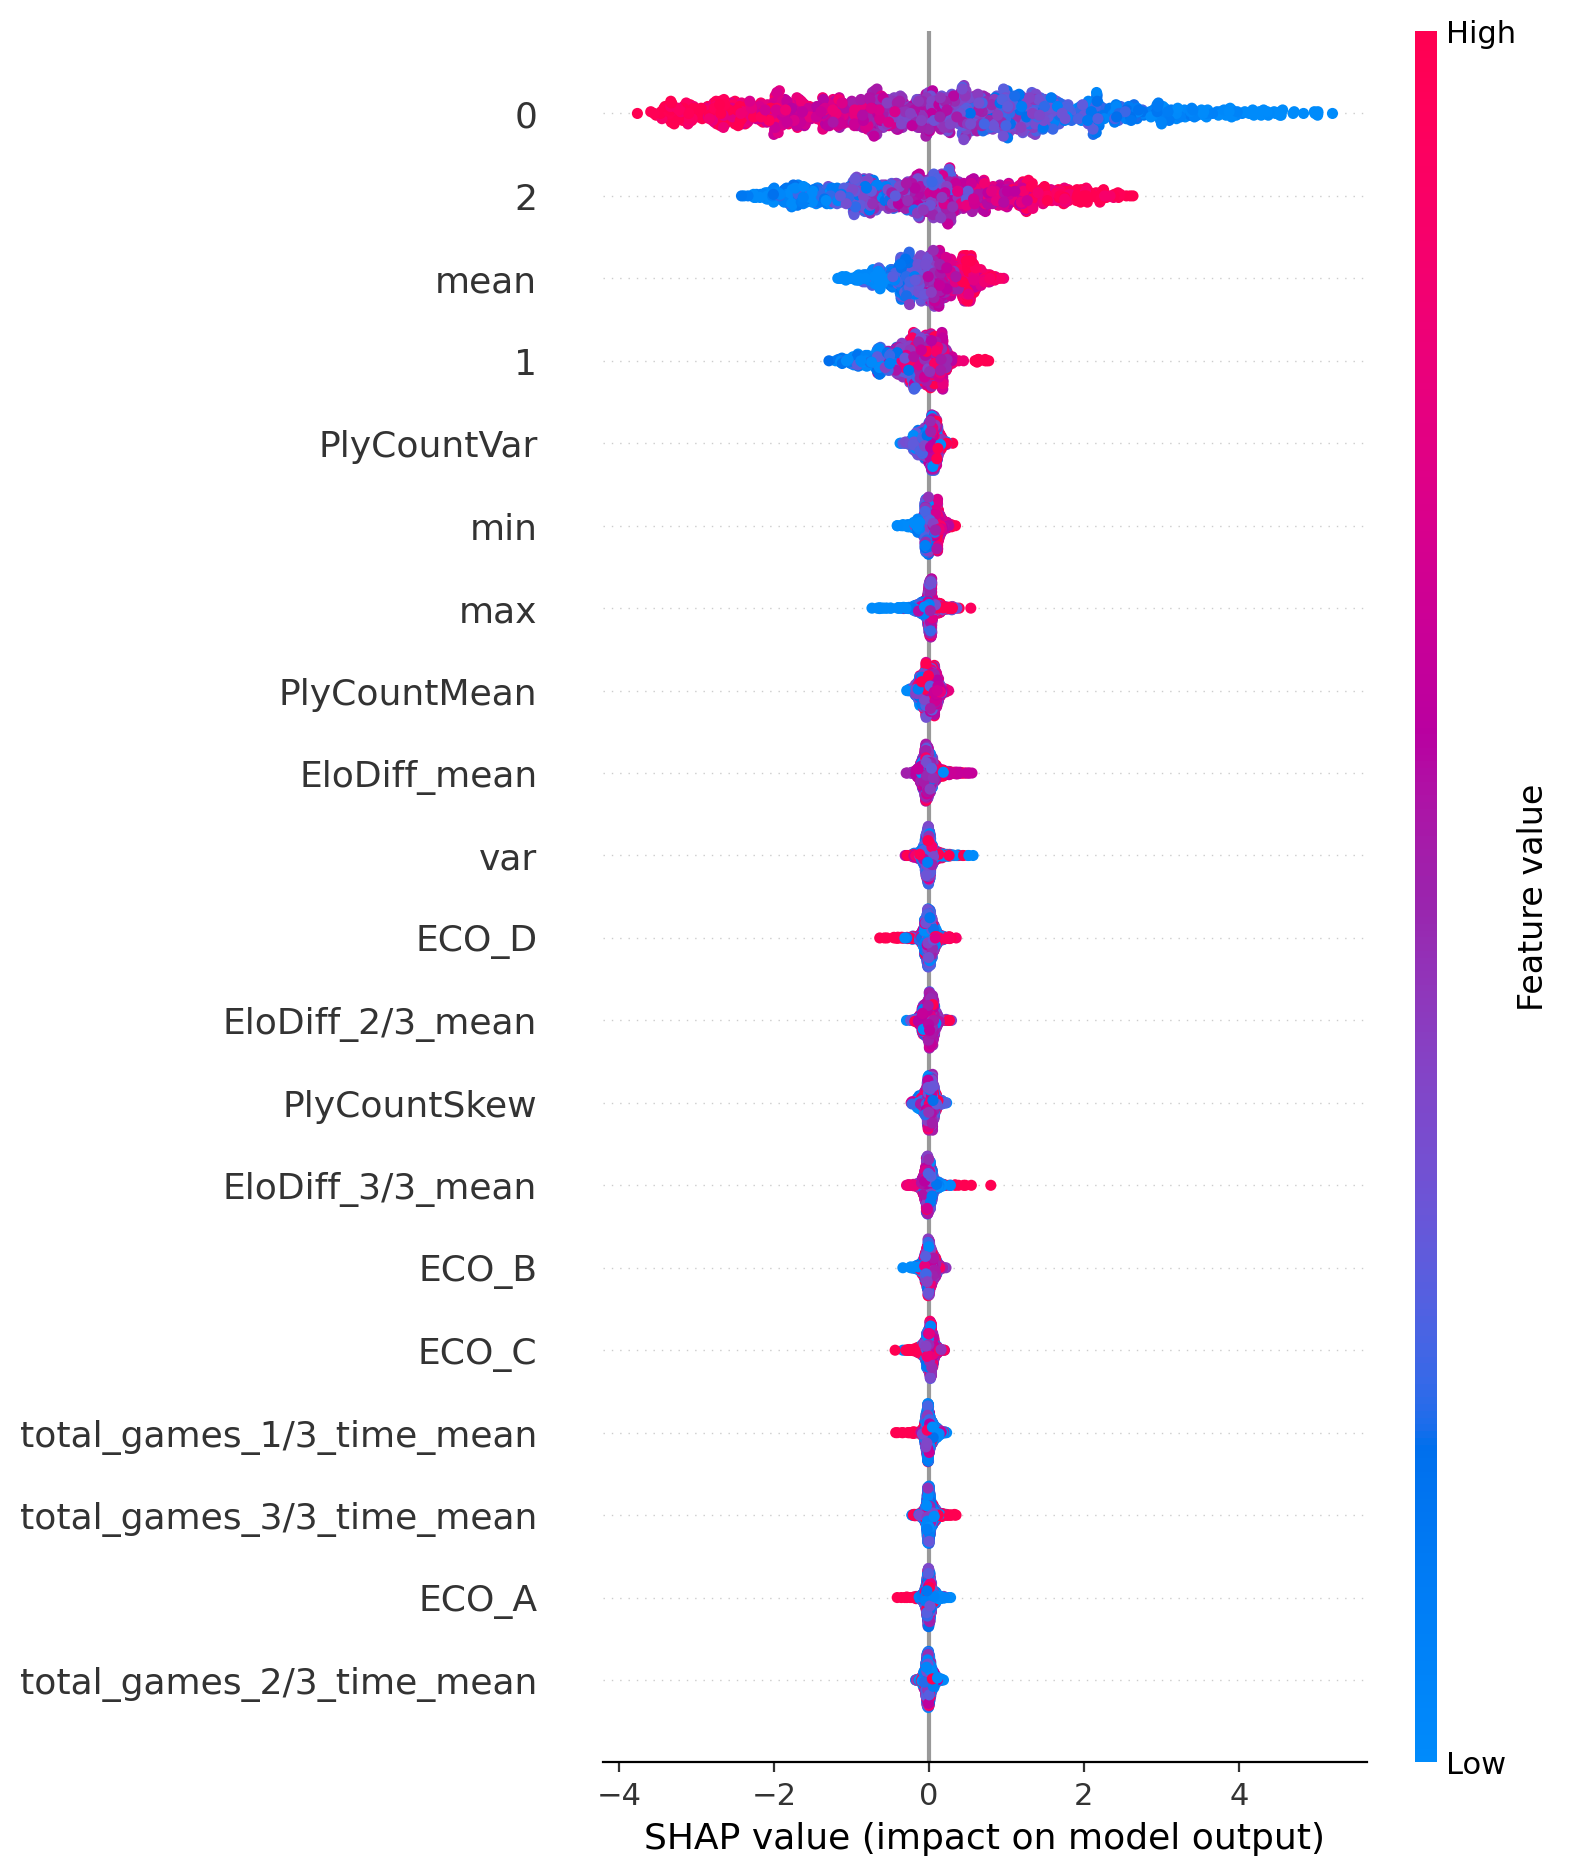

-------------------------------------------------- logistic regression --------------------------------------------------
Model name: logistic regression
accuracy_score: 0.775
roc_auc_score: 0.763112824110498
precision_score: 0.7636761487964989
f1_score: 0.7210743801652892


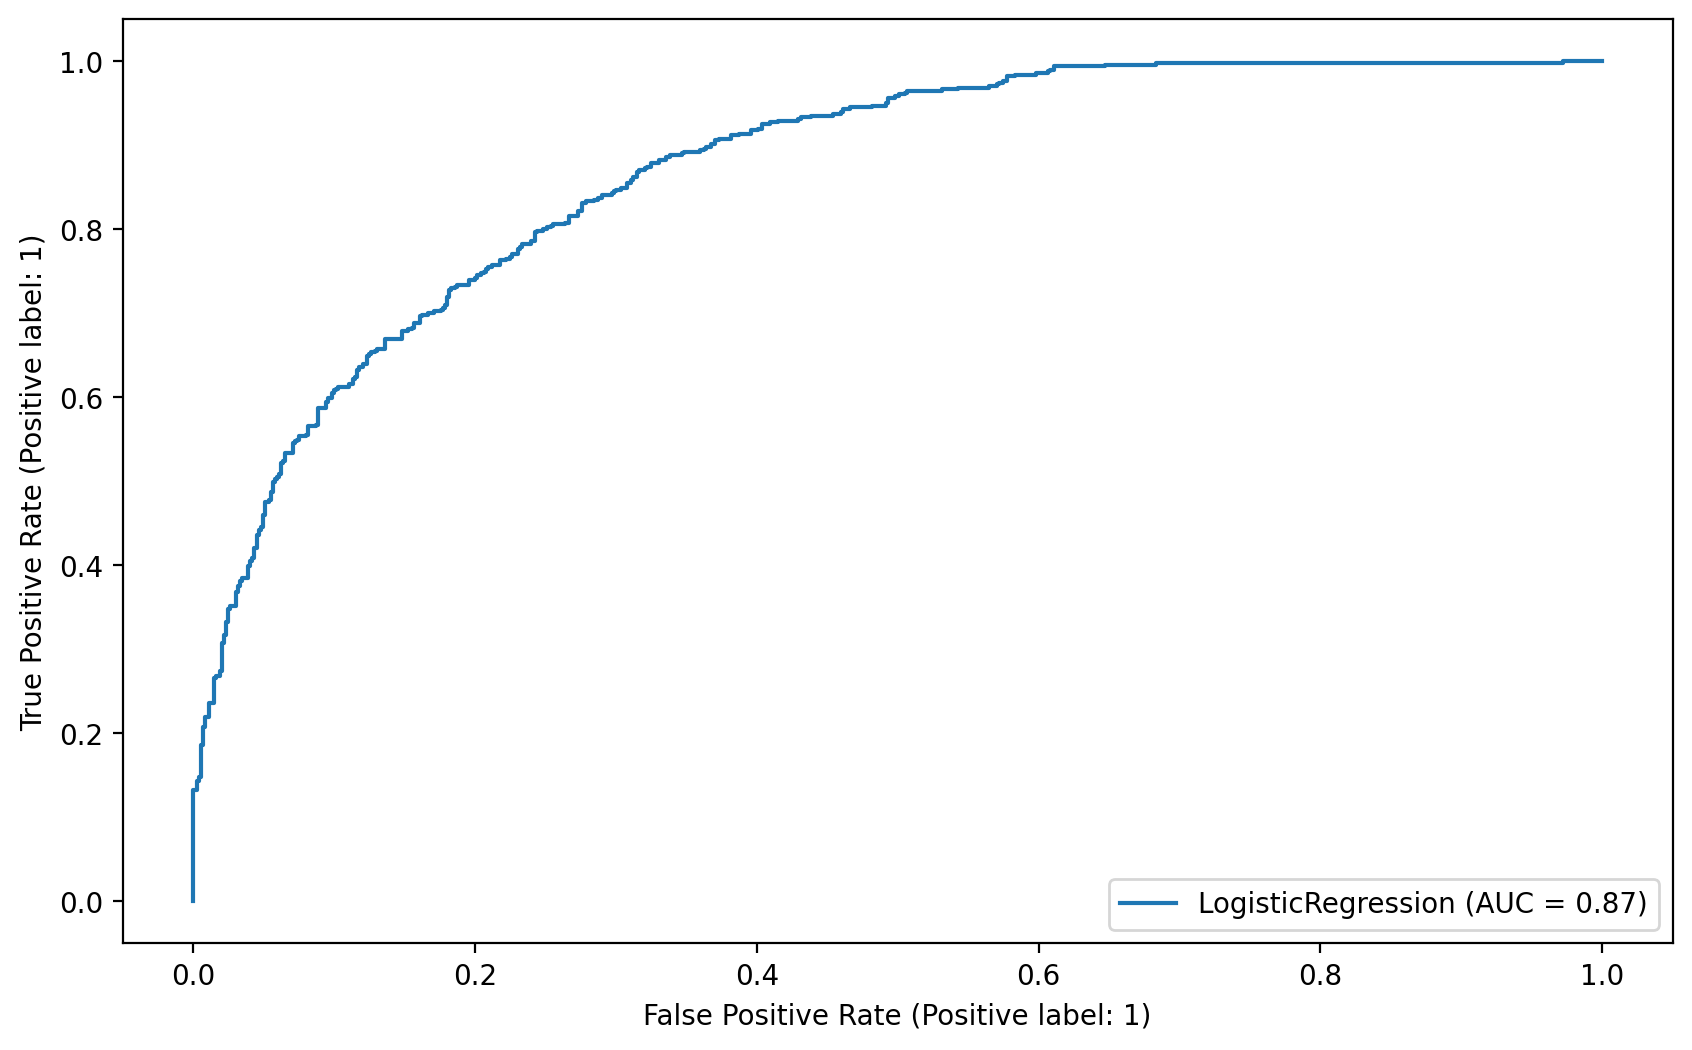

-------------------------------------------------- Support vector machine --------------------------------------------------
Model name: Support vector machine
accuracy_score: 0.6291666666666667
roc_auc_score: 0.5416666666666666
precision_score: 0.7692307692307693
f1_score: 0.1834862385321101


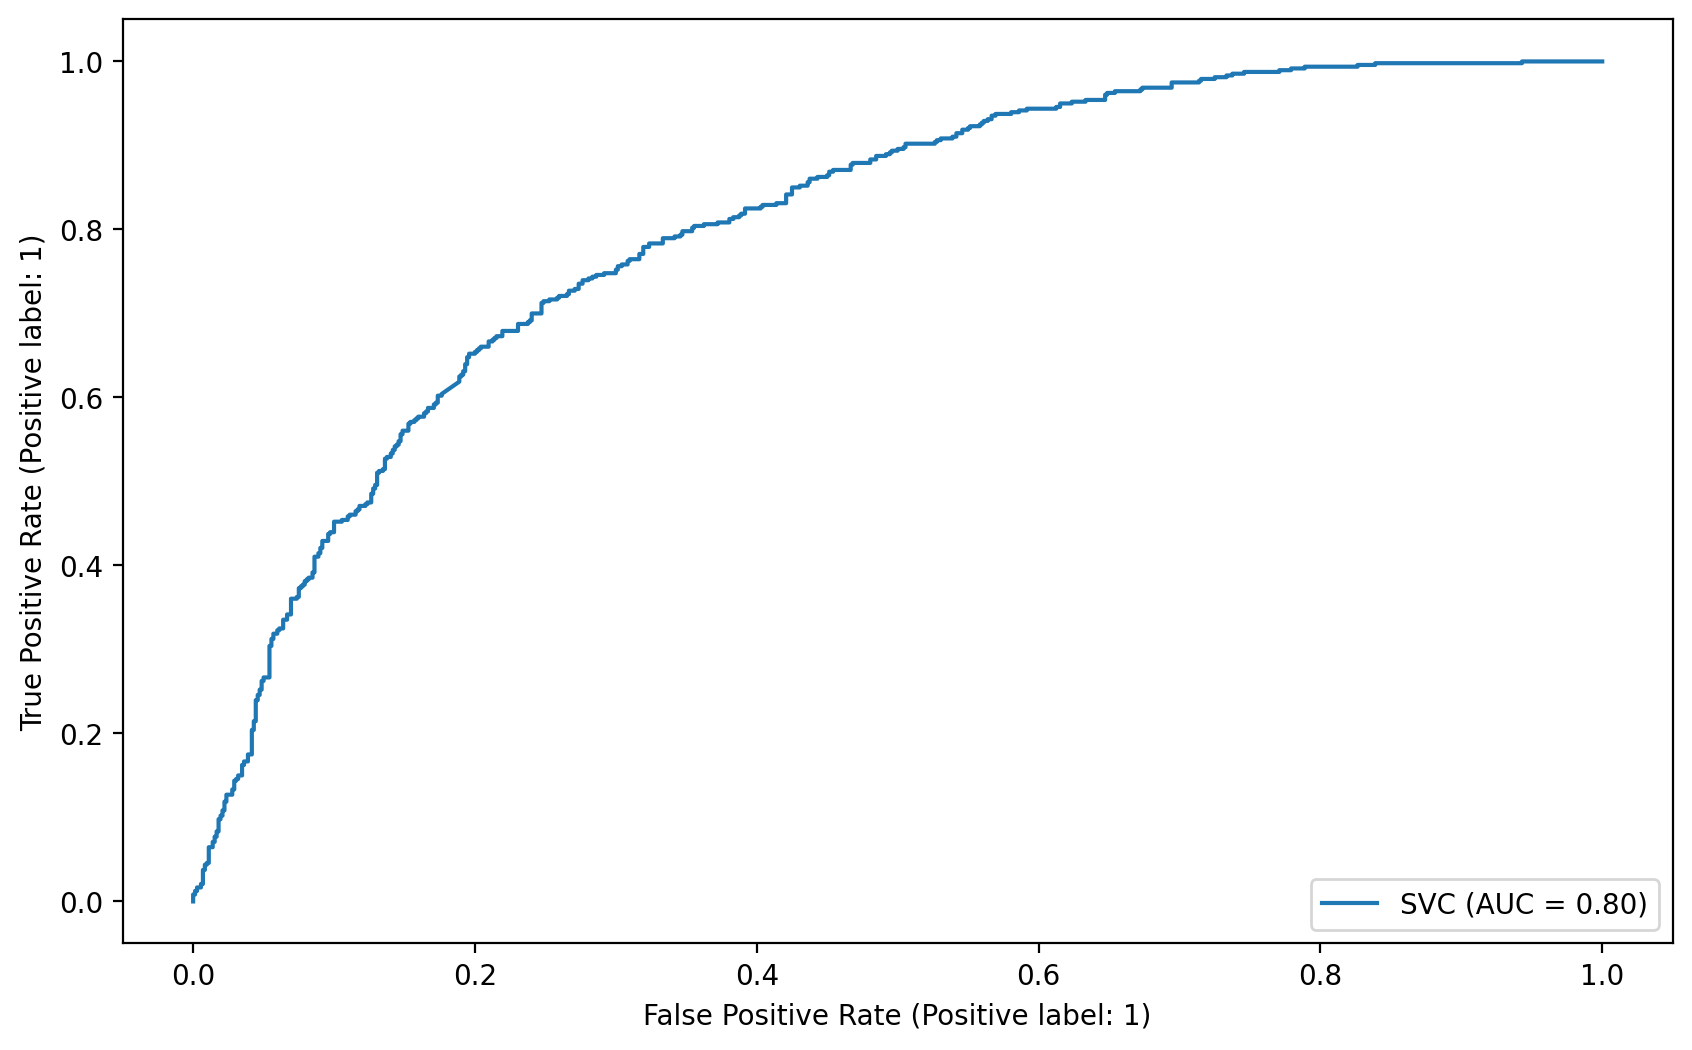

-------------------------------------------------- basic random forrest --------------------------------------------------
Model name: basic random forrest
accuracy_score: 0.73
roc_auc_score: 0.7025565402420485
precision_score: 0.7507002801120448
f1_score: 0.6232558139534884


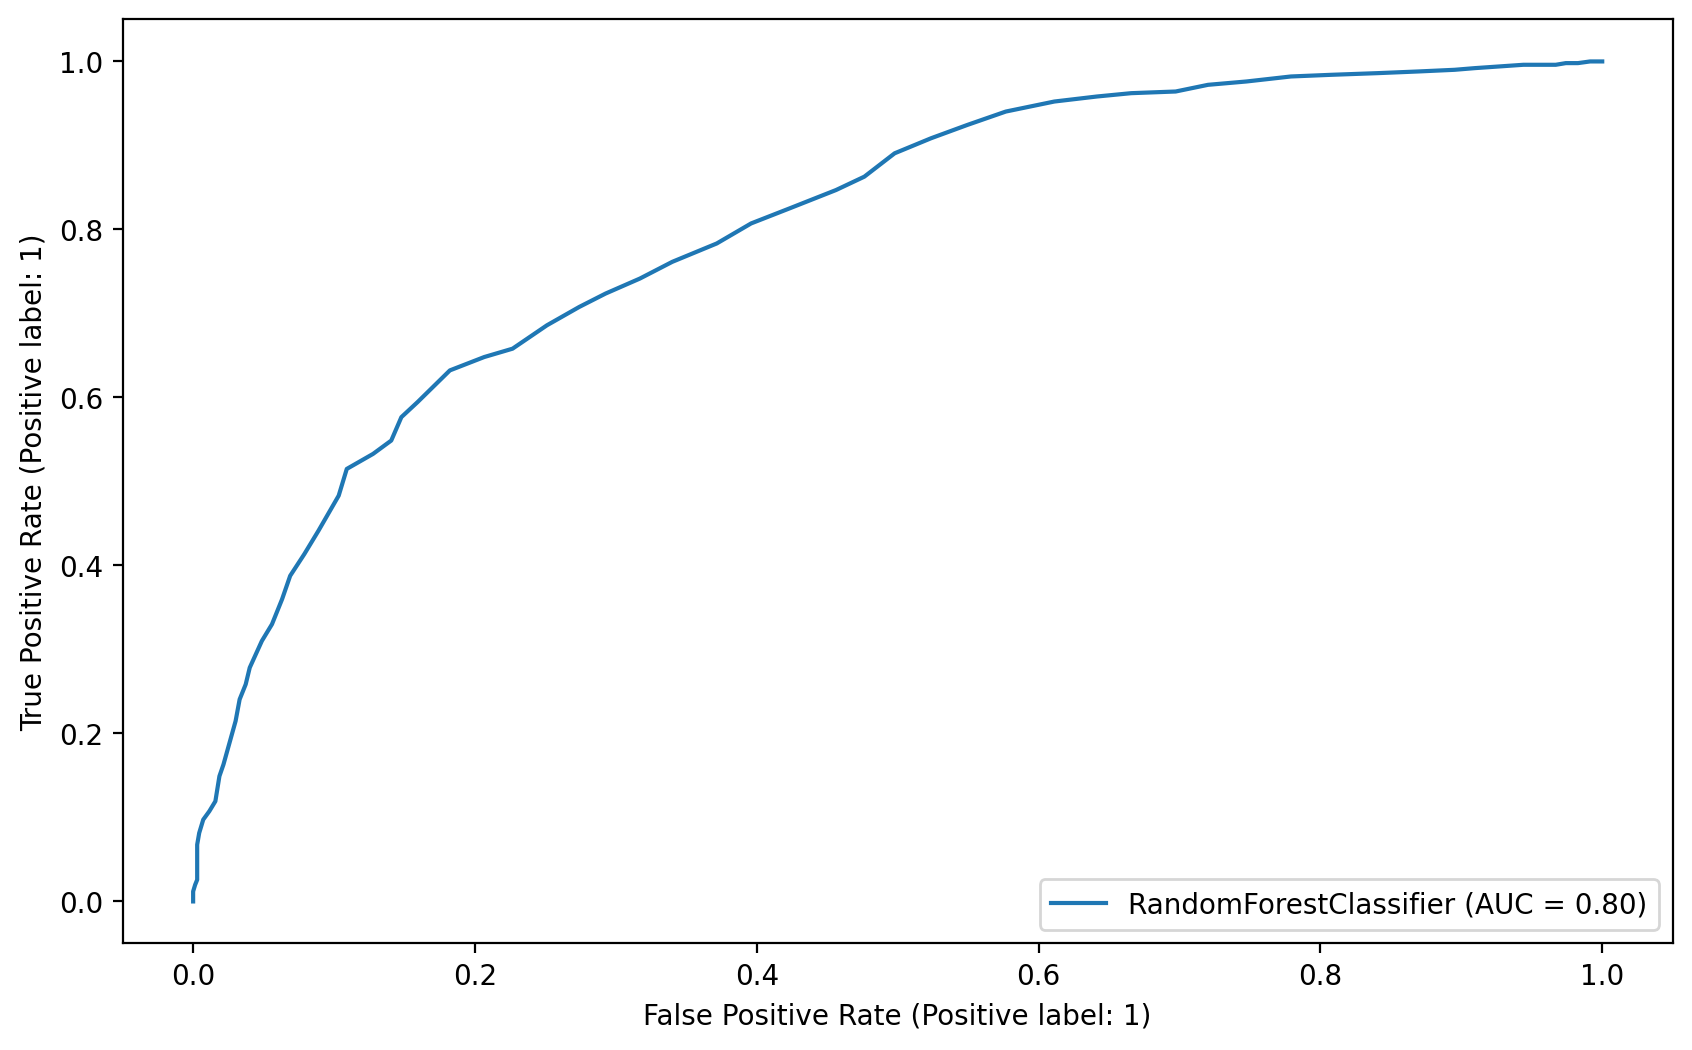

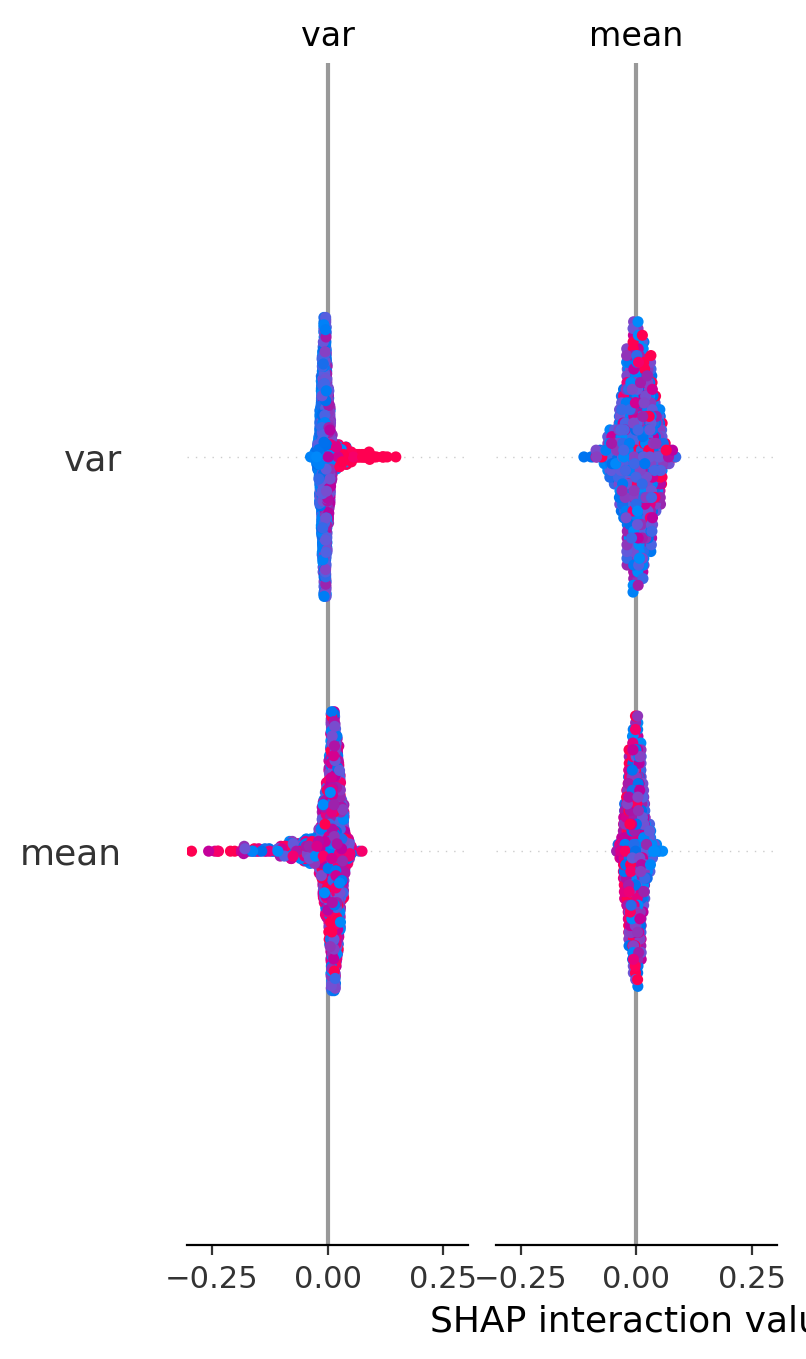

In [57]:
results=[]
for m in get_models():
    print("-"*50,m["name"],"-"*50)
    results.append(classify(join_df,0.2,m["model"],m["name"]))

### 2.4.3  Compare results

In [58]:
compare_model_results(results)

                        Accuracy  Precision  Recall      F1
logistic regression       0.7750     0.7637  0.6830  0.7211
CatBoostClassifier        0.7867     0.7740  0.6653  0.7156
LGBMClassifier            0.7733     0.7240  0.6809  0.7018
XGBClassifier             0.7558     0.7131  0.6828  0.6976
AdaBoostClassifier        0.7558     0.7478  0.5519  0.6351
decision tree             0.6983     0.6289  0.6186  0.6237
basic random forrest      0.7300     0.7507  0.5328  0.6233
KNeighborsClassifier      0.5658     0.4184  0.1677  0.2394
Support vector machine    0.6292     0.7692  0.1042  0.1835
Gaussian Naive Bayes      0.5975     0.5641  0.0892  0.1541
